# Del 0 Image and pipeline preprocessing

## Import

In [1]:
# Imports
# Del 0 og 1
# -----------------------------------------------
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.special import binom
import matplotlib.colors as mcolors



# Del 2
# -----------------------------------------------
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks


# Del 3
# -----------------------------------------------
import random 


## Bilde og sekvens definering

In [2]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def create_custom_colormap(base_cmap, special_value=-1, special_color=[255, 255, 255]):
    # Get the base colormap
    base = plt.cm.get_cmap(base_cmap)
    
    # Convert special color to range [0, 1] and include alpha channel
    special_color = np.array(special_color) / 255.0
    special_color = np.append(special_color, 1.0)  # Add alpha channel with value 1.0

    # Create a new colormap from the base colormap
    colors = base(np.linspace(0, 1, 256))
    
    # Set the color for the special value
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    special_index = int(norm(special_value) * 255)
    colors[special_index] = special_color
    
    # Create the new colormap
    new_cmap = mcolors.ListedColormap(colors)
    return new_cmap

def display_disp_image(to_be_displayed, title="Image", d_type="turbo", verticalShowCase=False):
    if verticalShowCase:
        print("Vertical showcase")
        d_type = create_custom_colormap(d_type)

    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()
    
def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        
        return column

    print("PERFORMED INTERPOLATION")
    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(input):
    dI = input.copy()
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])
    return dI

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Båt =  1689068854381001093
# Fra blanda
KajakkOgBåt = 1689068879500907093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
STANDARD_FIG_SIZE = (10, 6)

første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)



#all_disparity_images = [nærme_disparity, første_disparity, badering_første_disparity,  badering_mann_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity]
#all_images = [nærme_image, første_image, badering_første_image,  badering_mann_image, båt_image, kajakk_båt_image, båt_bak_image, båt_fram_image]


def reinitialize_images():
    første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
    nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
    båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
    kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
    båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
    båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
    badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
    badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)
    
    interpolate_each_column(nærme_disparity)
    interpolate_each_column(første_disparity)
    interpolate_each_column(badering_første_disparity)
    interpolate_each_column(badering_mann_disparity)
    interpolate_each_column(båt_disparity)
    interpolate_each_column(kajakk_båt_disparity)
    interpolate_each_column(båt_bak_disparity)
    interpolate_each_column(båt_fram_disparity)

    all_disparity_images = [nærme_disparity, første_disparity, badering_første_disparity,  badering_mann_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity]
    all_images = [nærme_image, første_image, badering_første_image,  badering_mann_image, båt_image, kajakk_båt_image, båt_bak_image, båt_fram_image]

    return  all_images, all_disparity_images

all_images, all_disparity_images = reinitialize_images()



Første: 1689072599961543541  Nærme:  1689072633388130541


#### Farge palett

In [3]:

# Dark color definitions with brightness < 128/255
Dark_Red = [100/255, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/255]  # Deep blue, similar to navy
Dark_Green = [0, 100/255, 0]  # Deep green
Bright_Red = [200/255, 0, 0]  # Bright red
Bright_Green = [0, 200/255, 0]  # Bright green
Bright_Blue = [0, 0, 200/255]  # Bright blue
Dark_Yellow = [128/255, 128/255, 0]  # Muted yellow, darkened
Dark_Purple = [75/255, 0, 130/255]  # Similar to indigo, dark purple
Dark_Orange = [255/255, 140/255, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/255, 139/255]  # Rich cyan, darkened
Dark_Magenta = [139/255, 0, 139/255]  # Deep magenta
Charcoal_Gray = [50/255, 50/255, 50/255]  # Dark gray, akin to charcoal
Dark_Lime = [50/255, 205/255, 50/255]  # A darker shade of lime green
Dark_Pink = [255/255, 20/255, 147/255]  # Deep pink, darkened
Dark_Olive = [85/255, 107/255, 47/255]  # Muted, darker olive green
Dark_Turquoise = [0, 206/255, 209/255]  # Deep turquoise
Dark_Brown = [165/255, 42/255, 42/255]  # A rich, dark brown
Dark_Goldenrod = [184/255, 134/255, 11/255] # Dark goldenrod
White = [1, 1, 1]  # White
Black = [0,0,0]
Dark_gray = [0.2,0.2,0.2]
Gray = [0.5,0.5,0.5]
Bright_Gray = [0.8,0.8,0.8]

Dark_red_orange = (150, 69, 0)
Dark_magenta = (139, 0, 139)
Dark_red = (139, 0, 0)
Dark_pink_orange = (150, 105, 180)
Dark_brown = (139, 69, 19)
Bright_Yellow = (255, 255, 0)
Dark_pink = (150, 112, 147)
Deep_Blue = (0, 0, 255)
Brightest_Blue = [0, 150/255, 255/255]
Brightest_Green = [80/255, 255/255, 150/255]
Brightest_Red = (255, 0, 0)
White = (255, 255, 255)


colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': Dark_gray,  
    'undecided': White,  # White
    'vertical': Bright_Red,
    'horizontal': Bright_Green
}


verticalFocusColourScheme = {
    'vertical1': Bright_Red,
    'vertical2': Dark_Yellow,
    'vertical3': Dark_Magenta,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': Brightest_Blue,  
    'undecided': White,  # White
    'horizontal': Brightest_Green
}

horizontalFocusColourScheme = {
    'horizontal1': Dark_Red,
    'horizontal2': Dark_Orange,
    'horizontal3': Dark_Olive,
    'horizontal4': Dark_Blue,
    'horizontal5': Dark_Pink, 
    'horizontal6': Dark_Yellow,  # Dark Orchid
    'horizontal7': Dark_Red,  # Dark Goldenrod
    'unknown': Brightest_Blue,  
    'undecided': White,  # White
    'vertical': Brightest_Green,
    'vertical1': Brightest_Green,
    'vertical2': Brightest_Green,
    'vertical3': Brightest_Green,
    'vertical4': Brightest_Green,
    'vertical5': Brightest_Green, 
    'vertical6': Brightest_Green,  # Dark Orchid
    'vertical7': Brightest_Green,  # Dark Goldenrod
}




### Start metoder og definisjoner

In [4]:

def generate_dark_colors(n, shuffle_bool=False):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)

    if(shuffle_bool):
        random.shuffle(colors)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=True):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=STANDARD_FIG_SIZE)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()


def derivative_graphing(derivatives, column):
        plotting_der = derivatives[:,column]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plotting_der)
        plt.title('Derivative Values at Column Index ' +str(column))
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Derivative Value')
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(200,0,0), (0,200,0), (0,0,200)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)

def display_columns_on_image_V2(original_image, col_indices=[500], line_thickness=5, return_image=False):
    # Use a copy of the original image to draw on
    og_image = original_image.copy()
    height = og_image.shape[0]
    width = og_image.shape[1]

    title = "Columns on Original Image"

    # Half the thickness to apply on each side of the column
    half_thickness = line_thickness // 2

    # Iterate over each column index you want to display
    for col_idx in col_indices:
        if col_idx >= width:
            print("Column index out of image bounds:", col_idx)
            continue

        # Calculate the range to apply the thickness
        start_col = max(0, col_idx - half_thickness)
        end_col = min(width, col_idx + half_thickness + 1)

        # Iterate over each pixel in the specified column range
        for row in range(height):
            # Get the brightness of the main column pixel
            main_pixel = og_image[row, col_idx]
            main_brightness = 0.299 * main_pixel[0] + 0.587 * main_pixel[1] + 0.114 * main_pixel[2]

            # Choose the line color based on the main pixel brightness
            if main_brightness < 128:  # Dark pixel, make the line white
                line_color = (255, 255, 255)
            else:  # Light pixel, make the line black
                line_color = (0, 0, 0)

            # Apply this color to the surrounding pixels based on the thickness
            for adj_col in range(start_col, end_col):
                og_image[row, adj_col] = line_color

    # Display the modified image (assuming display_disp_image is a function you have for displaying/saving)
    display_disp_image(og_image, title=title)
    if(return_image):
        return og_image
    return



In [5]:
testing_very_first_methods = False

if(testing_very_first_methods):

    current_disparity_data = første_disparity.copy()
    current_image = første_image.copy()
    interpolate_each_column(current_disparity_data)
    display_disp_image(current_image, "Original Image")
    display_columns_on_image_V2(current_image,line_thickness=5)
    disparity_graphing(current_disparity_data, col_indices=[500], display=True)
    #display_disp_image(current_disparity_data, "Interpolated Disparity Image")


## Plotting av bilder og disparity profiler

In [6]:
plot_initial_images = False

plot_disparity_graphing = False
testing_image = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    if(plot_disparity_graphing):
        display_columns_on_image(current_original_image, curr_col)
        display_columns_on_image_V2(current_original_image, curr_col)
        disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
 


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    if(plot_disparity_graphing):
        
        display_columns_on_image(nærme_image, cols_nærme)
        display_columns_on_image_V2(nærme_image, cols_nærme)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    if(plot_disparity_graphing):
        display_columns_on_image(første_image, cols_første)
        display_columns_on_image_V2(første_image, cols_første)
        disparity_graphing(første_disparity, cols_første, display=True, invert=False)
        disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    if(plot_disparity_graphing): 
        display_columns_on_image(badering_første_image, cols_badering)
        display_columns_on_image_V2(badering_første_image, cols_badering)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    if(plot_disparity_graphing):
        display_columns_on_image(badering_mann_image, cols_mann)
        display_columns_on_image_V2(badering_mann_image, cols_mann)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_image, cols_båt)
        display_columns_on_image_V2(båt_image, cols_båt)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    if(plot_disparity_graphing):
        display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
        display_columns_on_image_V2(kajakk_båt_image, cols_båtKajakk)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_bak_image, cols_båtBak)
        display_columns_on_image_V2(båt_bak_image, cols_båtBak)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_fram_image, cols_båtFram)
        display_columns_on_image_V2(båt_fram_image, cols_båtFram)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image



# Del 1 Initial Segmentation

## Main methods for initial segmentation

### Constants

In [7]:
MIN_LIKELIHOOD= 0.5
MAX_LIKELIHOOD= 2

DERIVATIVE_MIN = -0.05
DERIVATIVE_MAX = 0.15


In [8]:
from scipy.special import binom


def create_binomial_kernel(n=31):
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 
    return kernel_binomial

kernel_binomial = create_binomial_kernel(30)


def low_pass_filter(column, K=kernel_binomial, padding=False):
    if padding:
        # Padding function to repeat edge values
        def pad_with_edge_values(signal, pad_width):
            return np.pad(signal, pad_width, mode='edge')

        # Pad the signal with edge values
        pad_width = len(K) // 2
        column = pad_with_edge_values(column, pad_width)
        filtered_column = np.convolve(column, K, mode='valid')
    else:
        filtered_column = np.convolve(column, K, mode='same')

    return filtered_column

# Function to apply low-pass filter to a 2D array (disparity image)
def apply_low_pass_filter(dI, K=kernel_binomial, padding=False):
    height, width = dI.shape
    df = np.zeros_like(dI)  # Low-pass filtered disparity image

    for x in range(width):
        if padding:
            filtered_column = low_pass_filter(dI[:, x], K, padding=True)
            pad_width = len(filtered_column) - height
            if pad_width > 0:
                filtered_column = filtered_column[pad_width//2 : -pad_width//2]
        else:
            filtered_column = low_pass_filter(dI[:, x], K, padding=False)
        df[:, x] = filtered_column[:height]

    return df


# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000, input_range=(-0.2,0.3), y_lim=(0,80000)):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_derivatives, bins=input_bins, range=input_range, color='blue', edgecolor='blue')
        plt.title(title)
        plt.ylim(y_lim)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives

# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram_remove_zero(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000, input_range=(-0.2,0.3), y_lim=(0,80000)):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()
    sin_zero = flattened_derivatives[flattened_derivatives != 0]

    if(plot):
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(sin_zero, bins=input_bins, range=input_range, color='blue', edgecolor='blue')
        plt.title(title)
        #plt.ylim(y_lim)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return sin_zero


def take_derivative_diff(df, axe=0):
    print("Diff method")

    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=axe)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')

    return df_derivative



def take_derivative_sobel(df, normalize=True, axe=0):
    print("Sobel method")  

    # Define the 1D Sobel kernelS
    kernel_m = np.array([1, 0, -1])

    # Initialize an array to store the vertical derivative image
    vertical_derivative = np.zeros_like(df)

    # Apply the Sobel kernel to each column
    if(axe==0):
        if(normalize):
            for i in range(df.shape[1]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
        else:
            for i in range(df.shape[1]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')
    else:
        if(normalize):
            for i in range(df.shape[0]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
        else:
            for i in range(df.shape[0]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')

    return vertical_derivative


## Clustering
def clustering(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    clipped_derivatives = clipped_derivatives[(clipped_derivatives > a_mini) & (clipped_derivatives < a_maxi)]
    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def plot_clusters(clustering_model, labels, input_range=(-0.05, 0.15)):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]

    plt.figure(figsize=(10, 6))
    plt.hist(cluster1, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 1')
    plt.legend()
    plt.show()

    # Plot histogram 
    plt.figure(figsize=(10, 6))
    plt.hist(cluster2, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(clustering_model, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of both clusters')
    plt.legend()
    plt.show()

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def fit_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]
    mean1, stddev1 = fit_gaussian(cluster1)
    mean2, stddev2 = fit_gaussian(cluster2)

    return mean1, mean2, stddev1, stddev2

def gaussian_curve(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)


def cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=1, plot=True, input_range=(-0.1, 0.2)):
    mean1, mean2, stddev1, stddev2 = fit_clusters(clustering_model, labels)
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev

    if(plot):
        print("NÅ ER VI HER")
        # Create a range of x values
        x_values = np.linspace(-0.25, 0.45, 400)

        # Gaussian curves
        gaussian_curve1 = gaussian_curve(x_values, mean1, stddev1)
        gaussian_curve2 = gaussian_curve(x_values, mean2, stddev2)

        cluster1 = clustering_model[labels == 0]
        cluster2 = clustering_model[labels == 1]
        #x_min, x_max = -5, 5
        #plt.xlim(x_min, x_max)
        x_min, x_max = input_range[0], input_range[1]

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(cluster1, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(cluster2, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()
        
    return red_dL, red_dU, green_dL, green_dU

# NOT IN USE
""" def thresholds_3_gaussians(flattened_derivatives, min_clip=-0.3, max_clip = 0.5, bins = 200, plot=True, k=2):
    num_curves = 3

    # Example flattened_derivatives - replace with your actual data
    # flattened_derivatives = ...

    # Clip the data between -0.3 and 0.6
    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)

    # Removing extreme values
    filtered_data = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]
    clipped_derivatives = filtered_data

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    #gmm = GaussianMixture(n_components=2, random_state=0, init_params='kmeans++')

    gmm.fit(clipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()

    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)
        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(2)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()
    
    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

    # Below are the upper and lower bounds
    # Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev


    return red_dL, red_dU, green_dL, green_dU """

def thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=400,p=0.01, k=2, plot=True, version=1, clip="reclip", perform_crop=True):
    print("Thresholds Clipping version")

    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)

    peaks, _ = find_peaks(hist_values)

    # If there are at least two peaks, find the second largest
    
    sorted_peaks = sorted(peaks, key=lambda x: hist_values[x], reverse=True)
    largest_peak = sorted_peaks[0]
    second_largest_peak = sorted_peaks[1]

    largest_mode = bin_edges[largest_peak]
    second_largest_mode = bin_edges[second_largest_peak]
    
    largest_frequency = hist_values[largest_peak]
    second_largest_frequency = hist_values[second_largest_peak]
    
    print("Largest mode:", largest_mode)
    print("Second largest mode:", second_largest_mode)
    print("Frequency of the largest mode:", largest_frequency)
    print("Frequency of the second largest mode:", second_largest_frequency)
   
    if(abs(largest_mode) <0.01):
        print("Sky peak present")
        threshold = p * second_largest_frequency
    else:
        print("Small sky peak only")
        threshold = p * largest_frequency
    if(plot):
        print("Maximum frequency in the histogram:", second_largest_frequency)
        print(f"Threshold ({p*100}% of second largest frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)    

    if(clip == "absolute"):
        print("Reclipping absolute version")
        reclipped_derivatives = clipped_derivatives[(clipped_derivatives > DERIVATIVE_MIN) & (clipped_derivatives < DERIVATIVE_MAX)]
    elif(clip == "regular"):
        print("Regular clipping")
        reclipped_derivatives = clipped_derivatives
    else:
        print("Reclipping percentage version")
        # Find the indices of non-zero bins in the smoothed histogram 
        non_zero_indices = np.nonzero(smooth_hist_values)[0]

        mask = np.zeros_like(clipped_derivatives, dtype=bool)

        # Loop over non-zero bins to create the mask
        for idx in non_zero_indices:
            mask |= (clipped_derivatives >= bin_edges[idx]) & (clipped_derivatives < bin_edges[idx + 1])

        # Apply the mask to get reclipped derivatives
        reclipped_derivatives = clipped_derivatives[mask]
        """ 
        # Extract the minimum and maximum value along the value axis
        min_value_range = bin_edges[non_zero_indices[0]]
        max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin
        reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  
        """

    x_min=-0.10    
    x_max=0.20
    max_y = 80

    if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        #plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')
        if(perform_crop):
            plt.hist(reclipped_derivatives, bins=num_bins, range=(x_min, x_max), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        else:
            plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Derivatives')
        plt.ylabel('Frequency')

        plt.show()
        
    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    gmm.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()
    if(plot):
        print("means: ", means)
        print("std_devs: ", std_devs)
        print("weights: ", weights)


    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)

        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))            
            #norm.pdf(x_values, means[i], np.sqrt(covariances[i]))

            for i in range(num_curves)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        if(perform_crop):
            plt.hist(reclipped_derivatives, bins=num_bins, range=(x_min, x_max), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        else:
            plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')
            if(perform_crop):
                plt.xlim(x_min, x_max)
        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Derivatives')
        plt.ylabel('Frequency')

        plt.show()

    

    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]


    if(version==1):
        print("Returning thresholds")
        # Determine which mean is closer to 0 and assign labels
        if abs(mean1) < abs(mean2):
            red_mean, green_mean = mean1, mean2
            red_stddev, green_stddev = stddev1, stddev2
            red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
        else:
            red_mean, green_mean = mean2, mean1
            red_stddev, green_stddev = stddev2, stddev1
            red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


        red_dL = red_mean - k * red_stddev
        red_dU = red_mean + k * red_stddev
        green_dL = green_mean - k * green_stddev
        green_dU = green_mean + k * green_stddev

        return red_dL, red_dU, green_dL, green_dU
    else:
        print("Returning means and standard deviations")
        print("Mean1:", mean1,  "Stddev1:", stddev1)
        print("Mean2:", mean2, "Stddev2:", stddev2)
        return mean1, mean2, stddev1, stddev2 

def gaussian_likelihood(x, mu, sigma):
    if sigma == 0:
        return 0 if x != mu else float('inf')
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def compute_likelihood_ratio(x, mu1, mu2, sigma1, sigma2, only_return_ratio=True):
    P_x_gaussian1 = gaussian_likelihood(x, mu1, sigma1)
    P_x_gaussian2 = gaussian_likelihood(x, mu2, sigma2)
    L_x = P_x_gaussian1 / P_x_gaussian2

    if(only_return_ratio):
        return L_x
    return L_x, P_x_gaussian1, P_x_gaussian2


# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=2, include_undecided_label=True, likelihood_range=(MIN_LIKELIHOOD,MAX_LIKELIHOOD)):
    print("Classify and colour version 2")
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1

    print("Red mean:", red_mean, " Red stddev:", red_stddev)
    print("Green mean:", green_mean, " Green stddev:", green_stddev)
    
    print("K value:", k)
    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev
   
    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    #print("Undecided!!")
                    ratio, red_likelihood, green_likelihood  = compute_likelihood_ratio(derivative_value, red_mean, green_mean, red_stddev, green_stddev, False)
                    #print("Ratio: ", ratio)
                    if(likelihood_range[0] <= ratio <= likelihood_range[1]):
                        classification = 'undecided'
                    elif red_likelihood > green_likelihood:
                        classification = 'vertical' 
                    else:
                        classification = 'horizontal'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map



# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU, include_undecided_label=True):
    print("Classify and colour")

    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    print("UNDECIDED")
                    classification = 'undecided'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map
    
def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
    
    return color_coded_image





## Initial segmentation pipeline


### Full pipeline methods

In [9]:
def initial_segmentation(original_image, dI, number_of_curves=2, p_val=0.1, k_value=3, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True):
    print("Initial segmentation")
    if(clustering_bool):
        k_value = 1
    else:
        curves = number_of_curves
        input_bins=200
    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)


    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")

    # Clustering method
    if(clustering_bool):
        print("Clustering method")
        clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)
        if(plot_figures):
            plot_clusters(clustering_model, labels)
        red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=plot_figures)
        classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)


    # Gaussian mixtures method
    else:
        print("Gaussian mixtures method")
        #red_dL, red_dU, green_dL, green_dU = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2.5, plot=True)
        #classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)

        mean1, mean2, stddev1, stddev2 = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=curves, num_bins=input_bins,p=p_val, k=k_value, plot=plot_figures, version=2, clip=clipping, perform_crop=perform_crop)
        classification_map = classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=k_value)


    # Original image
    if(plot_figures):
        display_disp_image(original_image, title="Original Image")

    # Plot colorized image
    colored_image = assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation", plot=plot_figures)

    if(plot_figures):
        display_disp_image(colored_image)

    return classification_map, colored_image, df_derivative


def derivative_and_histogram(dI, plot=True, title="Histogram of the derivatives", range=(-0.2,0.3), y_lim=(0,80000)):
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)

    df_derivative = take_derivative_diff(df)

    
    # Flatten the derivatives for clustering
    flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=plot, title=title, input_range=range, y_lim=y_lim)

    return df_derivative, flattened_derivatives
    
def return_image_to_be_used(current_image_number=1):

    if(current_image_number == 1):
        print("Using nærme image")
        dI = nærme_disparity
        original_image = nærme_image
    #dI = båt_disparity
    #original_image = båt_image

    elif(current_image_number == 2):
        print("Using første image")
        dI = første_disparity
        original_image = første_image
    #dI = første_disparity
    #original_image = første_image


    elif(current_image_number == 3):
        print("Using badering_første image")
        dI = badering_første_disparity
        original_image = badering_første_image
    #dI = nærme_disparity
    #original_image = nærme_image


    elif(current_image_number == 4):
        print("Using badering_mann image")
        dI = badering_mann_disparity
        original_image = badering_mann_image
    #dI = kajakk_båt_disparity
    #original_image = kajakk_båt_image


    elif(current_image_number == 5):
        print("Using båt image")
        dI = båt_disparity
        original_image = båt_image

        
    #dI = båt_bak_disparity
    #original_image = båt_bak_image


    elif(current_image_number == 6):
        print("Using kajakk_båt image")
        dI = kajakk_båt_disparity
        original_image = kajakk_båt_image
        
    #dI = båt_fram_disparity
    #original_image = båt_fram_image


    elif(current_image_number == 7):
        print("Using båt_bak image")
        dI = båt_bak_disparity
        original_image = båt_bak_image
    #dI = badering_første_disparity
    #original_image = badering_første_image


    elif(current_image_number == 8):
        print("Using båt_fram image")
        dI = båt_fram_disparity
        original_image = båt_fram_image
    else:
        print("Using båt image")
        dI = båt_disparity
        original_image = båt_image

    return original_image, dI
    #dI = badering_mann_disparity
    #original_image = badering_mann_image

### Run pipeline

Image number:  6
Using kajakk_båt image
Initial segmentation
Diff method
Gaussian mixtures method
Thresholds Clipping version
Largest mode: -0.0006141126
Second largest mode: 0.07415163
Frequency of the largest mode: 84.93122493556217
Frequency of the second largest mode: 17.299874290743904
Sky peak present
Maximum frequency in the histogram: 17.299874290743904
Threshold (10.0% of second largest frequency): 1.7299874290743906
Reclipping percentage version


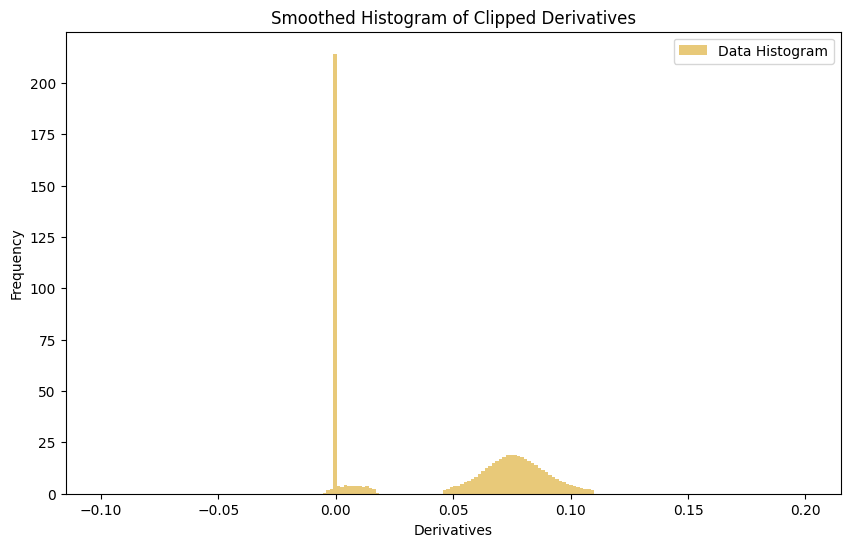

means:  [0.0011917  0.07641322]
std_devs:  [0.00359215 0.01321882]
weights:  [0.385763 0.614237]


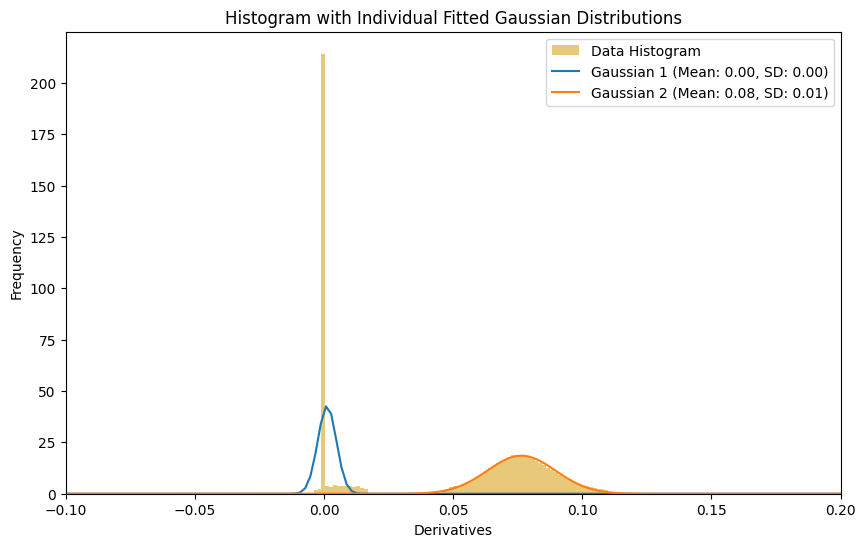

Returning means and standard deviations
Mean1: 0.001191699774996032 Stddev1: 0.0035921534194437313
Mean2: 0.0764132210447513 Stddev2: 0.013218819492825358
Classify and colour version 2
Red mean: 0.001191699774996032  Red stddev: 0.0035921534194437313
Green mean: 0.0764132210447513  Green stddev: 0.013218819492825358
K value: 3
includes undecided


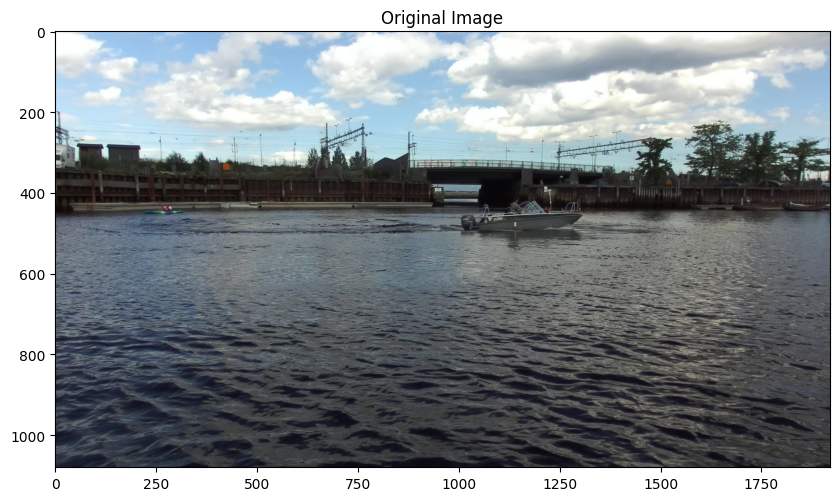

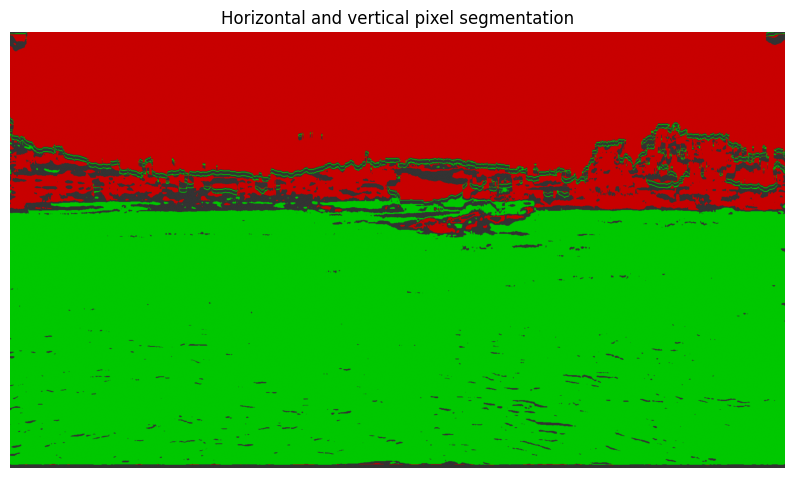

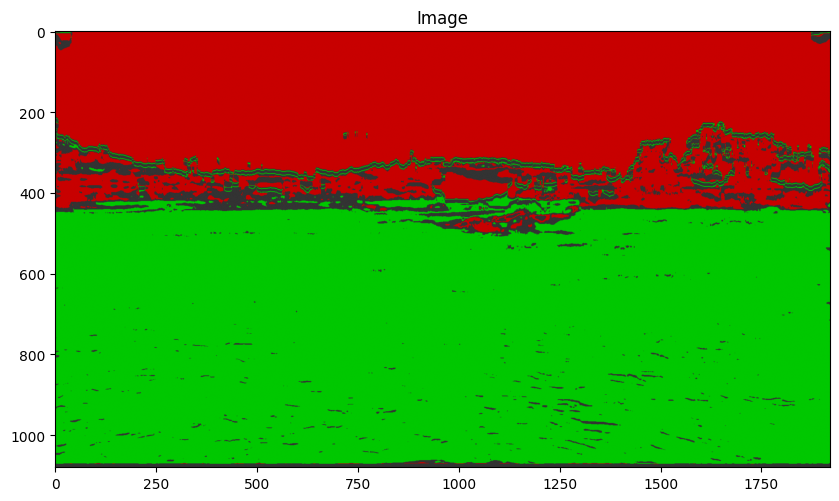

In [10]:
current_image_number = 6
init_segment_all_test_images = False
master_init_pipeline= True

if(master_init_pipeline):
    # ----------------------------------------------------------------------------
    #Full method above
    # ----------------------------------------------------------------------------
    # Clippings can be: "absolute", "regular", "reclip"
    percentage = 0.1
    run_bridge_sequence=True
    run_dock_sequence=True


    if(init_segment_all_test_images):
        if(run_bridge_sequence):
            for i in range(5,9):
                print("Image number: ", i)
                original_image, dI = return_image_to_be_used(i)
                class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)
        
        if(run_dock_sequence):
            for i in range(1,5):
                print("Image number: ", i)
                original_image, dI = return_image_to_be_used(i)
                class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)


    else:
        print("Image number: ", current_image_number)
    original_image, dI = return_image_to_be_used(current_image_number)

    class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)


In [11]:
def convert_labels(matrix, row_indices, old_label, new_label):
    """
    Converts specified rows in the classification matrix from one label to another.

    Parameters:
    - matrix: 2D numpy array representing the classification matrix.
    - row_indices: List or array of row indices to convert.
    - old_label: The label to be replaced.
    - new_label: The label to replace the old label with.

    Returns:
    - Updated matrix with specified rows converted.
    """
    for row_index in row_indices:
        if matrix[row_index] == old_label:
            matrix[row_index] = new_label
    return matrix

In [12]:
vertTestLabel = False

if(vertTestLabel):
    row_index = 1070
    classification_matrix = class_map.copy()
    row = classification_matrix[row_index]
    print(f"Row {row_index}:", row)
    vertCount=0
    for i in range(len(row)):
        lab=row[i]
        if(lab=='vertical'):
            vertCount+=1
            print("TRUE VERT HERE")
        #print(f"Column {i}: {row[i]}")

    print("Vertical count:", vertCount)

### Run and plot on all images

In [13]:
plot_initial_images = False

# For disparity graphing
plot_disparity_graphing = False
testing_image = False

# For histogram plotting
plot_histograms_for_all = False
histi_range = (-0.05,0.15)
y_limit = (0, 80000)    # (0, 80000)
include_y_limit = False


# For initial segmentation
perform_initial_segmentation = True
perform_clustering = False
plot_each_separately = False
perform_reclipping = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    if(plot_disparity_graphing):
        display_columns_on_image(current_original_image, curr_col)
        display_columns_on_image_V2(current_original_image, curr_col)
        disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map, colored_image, _ = initial_segmentation(current_original_image, current_disparity_data, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(current_disparity_data, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(current_disparity_data, plot=True, title="Histogram of the derivatives", range=histi_range)
       


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    if(plot_disparity_graphing):
        
        display_columns_on_image(nærme_image, cols_nærme)
        display_columns_on_image_V2(nærme_image, cols_nærme)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_nærme, colored_image_nærme, derivatives_nærme = initial_segmentation(nærme_image, nærme_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(nærme_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
            print("Shouldnt be here")
        else:
            derivative_and_histogram(nærme_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)

    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    if(plot_disparity_graphing):
        display_columns_on_image(første_image, cols_første)
        display_columns_on_image_V2(første_image, cols_første)
        disparity_graphing(første_disparity, cols_første, display=True, invert=False)
        disparity_graphing(første_disparity, cols_første, display=True, invert=True)
    if(perform_initial_segmentation):  
        class_map_første, colored_image_første, derivatives_første = initial_segmentation(første_image, første_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)

    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    if(plot_disparity_graphing): 
        display_columns_on_image(badering_første_image, cols_badering)
        display_columns_on_image_V2(badering_første_image, cols_badering)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_badering, colored_image_badering, derivatives_badering = initial_segmentation(badering_første_image, badering_første_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(badering_første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(badering_første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)
    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    if(plot_disparity_graphing):
        display_columns_on_image(badering_mann_image, cols_mann)
        display_columns_on_image_V2(badering_mann_image, cols_mann)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)
    if(perform_initial_segmentation):   
        class_map_mann, colored_image_mann, derivatives_mann = initial_segmentation(badering_mann_image, badering_mann_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(badering_mann_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)    
        else:
            derivative_and_histogram(badering_mann_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)



    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_image, cols_båt)
        display_columns_on_image_V2(båt_image, cols_båt)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt, colored_image_båt, derivatives_båt = initial_segmentation(båt_image, båt_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):    
        if(include_y_limit):    
            derivative_and_histogram(båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)




    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    if(plot_disparity_graphing):
        display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
        display_columns_on_image_V2(kajakk_båt_image, cols_båtKajakk)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_kajakk_båt, colored_image_kajakk_båt, derivatives_kajakk_båt = initial_segmentation(kajakk_båt_image, kajakk_båt_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(kajakk_båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(kajakk_båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)





    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_bak_image, cols_båtBak)
        display_columns_on_image_V2(båt_bak_image, cols_båtBak)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt_bak, colored_image_båt_bak, derivatives_båt_bak = initial_segmentation(båt_bak_image, båt_bak_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(båt_bak_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_bak_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)



    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_fram_image, cols_båtFram)
        display_columns_on_image_V2(båt_fram_image, cols_båtFram)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt_fram, colored_image_båt_fram, derivatives_båt_fram = initial_segmentation(båt_fram_image, båt_fram_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(båt_fram_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_fram_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)


    if(perform_initial_segmentation):
        all_class_maps = [class_map_nærme, class_map_første, class_map_badering, class_map_mann, class_map_båt, class_map_kajakk_båt, class_map_båt_bak, class_map_båt_fram]
        all_colored_images = [colored_image_nærme, colored_image_første, colored_image_badering, colored_image_mann, colored_image_båt, colored_image_kajakk_båt, colored_image_båt_bak, colored_image_båt_fram]
        all_derivatives = [derivatives_nærme, derivatives_første, derivatives_badering, derivatives_mann, derivatives_båt, derivatives_kajakk_båt, derivatives_båt_bak, derivatives_båt_fram]
        print("All initial segmentations done")

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image



## Derivatives and testing

### Visualization of kernels and testing

In [14]:
plot_visualization_of_kernels= False
plot_disparity_profiles_after_kernels = False
standard_n = 15

In [15]:

#column_index = disparity_map.shape[1] // 2
if(plot_visualization_of_kernels):
    disparity_map = første_disparity.copy()
    disparity_map = interpolate_each_column(disparity_map)
    column_index = 1140

    column_data_kernels = disparity_map[:, column_index]

    y_values = range(len(column_data_kernels))

    plt.figure(figsize=(10,6))
    plt.plot(column_data_kernels, y_values)
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('Disparity Values Along a Column')
    plt.show()
    
#all_disparity_images = [første_disparity, nærme_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity, badering_første_disparity, badering_mann_disparity]


""" for dI in all_disparity_images:

    print("New iteration")
    clustering = False
    k_value = 3

    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)

    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives")
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives", input_range=(-0.02,0.1))
 """

#Delbar
if(plot_visualization_of_kernels):


    # ----------------------------------------------------------------
    # Binomial
    # ----------------------------------------------------------------
    n = 21  # Length of the kernel

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1

    # Create the binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binom_init = kernel_binomial.copy()
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)


    # Apply the binomial kernel
    response_binomial = np.convolve(signal, kernel_binomial, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_binomial)//2, len(response_binomial)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_binomial, label='Binomial Kernel Response', color='green')
    plt.stem(x_range_response, response_binomial, linefmt='green', markerfmt='go', basefmt=" ", label='Binomial Kernel Response')
    plt.title('Binomial kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()



    # ----------------------------------------------------------------
    # Gaussian
    # ----------------------------------------------------------------

    n = 21  # Length of the kernel

    m_mult = 3

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1



    #
    # Create the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    x = np.linspace(-m_mult*sigma, m_mult*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()


    # Apply the binomial kernel
    response_gaussian = np.convolve(signal, kernel_gaussian, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_gaussian)//2, len(response_gaussian)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_gaussian, label='Gaussian Kernel Response', color='green')
    plt.stem(x_range_response, response_gaussian, linefmt='green', markerfmt='go', basefmt=" ", label='Gaussian Kernel Response')
    plt.title('Gaussian kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()


    # ----------------------------------------------------------------
    # Uniform
    # ----------------------------------------------------------------
    n = 15  # Length of the kernel

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1

    #n = 15  # Size of the kernel, as Vipul used in his thesis 5
    n = standard_n
    kernel_k = np.ones(n) / n  # Kernel for averaging
    big_n = 50
    kernel_k_big = np.ones(big_n) / big_n
    small_n = 2 
    kernel_k_small = np.ones(small_n) / small_n



    # Apply the rectangular kernel
    response_uniform = np.convolve(signal, kernel_k, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_uniform)//2, len(response_uniform)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_uniform, label='Uniform Kernel Response', color='green')
    plt.stem(x_range_response, response_uniform, linefmt='green', markerfmt='go', basefmt=" ", label='Uniform Kernel Response')
    plt.title('Uniform kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()



In [16]:
#Test kan slettes
#plot_visualization_of_kernels=True
if(plot_visualization_of_kernels):
    print("Kernel Binomial init")
    #print(kernel_binom_init)
    n = 15

    test = np.array([binom(n-1, k) for k in range(n)])

    for i in test:
        print(int(i))


In [17]:
plot_visualization_of_kernels=True
if(plot_visualization_of_kernels):
    print("Kernel Binomial init")
    #print(kernel_binom_init)
    for i in range (1, 15):
        n = i

        test = np.array([binom(n-1, k) for k in range(n)])

        
        print(test)


Kernel Binomial init
[1.]
[1. 1.]
[1. 2. 1.]
[1. 3. 3. 1.]
[1. 4. 6. 4. 1.]
[ 1.  5. 10. 10.  5.  1.]
[ 1.  6. 15. 20. 15.  6.  1.]
[ 1.  7. 21. 35. 35. 21.  7.  1.]
[ 1.  8. 28. 56. 70. 56. 28.  8.  1.]
[  1.   9.  36.  84. 126. 126.  84.  36.   9.   1.]
[  1.  10.  45. 120. 210. 252. 210. 120.  45.  10.   1.]
[  1.  11.  55. 165. 330. 462. 462. 330. 165.  55.  11.   1.]
[  1.  12.  66. 220. 495. 792. 924. 792. 495. 220.  66.  12.   1.]
[1.000e+00 1.300e+01 7.800e+01 2.860e+02 7.150e+02 1.287e+03 1.716e+03
 1.716e+03 1.287e+03 7.150e+02 2.860e+02 7.800e+01 1.300e+01 1.000e+00]


In [18]:

if(plot_disparity_profiles_after_kernels):

    # Create a sample 1D signal
    #signal = np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.2, 100)
    #disparity_profile_første = np.copy(signal)  # For demonstration, using the sample signal as disparity profile

    disparity_profile_første = column_data_kernels

    # Define the uniform kernel
    n = standard_n  # Size of the kernel
    n = 15
    kernel_uniform = np.ones(n) / n

    n=25
    # Define the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    m = 5
    x = np.linspace(-m*sigma, m*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)



    # Padding function to repeat edge values
    def pad_with_edge_values(signal, pad_width):
        return np.pad(signal, pad_width, mode='edge')

    def low_pass_convolve_single_profile(disparity_profile, kernel, n=5 ):
        print("Length of disparity profile:", len(disparity_profile))
        # Pad the signal with edge values
        pad_width = n // 2
        padded_disparity_profile = pad_with_edge_values(disparity_profile, pad_width)

        print("Length of padded disparity profile:", len(padded_disparity_profile))

        # Apply the kernels to the padded signal using convolution
        filtered_disparity_profile = np.convolve(padded_disparity_profile, kernel, mode='valid')

        print("Length of filtered disparity profile",len(filtered_disparity_profile))

        return filtered_disparity_profile


    print("Length of disparity profile:", len(disparity_profile_første))
    # Pad the signal with edge values
    pad_width = n // 2
    padded_disparity_profile = pad_with_edge_values(disparity_profile_første, pad_width)

    print("Length of padded disparity profile:", len(padded_disparity_profile))

    # Apply the kernels to the padded signal using convolution
    smoothed_signal_disparity_profile_uniform = np.convolve(padded_disparity_profile, kernel_uniform, mode='valid')
    smoothed_signal_disparity_profile_gaussian = np.convolve(padded_disparity_profile, kernel_gaussian, mode='valid')
    #smoothed_signal_disparity_profile_binomial = np.convolve(padded_disparity_profile, kernel_binomial, mode='valid')
    smoothed_signal_disparity_profile_binomial = low_pass_convolve_single_profile(disparity_profile_første, kernel_binomial, n=5)


    print("Length smoothed signal",len(smoothed_signal_disparity_profile_binomial))

    print("Disp profile", len(disparity_profile_første))
    print("Smoothed signal uniform", smoothed_signal_disparity_profile_uniform)
    print("Smoothed signal gaussian", smoothed_signal_disparity_profile_gaussian)
    print("Smoothed signal binomial", smoothed_signal_disparity_profile_binomial)

    # Plotting the original and smoothed signals
    plt.figure(figsize=(12, 6))
    plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_uniform, label='Smoothed Signal with Uniform Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, label='Smoothed Signal with Gaussian Kernel', color='green', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, label='Smoothed Signal with Binomial Kernel', color='blue', alpha=0.7)
    plt.title('Effect of Different Kernels on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    #y_values = range(len(smoothed_signal_disparity_profile_too_small))

    # Plot the original and smoothed signals



    #y_values = range(len(smoothed_signal_disparity_profile_gaussian[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_gaussian))



    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_gaussian[0:1078], y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.title('Effect of gaussian Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


    #y_values = range(len(smoothed_signal_disparity_profile_binomial[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_binomial))


    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_binomial[0:1078], y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.title('Effect of Binomial Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




### Plotting of Derivatives

Requires kernels to be run

In [19]:

plot_derivatives = False
# 1 = Nærme
# 2 = Første
# 3 = Badering 
# 4 = Mann
# 5 = Båt
# 6 = Kajakk
# 7 = Båt bak
# 8 = Båt fram
image_index =3


if(plot_derivatives):

    if(image_index == 1):
        img = nærme_image
        disp = nærme_disparity.copy()
        corresponding_image_col = 730
        #corresponding_image_col = 1215
    elif(image_index == 2):
        img = første_image
        disp = første_disparity.copy()
        #corresponding_image_col = 550
        corresponding_image_col = 1140
    elif(image_index == 3):
        img = badering_første_image
        disp = badering_første_disparity.copy()
        corresponding_image_col = 250  
        #corresponding_image_col = 1050
    elif(image_index == 4):
        img = badering_mann_image
        disp = badering_mann_disparity.copy()
        corresponding_image_col = 620
        #corresponding_image_col = 1100
    elif(image_index == 5):
        img = båt_image
        disp = båt_disparity.copy()
        #corresponding_image_col = 585
        corresponding_image_col = 800
    elif(image_index == 6):
        img = kajakk_båt_image
        disp = kajakk_båt_disparity.copy()
        corresponding_image_col = 280
        #corresponding_image_col = 1030
    elif(image_index == 7):
        img = båt_bak_image
        disp = båt_bak_disparity.copy()
        corresponding_image_col = 1100
        #corresponding_image_col = 1250
    elif(image_index == 8):
        img = båt_fram_image
        disp = båt_fram_disparity.copy()
        corresponding_image_col = 500
        #corresponding_image_col = 600
    else:
        img = første_image
        disp = første_disparity.copy()
        corresponding_image_col = 1140


    # Kernel definitions
    # Define the uniform kernel
    n = standard_n  # Size of the kernel
    n = 15
    kernel_uniform = np.ones(n) / n

    big_n = 50
    kernel_k_big = np.ones(big_n) / big_n
    small_n = 2 
    kernel_k_small = np.ones(small_n) / small_n


    n=25
    # Define the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    m = 5
    x = np.linspace(-m*sigma, m*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)



In [20]:

smoothen = True
show_og = False
only_binom = True
print_hist = False

if(plot_derivatives):

    dI = første_disparity.copy()
    

    interpolate_each_column(dI)

    OG_df = dI.copy()
    if(smoothen):
        print("Low-pass filter")
        # This is manually doing the above cell
        # Apply the low-pass filter to each column
        height, width = dI.shape
        df = np.zeros_like(dI)  # Low-pass filtered disparity image
        gaussian_df = np.zeros_like(dI) 
        k_df = np.zeros_like(dI) 
        binomial_df = np.zeros_like(dI)
        k_big_df = np.zeros_like(dI)
        k_small_df = np.zeros_like(dI)
        for x in range(width):
            #df[:, x] = low_pass_filter(dI[:, x], K=kernel)
            gaussian_df[:, x] = low_pass_filter(dI[:, x], K=kernel_gaussian, padding=False)
            binomial_df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial, padding=False)
            k_df[:, x] = low_pass_filter(dI[:, x], K=kernel_uniform, padding=False)
            k_big_df[:, x] = low_pass_filter(dI[:, x], K=kernel_k_big, padding=False)
            k_small_df[:, x] = low_pass_filter(dI[:, x], K=kernel_k_small, padding=False)
    else:
        print("proceeds without smoothing the disparity data")

   
    # Versjon 2 bruker np.diff 
    # Computing the derivative of each column
    df_derivative_no_smoothing = take_derivative_diff(OG_df)
    df_derivative_no_smoothing_sobel_norm = take_derivative_sobel(OG_df, normalize=True)
    df_derivative_no_smoothing_sobel = take_derivative_sobel(OG_df, normalize=False)


    rang = 1070
    first = 10

    # Første
    #col = 1140

    col = corresponding_image_col



    plotting_OG = df_derivative_no_smoothing[first:rang, col]


    num_bins = 120

    if(show_og):
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plotting_OG)
        plt.title('Derivative Values at Column Index ' +str(col) +' without low-pass filtering')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Derivative Value')
        plt.grid(True)
        plt.show()

       
        if(print_hist):
            OG_hist = df_derivative_no_smoothing[:, col]
            OG_full_hist = df_derivative_no_smoothing.flatten()

            plt.figure(figsize=(10, 6))
            plt.hist(OG_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.6)
            plt.title('Derivative Values at Column Index ' +str(col) +' without low-pass filtering')
            plt.xlabel('Derivatives')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()


    if(smoothen):
        df = binomial_df.copy()
        # Versjon 2 bruker np.diff 
        # Computing the derivative of each column
        df_derivative = np.diff(df, axis=0)
        # Padding to handle size difference after np.diff
        df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')
        #første_df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge') 



        df_derivative_gaussian = np.diff(gaussian_df, axis=0)
        df_derivative_gaussian = np.pad(df_derivative_gaussian, ((0, 1), (0, 0)), mode='edge')

        df_derivative_k = np.diff(k_df, axis=0)
        df_derivative_k = np.pad(df_derivative_k, ((0, 1), (0, 0)), mode='edge')

        df_derivative_binomial = np.diff(binomial_df, axis=0)
        df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

        # ----------------------------------------------------------------
        # Gaussian kernel
        # ----------------------------------------------------------------

        if(not only_binom):
            plotting_gaussian = df_derivative_gaussian[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_gaussian)
            plt.title('Derivative Values at Column Index ' +str(col) +' with gaussian low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()


            if(print_hist):
                # Hist
                gaussian_hist = df_derivative_gaussian[:, col]
                gaussian_full_hist = df_derivative_gaussian.flatten()
                plt.figure(figsize=(10, 6))
                plt.hist(gaussian_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with gaussian low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()

            # ----------------------------------------------------------------
            # Uniform kernel
            # ----------------------------------------------------------------

            plotting_k = df_derivative_k[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                k_hist = df_derivative_k[:, col]
                k_full_hist = df_derivative_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()


            df_derivative_big_k = np.diff(k_big_df, axis=0)
            df_derivative_big_k = np.pad(df_derivative_big_k, ((0, 1), (0, 0)), mode='edge')

            df_derivative_small_k = np.diff(k_small_df, axis=0)
            df_derivative_small_k = np.pad(df_derivative_small_k, ((0, 1), (0, 0)), mode='edge')

            # ----------------------------------------------------------------
            # Big k-kernel

            plotting_big_k = df_derivative_big_k[first:rang-20, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_big_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with big k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                big_k_hist = df_derivative_big_k[:, col]
                big_k_full_hist = df_derivative_big_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(big_k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with big k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()

            # ----------------------------------------------------------------
            # Small k-kernel

            plotting_small_k = df_derivative_small_k[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_small_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with small k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                small_k_hist = df_derivative_small_k[:, col]
                small_k_full_hist = df_derivative_small_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(small_k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with small k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()


        # ----------------------------------------------------------------
        # Binomial kernel
        # ----------------------------------------------------------------

        print((df_derivative[:,col]))

        plotting_binomial = df_derivative_binomial[first:rang, col]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plotting_binomial)
        plt.title('Derivative Values at Column Index ' +str(col) +' with a binomial kernel low-pass filter')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Derivative Value')
        plt.grid(True)
        plt.show()

        if(print_hist):
            # Hist 
            binomial_hist = df_derivative_binomial[:, col]
            binomial_full_hist = df_derivative_binomial.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(binomial_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
            plt.title('Derivative Values at Column Index ' +str(col) +' with a binomial kernel low-pass filter')
            plt.xlabel('Derivatives')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        
        display_columns_on_image(img, [col])


        print(df_derivative_no_smoothing[:,col])



        plot_data_regular_12_04 = df[first:rang, col]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plot_data_regular_12_04)
        plt.title('Disparity profile at Column Index ' +str(col) +'')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Disparity Value')
        plt.grid(True)
        plt.show()

        


In [21]:
if(plot_derivatives):
    flattened_no_smooth = flatten_and_plot_histogram(df_derivative_no_smoothing, plot=True, input_bins=400, title="Histogram of the derivatives without smoothing")
    flatten_no_smooth_sobel_norm = flatten_and_plot_histogram(df_derivative_no_smoothing_sobel_norm, plot=True, input_bins=400, title="Histogram of the derivatives without smoothing sobel norm")
    flatten_no_smooth_sobel = flatten_and_plot_histogram(df_derivative_no_smoothing_sobel, plot=True, input_bins=300, title="Histogram of the derivatives without smoothing sobel")


    flattened_binomial = flatten_and_plot_histogram(df_derivative_binomial, plot=True, input_bins=400, title="Histogram of the derivatives with binomial kernel")



In [22]:
plot_full_image_histogram = False
num_bins = 400

if(plot_full_image_histogram):


    dI_test = første_disparity.copy()
    height, width = dI_test.shape

    interpolate_each_column(dI_test)


    binomial_df = np.zeros_like(dI_test)

    for x in range(width):
        #df[:, x] = low_pass_filter(dI[:, x], K=kernel)
        binomial_df[:, x] = low_pass_filter(dI_test[:, x], K=kernel_binomial, padding=False)

    df_derivative_binomial = np.diff(binomial_df, axis=0)
    df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

    #df_derivative_binomial.flatten()



In [23]:
if(plot_full_image_histogram):
    
    sin_zero = flatten_and_plot_histogram_remove_zero(df_derivative_binomial, plot=True, input_range=(-0.10,0.2), input_bins=num_bins, title="Histogram of the derivatives with binomial kernel")




In [24]:
if(plot_full_image_histogram):

    for i in range(1,9):
        og_img, dI_test = return_image_to_be_used(i)
        height, width = dI_test.shape

        interpolate_each_column(dI_test)


        binomial_df = np.zeros_like(dI_test)

        for x in range(width):
            #df[:, x] = low_pass_filter(dI[:, x], K=kernel)
            binomial_df[:, x] = low_pass_filter(dI_test[:, x], K=kernel_binomial, padding=False)

        df_derivative_binomial = np.diff(binomial_df, axis=0)
        df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

        sin_zero = flatten_and_plot_histogram_remove_zero(df_derivative_binomial, plot=True, input_range=(-0.10,0.2), input_bins=num_bins, title="Histogram of the derivatives with binomial kernel")


#### Testing with the top of object derivative jump

##### Method definitions

In [25]:
def return_binomial_derivatives(image_index_testing):
    if(image_index_testing == 1):
        img = nærme_image
        disp = nærme_disparity.copy()
    elif(image_index_testing == 2):
        img = første_image
        disp = første_disparity.copy()
    elif(image_index_testing == 3):
        img = badering_første_image
        disp = badering_første_disparity.copy()
    elif(image_index_testing == 4):
        img = badering_mann_image
        disp = badering_mann_disparity.copy()
    elif(image_index_testing == 5):
        img = båt_image
        disp = båt_disparity.copy()
    elif(image_index_testing == 6):
        img = kajakk_båt_image
        disp = kajakk_båt_disparity.copy()
    elif(image_index_testing == 7):
        img = båt_bak_image
        disp = båt_bak_disparity.copy()
    elif(image_index_testing == 8):
        img = båt_fram_image
        disp = båt_fram_disparity.copy()
    else:
        img = første_image
        disp = første_disparity.copy()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)

    dI = disp.copy()
    

    interpolate_each_column(dI)
    height, width = dI.shape
    binomial_df = np.zeros_like(dI)
    for x in range(width):
        binomial_df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial, padding=False)
    df_derivative_binomial = np.diff(binomial_df, axis=0)
    df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

    return df_derivative_binomial, img

# Define a function to detect jumps above a threshold
def detect_jumps(derivative, threshold=1, step_range=1):
    jump_image = np.zeros_like(derivative)
    for i in range(derivative.shape[0] - step_range):
        diff = np.abs(derivative[i + step_range] - derivative[i])
        jump_image[i + step_range] = diff > threshold
    return jump_image



def derivative_jump_testing_method(image_index=1,threshold=0.03, step_range=1, plot_original=True):

    df_der_binom, img = return_binomial_derivatives(image_index)

    # Detect jumps in the filtered derivative profiles
    jump_image = detect_jumps(df_der_binom, threshold, step_range=step_range)

    # Create a binary image where jumps are black and other pixels are white
    binary_jump_image = (jump_image * 255).astype(np.uint8)


    #display_disp_image(binary_jump_image, title='Jump Detection Image')

    
    plt.figure(figsize=(10, 6))
    plt.plot()
    plt.title('Jump Detection Image')
    plt.imshow(binary_jump_image, cmap='gray')
    if(plot_original):
        display_disp_image(img)



##### Testing 

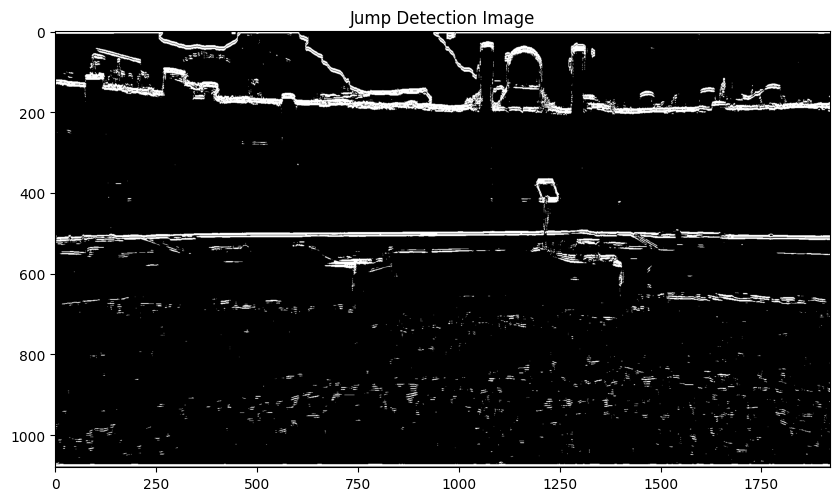

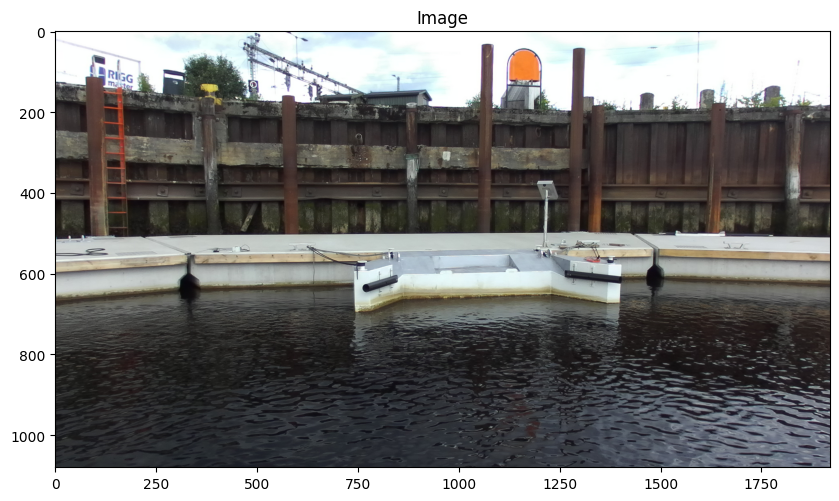

In [26]:
# Empirically determine the threshold (this might require some tuning)
image_index = 1
threshold = 0.02# Threshold for detecting jumps good threshold empirically tested
step_range=1

run_the_loop=False
range_to_loop = range(1,9)
plot_og_image=True




if(run_the_loop):
    for i in range_to_loop:
        derivative_jump_testing_method(i,threshold, step_range, plot_original=plot_og_image)
else:
    derivative_jump_testing_method(image_index,threshold, step_range)

# Del 1,5 GMM 

## Plotting av histogrammer og Gaussian mixtures 

#### Fitting GMM


In [27]:
GMM_TESTING_BOOLEAN = False
img = båt_fram_image
disp = båt_fram_disparity

if(GMM_TESTING_BOOLEAN):
    

    surface_split_disparity_image = disp.copy()
    kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, surface_split_disparity_image, clustering_bool=True, plot_figures=False)

    flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")

    min_clip=-0.3    
    max_clip=0.5
    num_curves=2
    num_bins=200
    p=0.05
    k=2
    plot=True
    version=1

    print("Thresholds Clipping verstion")

    regular_clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = regular_clipped_derivatives[(regular_clipped_derivatives > min_clip) & (regular_clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)
    max_frequency = np.max(hist_values)
    threshold = p * max_frequency
    if(plot):
        print("Maximum frequency in the histogram:", max_frequency)
        print(f"Threshold ({p*100}% of max frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)

    """ if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')

        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show() """

    # Find the indices of non-zero bins in the smoothed histogram 
    non_zero_indices = np.nonzero(smooth_hist_values)[0]

    # Extract the minimum and maximum value along the value axis
    min_value_range = bin_edges[non_zero_indices[0]]
    max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

    reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  


    ##########################################
    # Regular
    ##########################################
    print("Fitting regular")
    gmm_regular = GaussianMixture(n_components=2, random_state=0)
    gmm_regular.fit(regular_clipped_derivatives.reshape(-1, 1))

    means_regular = gmm_regular.means_.flatten()
    covariances_regular = gmm_regular.covariances_.flatten()
    weights_regular = gmm_regular.weights_.flatten()

    ##########################################
    # Clipped
    ##########################################
    print("Fitting clipped")
    gmm_clipped = GaussianMixture(n_components=2, random_state=0)
    gmm_clipped.fit(clipped_derivatives.reshape(-1, 1))

    means_clipped = gmm_clipped.means_.flatten()
    covariances_clipped = gmm_clipped.covariances_.flatten()
    weights_clipped = gmm_clipped.weights_.flatten()


    ##########################################
    # triple
    ##########################################
    print("Fitting triple")
    gmm_triple = GaussianMixture(n_components=3, random_state=0)
    gmm_triple.fit(clipped_derivatives.reshape(-1, 1))

    means_triple = gmm_triple.means_.flatten()
    covariances_triple = gmm_triple.covariances_.flatten()
    weights_triple = gmm_triple.weights_.flatten()

    ##########################################
    # Four
    ##########################################
    print("Fitting four")
    gmm_four = GaussianMixture(n_components=4, random_state=0)
    gmm_four.fit(clipped_derivatives.reshape(-1, 1))

    means_four = gmm_four.means_.flatten()
    covariances_four = gmm_four.covariances_.flatten()
    weights_four = gmm_four.weights_.flatten()

    ##########################################
    # Five
    ##########################################
    print("Fitting five")
    gmm_five = GaussianMixture(n_components=5, random_state=0)
    gmm_five.fit(clipped_derivatives.reshape(-1, 1))

    means_five = gmm_five.means_.flatten()
    covariances_five = gmm_five.covariances_.flatten()
    weights_five = gmm_five.weights_.flatten()

    ##########################################
    # Six
    ##########################################
    print("Fitting six")
    gmm_six = GaussianMixture(n_components=6, random_state=0)
    gmm_six.fit(clipped_derivatives.reshape(-1, 1))

    means_six = gmm_six.means_.flatten()
    covariances_six = gmm_six.covariances_.flatten()
    weights_six = gmm_six.weights_.flatten()


    ##########################################
    # Reclipped
    ##########################################
    print("Fitting reclipped")
    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm_reclipped = GaussianMixture(n_components=2, random_state=0)
    gmm_reclipped.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means_reclipped = gmm_reclipped.means_.flatten()
    covariances_reclipped = gmm_reclipped.covariances_.flatten()
    weights_reclipped = gmm_reclipped.weights_.flatten()

    ##########################################
    # Reclipped triple
    ##########################################
    print("Fitting reclipped triple")
    gmm_reclipped_triple = GaussianMixture(n_components=3, random_state=0)
    gmm_reclipped_triple.fit(reclipped_derivatives.reshape(-1, 1))

    means_reclipped_triple = gmm_reclipped_triple.means_.flatten()
    covariances_reclipped_triple = gmm_reclipped_triple.covariances_.flatten()
    weights_reclipped_triple = gmm_reclipped_triple.weights_.flatten()

    ##########################################
    # Reclipped four
    ##########################################
    print("Fitting reclipped four")
    gmm_reclipped_four = GaussianMixture(n_components=4, random_state=0)
    gmm_reclipped_four.fit(reclipped_derivatives.reshape(-1, 1))

    means_reclipped_four = gmm_reclipped_four.means_.flatten()
    covariances_reclipped_four = gmm_reclipped_four.covariances_.flatten()
    weights_reclipped_four = gmm_reclipped_four.weights_.flatten()

    print("All done!")

#### Plotting GMM Results

In [28]:
min_clip=-0.05    
max_clip=0.15
max_y = 80
do_xlim = True
do_ylim = True


if(GMM_TESTING_BOOLEAN):
    # Create a range of x values for plotting
    x_values = np.linspace(min_clip, max_clip, 400)
    # New ploting range
    
    display_disp_image(img)

    ##########################################
    #Regular
    ##########################################

    print("Regular 2 curves")
    print("Regular 2 weights: ", weights_regular)
    gaussian_pdfs_regular = [
        weights_regular[i] * norm.pdf(x_values, means_regular[i], np.sqrt(covariances_regular[i]))
        for i in range(2)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(regular_clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_regular):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_regular[i]:.2f}, SD: {np.sqrt(covariances_regular[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Clipped
    ##########################################

    print("Clipped edges 2 curves")
    print("Clipped 2 weights: ", weights_clipped)
    weights_fabricated = [weights_clipped[0], 0.2]
    gaussian_pdfs_clipped = [
        #weights_fabricated[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        weights_clipped[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        for i in range(2)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_clipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_clipped[i]:.2f}, SD: {np.sqrt(covariances_clipped[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Triple
    ##########################################
    print("Clipped edges 3 curves")
    print("Clipped 3 weights: ", weights_triple)
    gaussian_pdfs_triple = [
        weights_triple[i] * norm.pdf(x_values, means_triple[i], np.sqrt(covariances_triple[i]))
        for i in range(3)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_triple):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_triple[i]:.2f}, SD: {np.sqrt(covariances_triple[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Four
    ##########################################
    print("Clipped edges 4 curves")
    print("Clipped 4 weights: ", weights_four)
    gaussian_pdfs_four = [
        weights_four[i] * norm.pdf(x_values, means_four[i], np.sqrt(covariances_four[i]))
        for i in range(4)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_four):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_four[i]:.2f}, SD: {np.sqrt(covariances_four[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Five
    ##########################################
    print("Clipped edges 5 curves")
    print("Clipped 5 weights: ", weights_five)
    gaussian_pdfs_five = [
        weights_five[i] * norm.pdf(x_values, means_five[i], np.sqrt(covariances_five[i]))
        for i in range(5)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_five):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_five[i]:.2f}, SD: {np.sqrt(covariances_five[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Six
    ##########################################
    print("Clipped edges 6 curves")
    print("Clipped 6 weights: ", weights_six)
    gaussian_pdfs_six = [
        weights_six[i] * norm.pdf(x_values, means_six[i], np.sqrt(covariances_six[i]))
        for i in range(6)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_six):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_six[i]:.2f}, SD: {np.sqrt(covariances_six[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()


    ##########################################
    # Reclipped
    ##########################################

    print("Reclipped 2 curves")
    print("Reclipped 2 weights: ", weights_reclipped)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped = [
        weights_reclipped[i] * norm.pdf(x_values, means_reclipped[i], np.sqrt(covariances_reclipped[i]))
        for i in range(2)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped[i]:.2f}, SD: {np.sqrt(covariances_reclipped[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Reclipped Triple
    ##########################################

    print("Reclipped 3 curves")
    print("Reclipped 3 weights: ", weights_reclipped_triple)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped_triple = [
        weights_reclipped_triple[i] * norm.pdf(x_values, means_reclipped_triple[i], np.sqrt(covariances_reclipped_triple[i]))
        for i in range(3)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped_triple):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_triple[i]:.2f}, SD: {np.sqrt(covariances_reclipped_triple[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Reclipped Four
    ##########################################
    print("Reclipped 4 curves")
    print("Reclipped 4 weights: ", weights_reclipped_four)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped_four = [
        weights_reclipped_four[i] * norm.pdf(x_values, means_reclipped_four[i], np.sqrt(covariances_reclipped_four[i]))
        for i in range(4)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped_four):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_four[i]:.2f}, SD: {np.sqrt(covariances_reclipped_four[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()



# Del 2 Subdividing surfaces

## Preprocessing: Dividing the points into lists

In [29]:
# Teleport top

def split_into_lists(surface_splitting_disparity_image, classification_map, df_derivative, get_columns=True, print_numbers=True):
    if(print_numbers):
        print("Splitting into lists")
        vertCount = 0
        horCount = 0
        noneCount = 0

    # Verticals
    vertical_Derivative_List = []
    vertical_Disp_List = []
    vertical_Obj_List = []

    divided_vertical_obj_list = []


    #Horizonals
    horizontal_Derivative_List = []
    horizontal_Disp_List = []
    horizontal_Obj_List = []

    divided_horizontal_obj_list = []


    # Full Image

    all_objects_list = []
    divided_all_objects_list = []

    if(get_columns):
        for j in range(classification_map.shape[1]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            single_col_all_obj_list = []
            for i in range(classification_map.shape[0]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    der_val = df_derivative[i, j]
                    vertical_Derivative_List.append(der_val)
                    appendObjectVert = [surface_splitting_disparity_image[i, j], der_val, i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1

                der_val = df_derivative[i, j]
                appendAllObject = [surface_splitting_disparity_image[i, j], der_val, i, j, current_local_value]

                all_objects_list.append(appendAllObject)
                single_col_all_obj_list.append(appendAllObject)


            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)
            divided_all_objects_list.append(single_col_all_obj_list)
    else:
        for i in range(classification_map.shape[0]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for j in range(classification_map.shape[1]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]

                    appendObjectVert = [surface_splitting_disparity_image[i, j], der_val, i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    if(print_numbers):
        print("verticals: ", vertCount)
        print("Horizontals: ", horCount)
        print("Unknown: ", noneCount)
        print("[Disparity Value, Derivative Value, V index, U index, Label]")
    
    verticals = (vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list)
    horizontals =(horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list)
    all_objects = (all_objects_list, divided_all_objects_list)

    return verticals, horizontals, all_objects

def single_column_disparities(col_object_list, i):

    current_col = col_object_list[i]

    column_disparities = []
    for obj in current_col:
        disp = obj[0]
        column_disparities.append(disp)

    return column_disparities


def create_divided_vertical_disps(col_object_list):
    all_vertical_disps = []

    for col in range(len(col_object_list)):
        current_col = single_column_disparities(col_object_list, col)
        all_vertical_disps.append(current_col)

    return all_vertical_disps

def display_histogram(data, input_bins=200, input_range=(0,60)):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=input_bins,  range=input_range, alpha=0.6, label='Histogram', density=True)
    plt.title('Histogram of Disparity Values of Vertical labeled points')
    plt.xlabel('Disparity Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

from scipy.signal import find_peaks

def plot_histogram_with_peaks(data, min_prominence=0.01, min_distance=1, bins=200, auto_range=(-1,60), plot=True):

    # Ensure data is cleaned
    #data = np.array(data)
    #data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.plot(bin_centers, hist, label='Histogram Line')
        plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
        plt.title('Cluster Data and Detected Modes')
        plt.xlabel('Disparity')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if(plot):
        print("Detected modes at:", peak_values)
    return peak_values


# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
perform = False

if(perform):
    surface_split_disparity_image = dI

    verticals, horizontals, all_objects = split_into_lists(surface_split_disparity_image, class_map)

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals


    print(len(vertical_Obj_List))
    print(len(horizontal_Obj_List))

    # i = column
    i = 730
    print("Horizontals: ", len(divided_horizontal_obj_list[i]))
    print("Verticals: ",len(divided_vertical_obj_list[i]))

    print("Disparity Value, Derivative Value, V index(row), U index)column), Label")
    print(divided_horizontal_obj_list[i][0])



    vert_col_disp_i = single_column_disparities(divided_vertical_obj_list, i)
    hor_col_disp_i = single_column_disparities(divided_horizontal_obj_list, i)


    all_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    print("Length:  ", len(all_vertical_disps))
    print(all_vertical_disps[i])

    #for i in hor_col_disp_i:
    #    print(i)

def scatter_all_points(object_list, BEV=False, upDown=False, inverted=False):
    # Extract disparity (d) and row (v) values
    d_values = [obj[0] for obj in object_list]


    if(BEV):
        v_values = [obj[3] for obj in object_list]
    else:
        v_values = [obj[2] for obj in object_list]

    if(upDown):
        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter( d_values,v_values, color='blue', marker='o')
        plt.gca().invert_yaxis()
        # Labeling the plot
        plt.ylabel('Row Value (v)')
        plt.xlabel('Disparity Value (d)')
        plt.title('Scatter Plot of vertical points')
    else:
        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(v_values, d_values, color='blue', marker='o')
        if(inverted):
            plt.gca().invert_yaxis()
        # Labeling the plot
        plt.xlabel('Row Value (v)')
        plt.ylabel('Disparity Value (d)')
        plt.title('Scatter Plot of vertical points')

    # Display the plot
    plt.show()


def perform_scatters_plots(num_bins=400, image_indices=[0,1,2,3,4,5,6,7], inverted_BEV=False, upDown=True, plot_original_image=False, show_segmented_image=False):


    for i in image_indices:
        current_image_number = i

        print("Image number: ", current_image_number)
        original_image, dI = return_image_to_be_used(current_image_number+1)



        #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

        # all_class_maps, all_colored_images, all_splitting_derivatives

        verticals, horizontals, _ = split_into_lists(dI, all_class_maps[current_image_number], all_derivatives[current_image_number])

        vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals

        if(plot_original_image):
            display_disp_image(original_image)
        if(show_segmented_image):
            display_disp_image(all_colored_images[current_image_number])
        scatter_all_points(vertical_Obj_List, upDown=upDown)
        scatter_all_points(vertical_Obj_List, BEV=True, inverted=inverted_BEV)


def fetch_all_lists_for_image(image_number=1):

    original_image, dI = return_image_to_be_used(image_number)
    index_number= image_number -1

    if all_class_maps == None: 
        current_class_map, current_colored_image, current_derivatives = initial_segmentation(original_image, dI)
    else:
        current_class_map = all_class_maps[index_number]
        current_derivatives = all_derivatives[index_number]
        current_colored_image = all_colored_images[index_number]
    
    

    verticals, horizontals, all_objects = split_into_lists(dI, current_class_map, current_derivatives)

    return original_image, dI, current_class_map, current_derivatives, current_colored_image, verticals, horizontals, all_objects



#### Scatterplotting 

In [30]:

bool_perform_scatter_plot = False

if(bool_perform_scatter_plot):
    perform_scatters_plots(num_bins=400, image_indices=[0], inverted_BEV=True, upDown=True, plot_original_image=True, show_segmented_image=True)


In [31]:
if(bool_perform_scatter_plot):
    perform_scatters_plots(num_bins=400, image_indices=[0,1,2,3,4,5,6,7], inverted_BEV=True, plot_original_image=True, show_segmented_image=True)

In [32]:
""" num_bins = 200
number_of_peaks_vertical = []
all_peaks = []
min_dist = 1
for i in range(len(all_vertical_disps)):
    peaks = plot_histogram_with_peaks(all_vertical_disps[i], bins=num_bins, min_prominence=0.01, min_distance=min_dist,plot =False)
    number_of_peaks_vertical.append(len(peaks))
    for peak in peaks:
        all_peaks.append(peak)

    #print("Number of peaks: ",len(peaks))

    #display_histogram(all_vertical_disps[i], input_bins=num_bins)
 
#print(all_peaks)
display_histogram(all_peaks, input_bins=200)
 """


""" max_value = max(number_of_peaks_vertical)


print(max(number_of_peaks_vertical))

# Find the index of the maximum value
max_index = number_of_peaks_vertical.index(max_value)
print(max_index) """

""" #Båt: [585, 800] & 1689068854381001093 & Bridge-sequence \\

index = max_index
target_column = 1215
#target_column = 736

# Extract disparity (d) and row (v) values for the specific row
d_values = [obj[0] for obj in vertical_Obj_List if obj[2] == target_column]
v_values = [obj[1] for obj in vertical_Obj_List if obj[2] == target_column]
u_values = [obj[2] for obj in vertical_Obj_List if obj[2] == target_column]
#divided_vertical_obj_list

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_values,d_values, color='blue', marker='o')

# Labeling the plot
plt.xlabel('Row Value (v)')
plt.ylabel('Disparity Value (d)')
plt.title(f'Scatter Plot of vertical points at Column {target_column}')

# Display the plot
plt.show()

plot_histogram_with_peaks(all_vertical_disps[index], bins=num_bins, min_prominence=0.01, min_distance=min_dist)
display_histogram(all_vertical_disps[index], input_bins=num_bins) """

"""  
#column_index = disparity_map.shape[1] // 2

disparity_map = nærme_disparity.copy()
disparity_map = interpolate_each_column(disparity_map)
column_index = 500

column_data = disparity_map[:, column_index]

y_values = range(len(column_data))

plt.figure(figsize=(10,6))
plt.plot(column_data, y_values)
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.xlabel('Disparity Value')
plt.ylabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()
"""

"  \n#column_index = disparity_map.shape[1] // 2\n\ndisparity_map = nærme_disparity.copy()\ndisparity_map = interpolate_each_column(disparity_map)\ncolumn_index = 500\n\ncolumn_data = disparity_map[:, column_index]\n\ny_values = range(len(column_data))\n\nplt.figure(figsize=(10,6))\nplt.plot(column_data, y_values)\nplt.gca().invert_yaxis()  # Invert y-axis to match image orientation\nplt.xlabel('Disparity Value')\nplt.ylabel('Image v-Axis')\nplt.title('Disparity Values Along a Column')\nplt.show()\n"

## Vertikal segmentering

### Kolonner til bilder

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


### Stripe method definition

In [33]:
# Fint tall for n = 40, totalt 48 stripes

# Stripe method
def histogram_for_n_columns_vertical(divided_vert_disps, n=1):

    striped_vertical_disps = []  
    total_stripes = len(divided_vert_disps) // n
    #print(total_stripes)

    for stripe in range(total_stripes):
        current_stripe = []
        for i in range(n):
            current_index = stripe * n + i
            current_stripe.extend(divided_vert_disps[current_index])
        striped_vertical_disps.append(current_stripe)

    return striped_vertical_disps

def display_strips_on_image(image, strips=[6], n=40, plot=True):
    image = image.copy()
    height, width = image.shape[:2]

    colours=[(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255)]


    for i in range(len(strips)):
        strip = strips[i]
        for j in range(1, n):
            cv2.line(image, ((n*strip)+j, 0), ((n*strip)+j, height), colours[i], 2)
    
    if(plot):
        display_disp_image(image)
    return image

def display_stripping_of_image(image, n=40, plot=True):
    image = image.copy()
    height, width = image.shape[:2]
    stripe_width = width // n

    for i in range(1, n):
        cv2.line(image, (stripe_width * i, 0), (stripe_width * i, height), (50, 200, 0), 2)
    
    if(plot):
        display_disp_image(image)
    return image



In [34]:
bool_test_striping = False

if(bool_test_striping):
    # Display the original image
    display_disp_image(nærme_image)

    # Display the stripes on the image
    _ = display_stripping_of_image(nærme_image, n=40)

    # Display the stripes on the image
    _ = display_strips_on_image(nærme_image, strips=[7, 26], n=40)


### Define image and create lists

In [35]:

# --------------------------------------------------------------------------------------------------------------
# Fetch image (nye)
# --------------------------------------------------------------------------------------------------------------

bool_test_the_early_pipeline = False
current_image_number = 3


if(bool_test_the_early_pipeline):

    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(current_image_number)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)


##### Show full image histogram 

In [36]:
if(bool_test_the_early_pipeline):  
    plt.figure(figsize=(10, 6))
    plt.hist(working_vertical_disp_list, bins=400, range=(-1,55), density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Disparity Values')
    plt.legend()
    plt.show()

In [37]:
#Not defined yet
#plot_and_test_hist_smoothing(working_vertical_disp_list, ns=[7,15,21, 30], bins=400, plot_original=True)


### Column strip methods


In [38]:

if(bool_test_the_early_pipeline):

    #striped_vertical_disps, undivided_striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=20)
    #striped_vertical_disps_old, undivided_striped_vertical_disps = histogram_for_n_columns_vertical_old(divided_vertical_disps, n=40)
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=40)



### Determining the ideal number of clusters:

- Silhouette scoring (Approach 1)
- Histogram smoothing (Approach 2)
- Peak detection
- Elbow method

#### Silhouette Approach

In [39]:
def silhouette_scoring(X, threshold=0.01, threshold_ratio=0.98, version=2, plot=True, max_clusters=11):

    X = np.array(X).reshape(-1, 1)

    # Silhouette Method
    silhouette_scores = []
    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)

    if(plot):
        plt.plot(range(2, max_clusters), silhouette_scores)
        plt.title('Silhouette Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    max_score = max(silhouette_scores)
    print(f'Maximum Silhouette Score: {max_score}')


    selected_number_of_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    for n_clusters, score in enumerate(silhouette_scores, start=2):
        if(version == 1):
            if score >= threshold_ratio * max_score:
                selected_number_of_clusters = n_clusters
                break 
        #print(f'Number of Clusters: {n_clusters}, Score: {score}')
        else:
            if max_score - score < threshold:
                selected_number_of_clusters = n_clusters
                break
            
    return selected_number_of_clusters
    #print(f'Selected Number of Clusters: {selected_number_of_clusters}')


def all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=11):
    all_scores = []
    for i in range(len(striped_vertical_disps)):
        print("Current run: ", i)
        current_strip = striped_vertical_disps[i]
        current_score = silhouette_scoring(current_strip, threshold=threshold, threshold_ratio=threshold_ratio, version=version, plot=plot, max_clusters=max_clusters)
        all_scores.append(current_score)
    return all_scores



##### Testing silhouette

In [40]:
# Metoden tar 27 min å kjøre
perform_silhouette_for_all = False
if(perform_silhouette_for_all):
    all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)
#all_number_clusters = all_silhouette_scores(undivided_striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)


if(perform_silhouette_for_all):
    print("All number of clusters: ", all_number_clusters)

if(perform_silhouette_for_all):
    print(all_number_clusters)




In [41]:

memory_all_num_clusters_n40_båt_fram = [2, 2, 2, 2, 2, 2, 3, 4, 3, 4, 4, 3, 3, 5, 4, 3, 4, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
all_number_clusters = memory_all_num_clusters_n40_båt_fram
print("Length: ",len(memory_all_num_clusters_n40_båt_fram))
#print(all_number_clusters == memory_all_num_clusters_n40_båt_fram)


Length:  48


#### Histogram smoothing approach

##### Definition

In [42]:
# Create the binomial kernel
def create_binom_kernel(n):
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)
    return kernel_binomial

def plot_and_test_hist_smoothing(disp_list, ns=[5,10,15,17,21], bins=200, input_range=(-1,64), plot_original=True, signi_check=True, detect_peaks=False, plot=True):
    hist, bin_edges = np.histogram(disp_list, bins=bins, range=input_range)

    all_peaks_count = []

    if(plot_original):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Histogram of Disparity Data with Binomial Smoothing')
        plt.show()

    for n in ns:
        kernel_binomial_vertical =create_binom_kernel(n)
        
        # Smooth the histogram
        smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

        if(plot):
            plt.figure(figsize=(10, 6))
            plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), align='edge')
            plt.xlabel('Disparity')
            plt.ylabel('Frequency')
            plt.legend()
            plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
            plt.show()

        if(detect_peaks):
            peaks_count = detect_peaks_on_hist_version3(disp_list, bins=bins, smooth=True, n=n, significance_check=signi_check, plot=plot)
            all_peaks_count.append(peaks_count)
    
    return all_peaks_count





def test_hist_smoothing_for_striped_list(striped_list, list_num=0, ns=[5,10,15,17,21], bins=200, plot_original=False, signi_check=True, detect_peaks=False, plot=True):
    all_peaks = []
    if(signi_check):
        print("Performing significance check")
    else:
        print("No significance check")
    for i in range(len(striped_list)):
        print("Current run: ", i)
        current_strip = striped_list[i]
        detected_peaks = plot_and_test_hist_smoothing(current_strip, bins=bins, ns=ns, plot_original=plot_original, signi_check=signi_check, detect_peaks=detect_peaks, plot=plot)
        all_peaks.append(len(detected_peaks[list_num]))
        
    return all_peaks
        

def smooth_hist(disp_list, n=15, bins=200, plot=False):
    hist, bin_edges = np.histogram(disp_list, bins=bins, range=(-1, 64))

    kernel_binomial_vertical =create_binom_kernel(n)
        
    # Smooth the histogram
    smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
        plt.show()

    return smoothed_hist, bin_edges, hist

# --------------------------------------------------------------------------------------------------------------
def detect_peaks_on_hist_original(disp_list, bins=200, min_prominence=0.01, min_distance=1, smooth=True, n=7, plot=True):

    smoothed_hist, bin_edges, hist = smooth_hist(disp_list, bins=bins, n=n)

    if(smooth):
        used_hist = smoothed_hist
    else:
        used_hist = hist

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[peaks], used_hist[peaks], 'ro', label='Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Peaks Detected')
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if(plot):
        print("Detected modes at:", peak_values)
    return peak_values

def detect_peaks_on_hist_version2(disp_list, bins=200, min_prominence=0.01, min_distance=1, min_height_ratio=0.1, min_width=1, n=7, plot=True):
    used_hist, bin_edges, hist = smooth_hist(disp_list, n=n)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance, height=np.max(used_hist)*min_height_ratio, width=min_width)

    if plot:
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[peaks], used_hist[peaks], 'ro', label='Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Peaks Detected')
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if plot:
        print("Detected modes at:", peak_values)
    return peak_values 
LOWER_LIMIT_PEAK_HEIGHT=20
KERNEL_WIDTH_FOR_HIST_SMOOTHING = 7
MINIMUM_PROMINENCE_PEAK_DETECTION = 10
MINIMUM_DISTANCE_PEAK_DETECTION = 3
STRIP_NUMBER = 40
K_VALUE = 3
NUM_BINS = 200

def detect_peaks_on_hist_version3(disp_list, bins=200, min_prominence=MINIMUM_PROMINENCE_PEAK_DETECTION, min_distance=MINIMUM_DISTANCE_PEAK_DETECTION, smooth=True, n=KERNEL_WIDTH_FOR_HIST_SMOOTHING, flatness_threshold=0.90, check_range=3, lower_lim=LOWER_LIMIT_PEAK_HEIGHT,significance_check = True, plot=True):
    smoothed_hist, bin_edges, hist = smooth_hist(disp_list, n=n, bins=bins)

    used_hist = smoothed_hist if smooth else hist

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find initial peaks
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance)

    if significance_check:
        def is_significant_peak(index, lower_limit=lower_lim):
            peak_height = used_hist[index]
            if peak_height < lower_limit:
                return False
            # Check the bins that are `check_range` bins away from the current bin
            neighbors = []
            if index - check_range >= 0:
                neighbors.append(used_hist[index - check_range])
            if index + check_range < len(used_hist):
                neighbors.append(used_hist[index + check_range])
            
            if len(neighbors) < 2:
                return True
            
            # Check if both neighbors are above the threshold
            if all(neighbor >= peak_height * flatness_threshold for neighbor in neighbors):
                return False
            
            return True

        # Filter out peaks that are not significant
        significant_peaks = [peak for peak in peaks if is_significant_peak(peak)]
    else:
        significant_peaks = peaks

    if plot:
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[significant_peaks], used_hist[significant_peaks], 'ro', label='Significant Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Significant Peaks Detected')
        plt.show()

    # Print significant peak bin centers
    significant_peak_values = bin_centers[significant_peaks]
    significant_peak_heights = used_hist[significant_peaks]

    if plot:
        print("Detected significant peaks at:", significant_peak_values)
        print("Peak heights are:", significant_peak_heights)
    return significant_peak_values



# --------------------------------------------------------------------------------------------------------------
""" def detect_peaks_all_stripes(striped_list, bins=200, min_prominence=0.01, min_distance=1, smooth=True, plot=True):
    all_peaks = []
    for i in range(len(striped_list)):
        print("Current run: ", i)
        current_strip = striped_list[i]
        current_peaks = detect_peaks_on_hist_original(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, plot=plot)
        all_peaks.append(current_peaks)
    return all_peaks
 """
def percentiled_disparity_list(disparity_list, percentile):

    disparity_array = np.array(disparity_list)

    p_top = percentile
    p_bottom = 100 - percentile

    #print("Percentile: ", p_top)
    
    p_top_val = np.percentile(disparity_array, p_top)
    p_bottom_val = np.percentile(disparity_array, p_bottom)

    filtered_data = disparity_array[(disparity_array >= p_bottom_val) & (disparity_array <= p_top_val)]
    filtered_removed_data = disparity_array[(disparity_array < p_bottom_val) | (disparity_array > p_top_val)]

    min_val = min(filtered_data)
    max_val = max(filtered_data)

    filtered_list = disparity_list.copy()
    for i in range(len(filtered_list)):
        item = filtered_list[i]
        if(item < min_val or item > max_val):
            filtered_list[i] = -11

    
    return filtered_list, filtered_removed_data, min_val, max_val


def create_divided_filtered_disps(divided_vertical_disps, percentile):
    divided_filtered_disps = []
    for i in range(len(divided_vertical_disps)):
        #print("Current run: ", i)
        current_strip = divided_vertical_disps[i]
        current_filtered_strip, _, _, _ = percentiled_disparity_list(current_strip, percentile)
        divided_filtered_disps.append(current_filtered_strip)
    return divided_filtered_disps

def generate_hist_cluster_num(striped_list, bins=200, min_prominence=10, min_distance=3,signi_check=True, smooth=True, n=7, plot=True):
    all_number_clusters = []
    all_peaks = []
    for i in range(len(striped_list)):
        if(plot):
            print("Current run: ", i)
        current_strip = striped_list[i]
        
        #print("Check here for detect peaks version")
        #current_peaks = detect_peaks_on_hist_original(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, n=n, plot=plot)
        #current_peaks = detect_peaks_on_hist_version2(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, min_height_ratio=0.05, min_width=1, n=n, plot=plot)
        current_peaks = detect_peaks_on_hist_version3(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, n=n, significance_check=signi_check, flatness_threshold=0.90, check_range=3,plot=plot)

        all_peaks.append(current_peaks)
        all_number_clusters.append(len(current_peaks))
    return all_number_clusters, all_peaks

# Fin bredde = 7
def cluster_count_hist_pipeline(image_index, percentile=99.9, n_num=7, stripe=40, min_dist=3, filter=True,min_prominence=10, bins=200,signi_check=True, smooth=True, plot=False):
    original_image, dI = return_image_to_be_used(image_index)

    #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

    # all_class_maps, all_colored_images, all_splitting_derivatives

    verticals, _, _ = split_into_lists(dI, all_class_maps[image_index-1], all_derivatives[image_index-1])

    _, _, _, divided_vertical_obj_list = verticals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=stripe)

    #filtered_disp_list, _, _, _ = percentiled_disparity_list(vertical_Disp_List, 99.9)
    if filter:
        divided_filtered_disp_list = create_divided_filtered_disps(divided_vertical_disps, percentile)
        filtered_striped_vertical_disps = histogram_for_n_columns_vertical(divided_filtered_disp_list, n=stripe)
    else:
        filtered_striped_vertical_disps = striped_vertical_disps

    if(plot):
        display_disp_image(original_image)
        
    hist_cluster_num, all_peaks = generate_hist_cluster_num(filtered_striped_vertical_disps, bins=bins, min_prominence=min_prominence, min_distance=min_dist, signi_check=signi_check, smooth=smooth, n=n_num, plot=plot)    

    return hist_cluster_num, all_peaks

def cluster_count_hist_pipeline_scratch(verticals, strip=STRIP_NUMBER):
    
    local_PERCENTILE = 99.9

    _, _, _, divided_vertical_obj_list = verticals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)    
    divided_filtered_disp_list = create_divided_filtered_disps(divided_vertical_disps, local_PERCENTILE)
    filtered_striped_vertical_disps = histogram_for_n_columns_vertical(divided_filtered_disp_list, n=strip)
 
    hist_cluster_num, all_peaks = generate_hist_cluster_num(filtered_striped_vertical_disps, bins=200, min_prominence=MINIMUM_PROMINENCE_PEAK_DETECTION, min_distance=MINIMUM_DISTANCE_PEAK_DETECTION, signi_check=True, smooth=True, n=7, plot=False)    

    return hist_cluster_num, all_peaks
    

##### Testing the smoothing

In [43]:
master_switch_hist_testing = False
if(master_switch_hist_testing):
    perform_hist_smoothing_test_for_full_image = False
    perform_hist_smoothing_test_for_striped_image = True
    test_peak_detection= False

    print("Best width so far is n = 15")

    all_images= False

    num_bins=400
    current_image_number = 3

    # Testing for full image
    if(perform_hist_smoothing_test_for_full_image):
        
        
        
        #all_class_maps
        #all_colored_images
        #all_derivatives

        if(all_images):
            for i in [1,2,3,4,5,6,7,8]:
                original_image, dI = return_image_to_be_used(i)



                #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

                # all_class_maps, all_colored_images, all_splitting_derivatives

                verticals, horizontals, _ = split_into_lists(dI, all_class_maps[i-1], all_derivatives[i-1])

                vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals


                plot_and_test_hist_smoothing(vertical_Disp_List, bins=num_bins, ns=[5,10,15,19,25], plot_original=True)


        else:            
        


            print("Image number: ", current_image_number)
            original_image, dI = return_image_to_be_used(current_image_number)



            #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

            # all_class_maps, all_colored_images, all_splitting_derivatives

            verticals, horizontals, _ = split_into_lists(dI, all_class_maps[current_image_number-1], all_derivatives[current_image_number-1])

            vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals


            plot_and_test_hist_smoothing(vertical_Disp_List, bins=num_bins, ns=[1,7], plot_original=True, detect_peaks=True)


    i = current_image_number
    original_image, dI = return_image_to_be_used(i)

    #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

    # all_class_maps, all_colored_images, all_splitting_derivatives

    verticals, horizontals,_ = split_into_lists(dI, all_class_maps[i-1], all_derivatives[i-1])

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=40)

    #filtered_disp_list, _, _, _ = percentiled_disparity_list(vertical_Disp_List, 99.9)
    divided_filtered_disp_list = create_divided_filtered_disps(divided_vertical_disps, 99.9)
    filtered_striped_vertical_disps = histogram_for_n_columns_vertical(divided_filtered_disp_list, n=40)

    # Testing for striped image
    if(perform_hist_smoothing_test_for_striped_image):

        all_peaks_con_signi = test_hist_smoothing_for_striped_list(striped_vertical_disps, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=True, plot=False)
        print(all_peaks_con_signi)
    # --------------------------------------------------------------------------------------------------------------
    # Testing peak detection
    # --------------------------------------------------------------------------------------------------------------
    if(test_peak_detection):

        detected_peaks = detect_peaks_on_hist_original(striped_vertical_disps[0], bins=200, min_prominence=0.01, min_distance=1, smooth=True, plot=True)

        print("Detected peaks: ", detected_peaks)




In [44]:
if(master_switch_hist_testing):
    
    if(perform_hist_smoothing_test_for_striped_image):

        all_peaks_sin_signi = test_hist_smoothing_for_striped_list(striped_vertical_disps, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=False, plot=False)

    



In [45]:
if(master_switch_hist_testing):
    if(perform_hist_smoothing_test_for_striped_image):
        print("Significant check")
        print(all_peaks_con_signi)
        print("No significant check")
        print(all_peaks_sin_signi)

    # 37
    curr_stripe_index = 32

    curr_stripe=[striped_vertical_disps[curr_stripe_index]]
    print(curr_stripe)

    sin_signi = test_hist_smoothing_for_striped_list(curr_stripe, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=False)
    #con_signi = test_hist_smoothing_for_striped_list(curr_stripe, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=True)
    for i in range(20,31):
        
        loop_stripe=[striped_vertical_disps[i]]
        sin_signi = test_hist_smoothing_for_striped_list(loop_stripe, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=False)
        con_signi = test_hist_smoothing_for_striped_list(curr_stripe, bins=num_bins, ns=[7], plot_original=False, detect_peaks=True, signi_check=True)
        print("")
        print("")
        print("")
        print("")

In [46]:
if(master_switch_hist_testing):
    if(test_peak_detection):

        # Viser forskjell på vanlig og filtrert histogram
        i = 32

        plt.figure(figsize=(10, 6))
        plt.hist(striped_vertical_disps[i], bins=400,  range=(-1,60), alpha=0.6, label='Histogram', density=True)
        plt.title('Percentile histogram vertical disps')
        plt.xlabel('Disparity Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 6))
        plt.hist(filtered_striped_vertical_disps[i], bins=400,  range=(-1,60), alpha=0.6, label='Histogram', density=True)
        plt.title('Percentile histogram vertical disps removed')
        plt.xlabel('Disparity Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

In [47]:
if(master_switch_hist_testing):
    if(test_peak_detection):

        min_prom= 10
        min_dist = 3
        n_num = 9

        detected_peaks = detect_peaks_on_hist_original(striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True, n=n_num, plot=True)

        print("Number of peaks: ", len(detected_peaks))

        filter_detected_peaks = detect_peaks_on_hist_original(filtered_striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True,n=n_num, plot=True)

        print("Number of peaks: ", len(filter_detected_peaks))

In [48]:
if(master_switch_hist_testing):
    if(test_peak_detection):
        hist_cluster_num = generate_hist_cluster_num(filtered_striped_vertical_disps, bins=200, min_prominence=10, min_distance=3, smooth=True, n=n_num, plot=False)    
      
        #print(hist_cluster_num)

        #gamle_test = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3]

        #nyeee_test = [4, 5, 4, 4, 5, 5, 5, 6, 6, 5, 5, 3, 3, 3, 4, 6, 6, 4, 4, 5, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 4, 5, 6, 5, 3, 4, 3, 3, 3, 5, 5, 5, 4, 5, 3, 3, 5, 5]

        for i in range(len(filtered_striped_vertical_disps)):
            print("Current stripe: ", i)
            print("Number of peaks: ",len(detect_peaks_on_hist_original(filtered_striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True, n =15, plot=True)))
            

#### Clustering methods

In [49]:

def cluster_fitting(data, inits=None,number_of_clusters=2):
    clustering_model = np.array(data).reshape(-1, 1)

    if inits is None:
        kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init='auto')
    else:
        inits = np.array(inits).reshape(-1, 1)
        kmeans = KMeans(n_clusters=number_of_clusters, init=inits, n_init='auto')

    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    return clustering_model, labels, centers

# Simple Gaussian fit function
def simple_fit_Gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev


def vertical_clustering(clipped_disps, number_of_clusters, starting_points=None, cluster_minimum=20, a_mini=0, a_maxi=25, clip_data=False, bin_num=200, plot_individual_clusters=False, plot_all_clusters=True):

    if(clip_data):
        
        #print("Clipping data")
        clipped_disps = np.clip(clipped_disps, a_min=a_mini-1, a_max=a_maxi+1)

        #clipped_disps = clipped_disps[(clipped_disps > a_mini-1) & (clipped_disps < a_maxi+1)]

    clipped_disps = np.array(clipped_disps).reshape(-1, 1)
    #print("BEST NUMBER OF CLUSTERS: ", number_of_clusters)
    # Reshape data for KMeans
    #clustering_model = np.array(clipped_disps).reshape(-1, 1)

    input_range = (a_mini, a_maxi)

    done = False

    while not done:
        # Perform K-means clustering

        """ clustering_model = np.array(clipped_disps).reshape(-1, 1)

        print("Fitting again")
        kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init='auto')
        kmeans.fit(clustering_model)

        # Get the labels and cluster centers
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_ """
        if starting_points is None:
            clustering_model, labels, centers = cluster_fitting(data=clipped_disps, number_of_clusters=number_of_clusters)
        else:
            clustering_model, labels, centers = cluster_fitting(data=clipped_disps, inits=starting_points, number_of_clusters=number_of_clusters)
        lens = []
        clusters= []

        if(number_of_clusters >= 1):
            cluster1 = clustering_model[labels == 0]
            clusters.append(cluster1)
            #print("Cluster 1: ", len(cluster1))
            lens.append(len(cluster1))
        if(number_of_clusters >= 2):
            cluster2 = clustering_model[labels == 1]
            clusters.append(cluster2)
            ##print("Cluster 2: ", len(cluster2))
            lens.append(len(cluster2))
        if(number_of_clusters >= 3):
            cluster3 = clustering_model[labels == 2]
            clusters.append(cluster3)
            #print("Cluster 3: ", len(cluster3))
            lens.append(len(cluster3))
        if(number_of_clusters >= 4):
            cluster4 = clustering_model[labels == 3]
            clusters.append(cluster4)
            #print("Cluster 4: ", len(cluster4))
            lens.append(len(cluster4))
        if(number_of_clusters >= 5):
            cluster5 = clustering_model[labels == 4]
            clusters.append(cluster5)
            #print("Cluster 5: ", len(cluster5))
            lens.append(len(cluster5))
        if(number_of_clusters >= 6):
            cluster6 = clustering_model[labels == 5]
            clusters.append(cluster6)
            #print("Cluster 6: ", len(cluster6))
            lens.append(len(cluster6))
        if(number_of_clusters >= 7):
            cluster7 = clustering_model[labels == 6]
            clusters.append(cluster7)
            #print("Cluster 7: ", len(cluster7))
            lens.append(len(cluster7))
        if(number_of_clusters >= 8):
            cluster8 = clustering_model[labels == 7]
            clusters.append(cluster8)
            #print("Cluster 8: ", len(cluster8))
            lens.append(len(cluster8))
        if(number_of_clusters >= 9):
            cluster9 = clustering_model[labels == 8]
            clusters.append(cluster9)
            #print("Cluster 9: ", len(cluster9))
            lens.append(len(cluster9))
        if(number_of_clusters >= 10):
            cluster10 = clustering_model[labels == 9]
            clusters.append(cluster10)
            #print("Cluster 10: ", len(cluster10))
            lens.append(len(cluster10))

        done = True

        """ for leng in lens:
            if leng < cluster_minimum:
                print("Cluster too small, reducing number of clusters")
                number_of_clusters -= 1
                done = False """

        


    if(plot_individual_clusters):
        if(number_of_clusters >= 1):
            print("Cluster 1: ", len(cluster1))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster1, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 1')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 2):
            print("Cluster 2: ", len(cluster2))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster2, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 2')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 3):
            print("Cluster 3: ", len(cluster3))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster3, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 3')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 4):
            print("Cluster 4: ", len(cluster4))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster4, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 4')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 5):
            print("Cluster 5: ", len(cluster5))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster5, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 5')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 6):
            print("Cluster 6: ", len(cluster6))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster6, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 6')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 7):
            print("Cluster 7: ", len(cluster7))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster7, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 7')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 8):
            print("Cluster 8: ", len(cluster8))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster8, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 8')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 9):
            print("Cluster 9: ", len(cluster9))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster9, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 9')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 10):
            print("Cluster 10: ", len(cluster10))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster10, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 10')
            plt.legend()
            plt.show()


    if(plot_all_clusters):
        # ----------------------------------------------------------------------------------------------------------------------------------------
        colors = generate_dark_colors(number_of_clusters)

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        if(number_of_clusters>= 1):
            plt.hist(cluster1, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[0], edgecolor=colors[0])
        if(number_of_clusters>= 2):
            plt.hist(cluster2, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[1], edgecolor=colors[1])
        if(number_of_clusters>= 3):
            plt.hist(cluster3, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[2], edgecolor=colors[2])
        if(number_of_clusters>= 4):
            plt.hist(cluster4, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[3], edgecolor=colors[3])
        if(number_of_clusters>= 5):
            plt.hist(cluster5, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[4], edgecolor=colors[4])
        if(number_of_clusters>= 6):
            plt.hist(cluster6, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[5], edgecolor=colors[5])
        if(number_of_clusters>= 7):
            plt.hist(cluster7, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[6], edgecolor=colors[6])
        if(number_of_clusters>= 8):
            plt.hist(cluster8, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[7], edgecolor=colors[7])
        #plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        #plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Disparity Values')
        plt.ylabel('Frequency')
        plt.title('Clustered histogram of Disparity Data')
        plt.legend()
        plt.show()

    

    return clusters, labels, centers, clustering_model


# Clustering for all stripes

def cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=False, plot_individual_clusters=False, plot_all_clusters=True):
    all_labels = []
    all_centers = []
    all_clusters = []
    all_models  = []

    for i in range(len(striped_vertical_disps)):
        if(plot_all_clusters):
            print("Current run: ", i)

        current_strip = striped_vertical_disps[i]
        current_number_clusters = all_number_clusters[i]

        clusters, labels, centers, models = vertical_clustering(current_strip, current_number_clusters, clip_data=clip_data, plot_individual_clusters=plot_individual_clusters, plot_all_clusters=plot_all_clusters)
        all_labels.append(labels)
        all_centers.append(centers)
        all_clusters.append(clusters)
        all_models.append(models)

    return all_labels, all_centers, all_clusters, all_models

# Clustering with starting points
def cluster_striped_image_with_starting_points(striped_vertical_disps, all_number_clusters, starting_points, clip_data=False, plot_individual_clusters=False, plot_all_clusters=True):
    all_labels = []
    all_centers = []
    all_clusters = []
    all_models  = []

    for i in range(len(striped_vertical_disps)):
        if(plot_all_clusters):
            print("Current run: ", i)

        current_strip = striped_vertical_disps[i]
        current_number_clusters = all_number_clusters[i]
        current_starting_points = starting_points[i]

        clusters, labels, centers, models = vertical_clustering(current_strip, current_number_clusters, starting_points=current_starting_points, clip_data=clip_data, plot_individual_clusters=plot_individual_clusters, plot_all_clusters=plot_all_clusters)
        all_labels.append(labels)
        all_centers.append(centers)
        all_clusters.append(clusters)
        all_models.append(models)

    return all_labels, all_centers, all_clusters, all_models

# Classification

def extend_labels(striped_labels):
    all_labels = []
    for i in range(len(striped_labels)):
        all_labels.extend(striped_labels[i])
        """ current_labels = striped_labels[i]
        for label in current_labels:
            all_labels.extend(label) """
    return all_labels

def update_classification_labels(verti_obj_list, label_list):
    length_limit = len(label_list)

    original_object_list = verti_obj_list.copy()

    for i, obj in enumerate(verti_obj_list):
        #all_obj = alli_obj_list[i]
        if(i >= length_limit):
            obj[4] = "unknown"
        elif(label_list[i] == -2):
            obj[4] = "unknown"
        elif(label_list[i] == -1):
            obj[4] = "undecided"
        elif(label_list[i] == 0):
            obj[4] = "vertical1"
        elif(label_list[i] == 1):
            obj[4] = "vertical2"
        elif(label_list[i] == 2):
            obj[4] = "vertical3"
        elif(label_list[i] == 3):
            obj[4] = "vertical4"
        elif(label_list[i] == 4):
            obj[4] = "vertical5"
        elif(label_list[i] == 5):
            obj[4] = "vertical6"
        elif(label_list[i] == 6):
            obj[4] = "vertical7"
        else:
            obj[4] = "unknown"

    return verti_obj_list, original_object_list

# Image colouring (classmap)

def create_classification_map(verti_obj_list, original_image, original_class_map, display=True):

    new_class_map = np.copy(original_class_map)

    for i, obj in enumerate(verti_obj_list):
        i = obj[2]
        j= obj[3]
        new_class_map[i,j] = obj[4]

    return new_class_map


In [50]:
# Teleport middle
striping_tests = False


if(striping_tests):
    # Dette var for å sjekke at det var riktig
    print("Undivided list length ",len(striped_vertical_disps[0]))


    sum = 0

    """ print(len(striped_vertical_disps_old))

    for i in range(len(striped_vertical_disps_old[0])):
        sum += len(striped_vertical_disps_old[0][i])

    print("Sum: ", sum)  """

    """ 
    i = 30
    current_plot_object = undivided_striped_vertical_disps[i]

    plt.figure(figsize=(10,6))
    plt.hist(current_plot_object, bins=150, range=(1,20), alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('ALL DISPARITIES HISTOGRAM')
    plt.show() """


    sum_all_vert_objs = 0
    for i in range(len(striped_vertical_disps)):
        sum_all_vert_objs += len(striped_vertical_disps[i])

    sum_again = 0
    for i in range(len(working_divided_vertical_disps)):
        sum_again += len(working_divided_vertical_disps[i])
        

    print("Sum all undivided vert objects: ", sum_all_vert_objs)

    print("Vertical obj list length: ", len(working_vertical_obj_list))

    print("Sum again: ", sum_again)

    if(False):
        for ind in range(len(striped_vertical_disps)):
            current_plot_object = striped_vertical_disps[ind]

            plt.figure(figsize=(10,6))
            plt.hist(current_plot_object, bins=150, range=(0,20), alpha=0.6, label='Histogram', density=True)
            plt.xlabel('Disparity Value')
            plt.ylabel('Image v-Axis')
            plt.title('Disparity strips for vertical points')
            plt.show()


    print(working_vertical_obj_list[0])

#### Clustering pipeline

##### Definitions for clustering reclassification

In [51]:
def check_limits(val, lab, cluster_variables):
    return val>cluster_variables[lab][2] and val<cluster_variables[lab][3]

def check_other_labels(val, lab, cluster_variables, only_others=True):
    list_of_labels = []
    for i in range(len(cluster_variables)):
        if(only_others):
            if(i!=lab):
                if(check_limits(val, i, cluster_variables)):
                    list_of_labels.append(i)
        else:
            if(check_limits(val, i, cluster_variables)):
                list_of_labels.append(i)
    return list_of_labels

def gaussian(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

def gaussian_curve_generator(x_values, mean, stddev):
    return gaussian(x_values, mean, stddev)

def get_limits(mean, std, k=2):
    lower_limit = mean - k*std
    upper_limit = mean + k*std

    return lower_limit, upper_limit

def get_cluster_variables(clusters, k_val=2):

    cluster_variables = []
    for i in range(len(clusters)):
        current_cluster = clusters[i]
        mean, std = simple_fit_Gaussian(current_cluster) 
        if(std<0.01):
            std=0.01
        lower_lim, upper_lim = get_limits(mean, std, k=k_val) 
        variables = [mean, std, lower_lim, upper_lim]
        cluster_variables.append(variables)
    return cluster_variables

def check_likelihood_for_labels(val, list_of_valid_labels, cluster_vars):
    likelihoods = []
    for i in range(len(list_of_valid_labels)):
        current_label = list_of_valid_labels[i]
        mean = cluster_vars[current_label][0]
        std = cluster_vars[current_label][1]
        likelihood = gaussian_likelihood(val, mean, std)
        likelihoods.append([current_label,likelihood])
    return likelihoods

def return_likelihood_ratio(likelihoods, likelihood_range=(MIN_LIKELIHOOD,MAX_LIKELIHOOD)):
    if(len(likelihoods)>2):
        return -1
    else:
        like1 = likelihoods[0]
        like2 = likelihoods[1]
        ratio = like1[1]/like2[1]
        #print("Ratio: ", ratio)
        if(likelihood_range[0] <= ratio <= likelihood_range[1]):
            return -1
        elif like1[1] > like2[1]:
            return like1[0] 
        else:
            return like2[0]



def unknown_undecided_classification_single_strip(strip_clusters, strip_labels, strip_model, k_val, include_unknown=False, printing=False):

    cluster_variables = get_cluster_variables(strip_clusters, k_val = k_val)

    length = len(strip_model)

    # Kan fjernes
    none_count = 0
    undecided_count = 0
    for val_index in range(length):

        val = strip_model[val_index][0]
        curr_lab = strip_labels[val_index]


        list_of_valid_labels = check_other_labels(val, curr_lab, cluster_variables, only_others=False)
        
        within_multiple =(len(list_of_valid_labels)>1)
        within_none = (len(list_of_valid_labels)==0)
         
        if(within_multiple):

            
            likelihoods = check_likelihood_for_labels(val, list_of_valid_labels, cluster_variables)
            new_lab = return_likelihood_ratio(likelihoods)

            strip_labels[val_index] = new_lab
            undecided_count += 1
        if(include_unknown):
            if(within_none):
                strip_labels[val_index] = -2
                none_count += 1  

    if(printing):
        print("Current strip none_count: ", none_count)
        print("Current strip undecided_count: ", undecided_count)

    return strip_labels

def full_image_unknown_undecided_classification(all_clusts, all_labs, all_mods, k_val, include_unknown=False, printing=False):
    new_labels = []
    for i in range(len(all_labs)):
        new_labels.append(unknown_undecided_classification_single_strip(all_clusts[i], all_labs[i], all_mods[i], k_val, include_unknown, printing))
    return new_labels


def vertical_update_all_objects_lists(classification_map, divided_all_objects_list):

    updated_divided_list = []
    updated_all_list = []
    for j in range(classification_map.shape[1]):  # Rows 1080
            updated_current_column_list = []
            current_col_all_objects_list = divided_all_objects_list[j]
            for i in range(classification_map.shape[0]):  # Columns 1920

                current_local_value = classification_map[i, j]
                current_col_all_objects_list[i][4] = current_local_value
                updated_current_column_list.append(current_col_all_objects_list[i])
                updated_all_list.append(current_col_all_objects_list[i])
            updated_divided_list.append(updated_current_column_list)

    return  updated_all_list, updated_divided_list,
            

##### Små testing

In [52]:
if(bool_test_the_early_pipeline):
    strindex = 6
    # 10

    current_strip = striped_vertical_disps[strindex]
    current_number_clusters = all_number_clusters[strindex]
    #print("Current number of clusters: ", current_number_clusters)

    clusters, labels, centers, model = vertical_clustering(current_strip, current_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=True)
    print("Labels: ",len(labels))
    print("centers: ",len(centers))
    print("Clusters: ",len(clusters))

   

    range_hist = -1, 30
    # Create a range of x values
    x_values = np.linspace(range_hist[0], range_hist[1], 400)

    means = []
    stds = []

    cluster_vars = []
    gaussian_curves = []
    for i in range(len(clusters)):
        print("Cluster: ", i)
        current_cluster = clusters[i] 
        mean, std = simple_fit_Gaussian(current_cluster) 
        lower_lim, upper_lim = get_limits(mean, std, k=2) 
        variables = [mean, std, lower_lim, upper_lim]
        cluster_vars.append(variables)
        print("Mean: ", mean)
        print("Std: ", std)
        means.append(mean)
        stds.append(std)
        if(std<0.05):
            std=0.05
        print("")
        gaussian_curves.append(gaussian_curve_generator(x_values, mean, std))



In [53]:


if(bool_test_the_early_pipeline):

    
    """ cluster_variables = get_cluster_variables(clusters)
    ind = 7002
    val = model[ind][0]
    curr_lab = labels[ind]
    print((val))
    print((curr_lab))
    print(means[curr_lab])
    #cluster variable = [mean, std, lower_limit, upperlimit]
    print(cluster_variables[curr_lab][0])

    
    print("TEST: ", check_limits(val, curr_lab, cluster_variables))
    print("")

    #print(len(clusters))
    for i in range(len(clusters)):
        print("Cluster: ", i)
        if(i!=curr_lab):
            print("Checking other labels: ", check_limits(val, i, cluster_variables))
    other_labs = check_other_labels(val, curr_lab, cluster_variables, only_others=True)
    print(other_labs)
    print(len(other_labs)>0) """
   
# -------------------------------------------------------------------------------------
# Full method testing
# -------------------------------------------------------------------------------------




if(bool_test_the_early_pipeline):
    """ # for the current strip
    # clusters, labels, centers, model

    cluster_variables = get_cluster_variables(clusters, k_val = 3)
    print(len(cluster_variables))
    print("")
    length = len(model)
    #print("Length of model: ", length)
    #length = 10
    false_count = 0
    multiple_count = 0
    for val_index in range(length):

        val = model[val_index][0]
        curr_lab = labels[val_index]
        cluster_mean = cluster_variables[curr_lab][0]
        #print("Val", val)
        #print("Current label", curr_lab)
        #print("Cluster mean", cluster_mean)
        #print("")

        within_own_limits = check_limits(val, curr_lab, cluster_variables)
        list_of_valid_labels = check_other_labels(val, curr_lab, cluster_variables, only_others=False)
        within_multiple =(len(list_of_valid_labels)>1)
        within_none = (len(list_of_valid_labels)==0)
         
        if(within_multiple):
            print("TRUE")
            print("Val: ", val)
            print("Current label: ", curr_lab)
            #print("Cluster mean: ", cluster_mean)
            print("")
            for i in range(len(list_of_valid_labels)):
                print("Valid label: ", list_of_valid_labels[i])
                print("Cluster mean: ", cluster_variables[list_of_valid_labels[i]][0])
            #print("List of valid labels: ", list_of_valid_labels)
            print("")
            print("")
            multiple_count += 1
        if(within_none):
            print("FALSE ^") 
            print("")
            false_count += 1  
        


    print("Number of false: ", false_count)
    print("Number of multiple: ", multiple_count) """

    new_labels = unknown_undecided_classification_single_strip(clusters, labels, model, k_val=3, printing=True)

In [54]:
if(bool_test_the_early_pipeline):






    # Plot histogram and Gaussian curves
    plt.figure(figsize=(10, 6))
    plt.hist(current_strip, bins=200, range=(range_hist[0], range_hist[1]), density=True, alpha=0.6)
    for i in range(len(gaussian_curves)):
        plt.plot(x_values, gaussian_curves[i], label=f'Gaussian {i}')
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram with Fitted Gaussian Curves')
    plt.legend()
    plt.show()

In [55]:


if(bool_test_the_early_pipeline):

    labels_vertical, all_centers, all_clusters, all_models = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)

    print(len(labels_vertical[strindex]))

In [56]:
if(bool_test_the_early_pipeline):
    print("All labels: ", (labels_vertical[0]))
    """ for i in range(len(all_labels[0])):
        print((all_labels[0][i])) """

In [57]:

if(bool_test_the_early_pipeline):

    # Length testing and orientation
    # --------------------------------------------------------
    #print("All centers ",len(all_centers))
    """ print("All labels ",len(all_labels[0]))
    sum = 0
    for i in range(len(all_clusters[0])):
        sum += len(all_clusters[0][i])
    print("Sum ", sum) """ 
    #print("All clusters ",len(all_clusters[0][0]))

    curr_clust = all_clusters[0]
    #print("All clusters ",len(curr_clust))
    
    for i in range(len(curr_clust)):
        mean, std = simple_fit_Gaussian(curr_clust[i])
        means.append(mean)
        stds.append(std)
        print("Mean: ", mean)
        print("Std: ", std)
        print("")
    
   




In [58]:

if(bool_test_the_early_pipeline):
    i = 0
    lower_limit, upper_limit = get_limits(means[i], stds[i], k=2)
    print("Lower limit: ", lower_limit)
    print("Upper limit: ", upper_limit)

In [59]:

if(bool_test_the_early_pipeline):


    # Join the striped labels
    # -------------------------------------------------------------------------
    joined_all_labels = extend_labels(labels_vertical)

    # Update classifications
    # -------------------------------------------------------------------------
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)
    print(new_vertical_Obj_List[0])


    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)

    #updated_kladd_colored_image



    # Create classification map
    # -------------------------------------------------------------------------
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)


In [60]:
# Proper pipeline
if(bool_test_the_early_pipeline):
    image_index = current_image_number
    k_val = 3
    
    # Peak detection (cluster counting)
    # -------------------------------------------------------------------------
    all_number_clusters, all_peaks = cluster_count_hist_pipeline(image_index, stripe=n)

    # Join the striped labels
    # -------------------------------------------------------------------------
    labels_vertical, all_centers, all_clusters, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)



    # Insert unknown/undecided-classification here
    # -------------------------------------------------------------------------
    updated_labels_vertical = full_image_unknown_undecided_classification(all_clusters, labels_vertical, all_models, k_val, printing=False)



    # Join the striped labels
    # -------------------------------------------------------------------------
    joined_all_labels = extend_labels(updated_labels_vertical)

    # Update classifications
    # -------------------------------------------------------------------------
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)
    print(new_vertical_Obj_List[0])


    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)
    old_class_map = updated_working_class_map.copy()
    #updated_kladd_colored_image



    # Create classification map
    # -------------------------------------------------------------------------
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)
    


In [61]:
# Proper pipeline
if(bool_test_the_early_pipeline):
    image_index = current_image_number
    k_val = 3
    
    # Peak detection (cluster counting)
    # -------------------------------------------------------------------------
    all_number_clusters, all_peaks = cluster_count_hist_pipeline(image_index, stripe=n)

    # Join the striped labels
    # -------------------------------------------------------------------------
    labels_vertical, all_centers, all_clusters, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)



    # Insert unknown/undecided-classification here
    # -------------------------------------------------------------------------
    #updated_labels = full_image_unknown_undecided_classification(all_clusters, all_labels, all_models, k_val, printing=False)
    updated_labels_vertical = labels_vertical


    # Join the striped labels
    # -------------------------------------------------------------------------
    joined_all_labels = extend_labels(updated_labels_vertical)

    # Update classifications
    # -------------------------------------------------------------------------
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)
    print(new_vertical_Obj_List[0])


    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)

    #updated_kladd_colored_image



    # Create classification map
    # -------------------------------------------------------------------------
    updated_kladd_colored_image_sin = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)
    updated_kladd_colored_image_con = assign_colours_and_plot(old_class_map, title="Updated vertical segmentation", plot=True)



### Full vertical segmentation pipeline



#### Definition of method

In [62]:
def vertical_silhouette_pipeline(image_index, all_number_clusters=None, k_val=3, n=40, kernel_width=7,include_unknown=True, colorScheme=verticalFocusColourScheme, include_undecided=True):
    #print("All labels: ", len(all_labels[0]))
    # supposed length 13361 for båt fram stripe 0, n = 40


    # Fetching ALL the original image
    """ 
    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(image_index)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals 
    """
    
    # Fetch only necessary of original image
    working_image, _, working_class_map, _, _, working_verticals, _, _ = fetch_all_lists_for_image(image_index)
    _, _, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)



    # Striping the image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

    print("Silhouette approach")
    # Silhouette Scoring
    if(all_number_clusters == None):
        print("Performing silhouette scoring")
        all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)



    all_labels, _, all_clusters, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)


    # Unknown/undecided-classification here
    # -------------------------------------------------------------------------
    if(include_undecided):
        updated_labels = full_image_unknown_undecided_classification(all_clusters, all_labels, all_models, k_val, include_unknown, printing=False)
    else:
        updated_labels = all_labels

    # Join the striped labels
    joined_all_labels = extend_labels(updated_labels)


    # Update classifications
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)


    # Update the class map
    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)


    # Create classification map
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, colors=colorScheme, title="Updated vertical segmentation", plot=True)

    return updated_kladd_colored_image, updated_working_class_map, new_vertical_Obj_List



In [63]:
def vertical_separation_pipeline(image_index,  k_val=3, n=40, kernel_width=7,include_unknown=True, filter=True, clip_data=True, colorScheme=verticalFocusColourScheme, starting_points=True, include_undecided=True):

    #print("All labels: ", len(all_labels[0]))
    # supposed length 13361 for båt fram stripe 0, n = 40


    # Fetching ALL the original image
    """ 
    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(image_index)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals 
    """
    
    # Fetch only necessary of original image
    working_image, _, working_class_map, _, _, working_verticals, _, all_objects = fetch_all_lists_for_image(image_index)
    _, _, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)

    _, divided_all_objects_list = all_objects

    # Striping the image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

    """ if(version == 1):
        print("Silhouette approach")
        # Silhouette Scoring
        if(all_number_clusters == None):
            print("Performing silhouette scoring")
            all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)
    """
    """ else:
         # version == 2
        
        if(all_number_clusters == None): """
    print("Histogram smoothing peak detection approach")    
    all_number_clusters, all_peaks = cluster_count_hist_pipeline(image_index, filter=filter, n_num=kernel_width, stripe=n )


    # Clustering
    if(starting_points):
        all_labels, _, all_clusters, all_models  = cluster_striped_image_with_starting_points(striped_vertical_disps, all_number_clusters,starting_points=all_peaks, clip_data=clip_data, plot_individual_clusters=False, plot_all_clusters=False)
    else:
        all_labels, _, all_clusters, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=clip_data, plot_individual_clusters=False, plot_all_clusters=False)


    # Unknown/undecided-classification here
    # -------------------------------------------------------------------------
    if(include_undecided):
        updated_labels = full_image_unknown_undecided_classification(all_clusters, all_labels, all_models, k_val, include_unknown, printing=False)
    else:
        updated_labels = all_labels

    # Join the striped labels
    joined_all_labels = extend_labels(updated_labels)


    # Update classifications
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)


    # Update the class map
    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)


    # Create classification map
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, colors=colorScheme, title="Updated vertical segmentation", plot=True)

    
    all_objects_list, divided_all_objects_list = vertical_update_all_objects_lists(updated_working_class_map, divided_all_objects_list)

    all_objects = all_objects_list, divided_all_objects_list 

    return updated_kladd_colored_image, updated_working_class_map, new_vertical_Obj_List, all_objects


#def vertical_separation_pipeline_from_scratch(img, disp,  k_val=3, n=40, kernel_width=7,include_unknown=True, filter=True, clip_data=True, colorScheme=verticalFocusColourScheme, starting_points=True, include_undecided=True):



##### Full running method (basically same as above) for testing


In [64]:
image_index = 3
n=40
kernel_width=7
full_run_test_no_def = False

if(full_run_test_no_def):
    # Fetch only necessary of original image
    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(image_index)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals 

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)



    # Striping the image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

    all_number_clusters, all_peaks = cluster_count_hist_pipeline(image_index, stripe=n)


    # Clustering
    labels_vertical, all_centers, _, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)


    # Join the striped labels
    joined_all_labels = extend_labels(labels_vertical)

    # Update classifications
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)


    # Update the class map
    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)


    # Create classification map
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)


    

In [65]:
bool_badering_testing = False

if(bool_badering_testing):

    # Badering [250, 1050] 
    original_image, dI, current_class_map, current_derivatives, current_colored_image, verticals, horizontals, all_objects = fetch_all_lists_for_image(3)
    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals

    col1= 250
    col2= 1050

    stripe1 = 7
    stripe2 = 26

    print("---------------------------------------------------------------------------------------------------------------------------------------------------")
    print("Full Hist below")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------")


    plt.figure(figsize=(10, 6))
    plt.hist(vertical_Disp_List, bins=400, range=(-1,55), color='blue', density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Disparity Values for entire image')
    plt.legend()
    plt.show()

    #col250_cluster_num = all_number_clusters[col1]
    #col1050_cluster_num = all_number_clusters[col2]
    #print("Number of clusters for column 250: ", col250_cluster_num)
    #print("Number of clusters for column 1050: ", col1050_cluster_num)

    display_columns_on_image(working_image, col_indices=[col1, col2])

    disparity_graphing(working_disparity, col_indices=[col1, col2], invert=True)

    plt.figure(figsize=(10, 6))
    plt.hist(working_disparity[:,col1], bins=400, range=(-1,55), density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Disparity Values for Column {col1}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(working_disparity[:,col2], bins=400, range=(-1,55), density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Disparity Values for Column {col2}')
    plt.legend()
    plt.show()

    print("---------------------------------------------------------------------------------------------------------------------------------------------------")
    print("Stripes below")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------")

    plt.figure(figsize=(10, 6))
    plt.hist(striped_vertical_disps[stripe1], bins=400, range=(-1,55), density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Disparity Values for strip {stripe1}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(striped_vertical_disps[stripe2], bins=400, range=(-1,55), density=True, alpha=0.6)
    plt.xlabel('Disparity Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Disparity Values for strip {stripe2}')
    plt.legend()
    plt.show()


#### Silhouette memories

In [66]:
test_silhouette_pipeline = False

if(test_silhouette_pipeline):
    memory_all_num_clusters_n40_båt_fram = [2, 2, 2, 2, 2, 2, 3, 4, 3, 4, 4, 3, 3, 5, 4, 3, 4, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    memory_all_num_clusters_n40_badering =  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    memory_all_num_clusters_n40_mann = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    memory_all_num_clusters_n40_nærme = [3, 3, 3, 3, 3, 4, 3, 5, 5, 5, 5, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 3, 5, 5, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]

    all_number_clusters = memory_all_num_clusters_n40_båt_fram
    sil_colored_image, sil_class_map, sil_vertical_Obj_List = vertical_silhouette_pipeline(image_index=8, all_number_clusters=all_number_clusters, colorScheme=verticalFocusColourScheme, n=40)


    all_number_clusters = memory_all_num_clusters_n40_nærme
    sil_2_colored_image, sil_2_class_map, sil_2_vertical_Obj_List = vertical_silhouette_pipeline(image_index=1, all_number_clusters=all_number_clusters, colorScheme=verticalFocusColourScheme, n=40)



#### Running the pipeline

In [67]:
run_vertical_pipeline = False


if(run_vertical_pipeline):



    #working_updated_colored_image, working_updated_class_map,_, all_objects = vertical_separation_pipeline(image_index=3, colorScheme=colorScheme, n=40)
    working_updated_colored_image, working_updated_class_map,new_vertical_Obj_List, all_objects = vertical_separation_pipeline(image_index=1, kernel_width=7, colorScheme=verticalFocusColourScheme, n=40)


    #working_updated_colored_image, working_updated_class_map,_, _ = vertical_separation_pipeline(image_index=1, n=20)


In [68]:

if(run_vertical_pipeline):
    
    working_updated_colored_image, working_updated_class_map,new_vertical_Obj_List, all_objects = vertical_separation_pipeline(image_index=5, kernel_width=7, starting_points=True, colorScheme=verticalFocusColourScheme, n=40)


##### Test Start

In [69]:
clustering_test_new_version =False

image_index = 3
n=40
kernel_width=7

if(clustering_test_new_version):
    # Fetch only necessary of original image
    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(image_index)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals 

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)



    # Striping the image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)


In [70]:
if(clustering_test_new_version):

    all_number_clusters, all_peaks = cluster_count_hist_pipeline(image_index, stripe=n, plot=False)

In [71]:
if(clustering_test_new_version):

    print(all_number_clusters)
    print(all_peaks)

In [72]:
if(clustering_test_new_version):

    labels_vertical, all_centers, _, all_models  = cluster_striped_image_with_starting_points(striped_vertical_disps, all_number_clusters,starting_points=all_peaks, clip_data=True, plot_individual_clusters=False, plot_all_clusters=True)


In [73]:
if(clustering_test_new_version):

    # Clustering
    #all_labels, all_centers, _, all_models  = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=True)


    # Join the striped labels
    joined_all_labels = extend_labels(labels_vertical)

    # Update classifications
    new_vertical_Obj_List, original_Obj_list = update_classification_labels(working_vertical_obj_list, joined_all_labels)


    # Update the class map
    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)


    # Create classification map
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)

#### Vertical splitting all images

In [74]:
vertical_segment_all_images = False
vertical_segmented_class_maps = []
vertical_segmented_coloured_images = []
updated_vertical_object_lists = []
all_divided_all_objects_list = []

if(vertical_segment_all_images):
    print("Vertical segmentation for all images")
    for i in range(1,9):
        working_updated_colored_image, working_updated_class_map, updated_vert_obji_listi, all_objects_listi= vertical_separation_pipeline(image_index=i, colorScheme=verticalFocusColourScheme, n=40)
        vertical_segmented_class_maps.append(working_updated_class_map)
        vertical_segmented_coloured_images.append(working_updated_colored_image)
        updated_vertical_object_lists.append(updated_vert_obji_listi)
        all_divided_all_objects_list.append(all_objects_listi)


In [75]:
replace_an_image=False
replace_image_index = 4
#36

if(replace_an_image):


    new_working_updated_colored_image, new_working_updated_class_map, new_updated_vert_obji_listi, all_objects_listi = vertical_separation_pipeline(image_index=replace_image_index, colorScheme=verticalFocusColourScheme, n=40)




In [76]:
# Replace the third index (index 2) in the lists with the new values
if(replace_an_image):
    

    vertical_segmented_class_maps[replace_image_index-1] = new_working_updated_class_map
    vertical_segmented_coloured_images[replace_image_index-1] = new_working_updated_colored_image
    updated_vertical_object_lists[replace_image_index-1] = new_updated_vert_obji_listi

In [77]:
if(vertical_segment_all_images):
    print(len(vertical_segmented_coloured_images))
#updated_silhouete_nærme_colored_image, _, _ = vertical_separation_pipeline(1, memory_all_num_clusters_n40_nærme, version=1)
#updated_silhouete_badering_colored_image,_,_ = vertical_separation_pipeline(3, memory_all_num_clusters_n40_badering, version=1)
#updated_silhouete_mann_colored_image,_,_ = vertical_separation_pipeline(4, memory_all_num_clusters_n40_mann, version=1)
#updated_silhouete_båtfram_colored_image,_,_ = vertical_separation_pipeline(8, memory_all_num_clusters_n40_båt_fram, version=1)

### Disparity Correction

#### Method definitions

In [78]:
from collections import defaultdict
# Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]


VERTICAL_LABELS = ['vertical1', 'vertical2', 'vertical3', 'vertical4', 'vertical5', 'vertical6', 'vertical7', 'vertical8', 'vertical9', 'vertical10', 'vertical11', 'vertical12', 'vertical13', 'vertical14', 'vertical15', 'vertical16', 'vertical17']
HORIZONTAL_LABELS = ['horizontal1', 'horizontal2', 'horizontal3', 'horizontal4', 'horizontal5', 'horizontal6', 'horizontal7', 'horizontal8', 'horizontal9', 'horizontal10', 'horizontal11', 'horizontal12', 'horizontal13', 'horizontal14', 'horizontal15', 'horizontal16', 'horizontal17']

def group_object_list_by_feature(full_list, feature_index=3):
    grouped_data = defaultdict(list)

    for obj in full_list:
        value = obj[feature_index]
        
        grouped_data[value].append(obj)

    # Convert the grouped data into a list of lists
    column_wise_list = list(grouped_data.values())

    return column_wise_list

def create_column_wise_object_list(full_list):

    return group_object_list_by_feature(full_list,feature_index=3)

def create_label_wise_object_list(full_list, remove_unknown=True):
    
    new_grouped_list = group_object_list_by_feature(full_list, feature_index=4)

    if(remove_unknown):
        for group in new_grouped_list:
            if(group[0][4] == 'unknown'):
                new_grouped_list.remove(group)
            if(group[0][4] == 'undecided'):
                new_grouped_list.remove(group)
            if(group[0][4] == 'horizontal'):
                new_grouped_list.remove(group)

    return new_grouped_list


def extract_and_scatter_plot(column_label_list, plot=True,  limits=True, sameColour=False,inverse=True):
    all_disparity_values = []
    all_row_values = []
    all_labels = []
    
    number_of_different_labels = len(column_label_list)

    for list in column_label_list:
        disparity_values = []
        row_values = []
        labels = []
        for obj in list:
            disparity_value = obj[0]
            row_value = obj[2]
            label = obj[4]

            disparity_values.append(disparity_value)
            row_values.append(row_value)
            labels.append(label)
        all_disparity_values.append(disparity_values)
        all_row_values.append(row_values)
        all_labels.append(labels)

    if plot:
        
        colours = generate_dark_colors(number_of_different_labels)
        plt.figure(figsize=(10, 6))
        for i in range(number_of_different_labels):
            if(sameColour):
                plt.scatter(all_disparity_values[i], all_row_values[i], s=10, c='blue', label=f'Label {i}', alpha=0.6)
            else:
                plt.scatter(all_disparity_values[i], all_row_values[i], s=10, c=colours[i], label=f'Label {i}', alpha=0.6)
        plt.xlabel('Disparity Value')
        plt.ylabel('Row Value')
        if(limits):
            plt.xlim(-5, 55)
            plt.ylim(-100, 1080)
        if(inverse):
            plt.gca().invert_yaxis()
        plt.title('Scatter Plot of Disparity and Row Values Colored by Labels')
        plt.legend()
        plt.show()
    
    return all_disparity_values, all_row_values, all_labels
            
def perform_linear_regression_single_column(disp_vals_col, row_vals_col, labels_col, extension=50, enhance_std=True, plot=True):
    """
    Performs linear regression for each set of disparity and row values for a single column,
    considering multiple labels (surfaces).

    Parameters:
    - disp_vals_col: list of lists containing disparity values for each label
    - row_vals_col: list of lists containing row values for each label
    - extension: value to extend the range for boundary calculations
    - min_size: minimum number of points required to perform regression for a group

    Returns:
    - line_equations: list of tuples containing slope, intercept, and standard deviation of residuals for each label
    - edge_boundaries: list of tuples containing min and max extended row values for each label
    """
    line_equations = []
    edge_boundaries = []  # List to store edge boundaries for each group
    count=0

    for disp_vals, row_vals in zip(disp_vals_col, row_vals_col):

        current_label = labels_col[count][0]       
        #print("Count: ", count)


        group_y_values = np.array(row_vals)  # rows = v
        group_disp_values = np.array(disp_vals)  # disparity = d

        A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
        m, c = np.linalg.lstsq(A, group_disp_values, rcond=None)[0]

        # Calculate residuals
        residuals = group_disp_values - (m * group_y_values + c)

        # Calculate standard deviation of residuals
        std_dev = np.std(residuals)
        if(enhance_std):
            if(std_dev < 0.01):
                std_dev = 0.01

        line_equations.append((m, c, std_dev, current_label))
        # Store the min and max row values for the group with extension
        edge_boundaries.append((min(group_y_values) - extension, max(group_y_values) + extension))
        count+=1
    if plot:
        colours = generate_dark_colors(len(disp_vals_col))
        plt.figure(figsize=(10, 6))
        for i in range(len(disp_vals_col)):
            plt.scatter(disp_vals_col[i], row_vals_col[i], c=colours[i], s=10, label=f'Label {i}', alpha=0.6)
            x = np.linspace(min(row_vals_col[i])-extension, max(row_vals_col[i])+extension, 100)
            y = line_equations[i][0] * x + line_equations[i][1]
            plt.plot(y, x, c=colours[i], label=f'Label {i} Line')
        plt.xlim(-5, 55)
        plt.ylim(-100, 1080)
        plt.gca().invert_yaxis()
        plt.xlabel('Disparity Value')
        plt.ylabel('Row Value')
        plt.title('Linear Regression of Disparity and Row Values Colored by Labels')
        plt.legend()
        plt.show()
    
    return line_equations


def correct_points_to_line(disp_vals_col, row_vals_col, line_equations):
    """
    Corrects points by moving them vertically towards the regression line.

    Parameters:
    - disp_vals_col: list of lists containing disparity values for each label
    - row_vals_col: list of lists containing row values for each label
    - line_equations: list of tuples containing slope, intercept, and standard deviation of residuals for each label

    Returns:
    - corrected_disp_vals_col: list of lists containing corrected disparity values
    """
    corrected_disp_vals_col = []

    for i, (disp_vals, row_vals) in enumerate(zip(disp_vals_col, row_vals_col)):
        m, c, _, _ = line_equations[i]  # unpack slope and intercept for the current label
        corrected_disp_vals = []

        for disp_val, row_val in zip(disp_vals, row_vals):
            # Calculate the predicted disparity value on the line
            predicted_disp_val = m * row_val + c
            # Append the corrected disparity value
            corrected_disp_vals.append(predicted_disp_val)

        corrected_disp_vals_col.append(corrected_disp_vals)

    return corrected_disp_vals_col

def correct_and_plot_points(disp_vals_col, row_vals_col, line_equations, plot=True):
    """
    Corrects points by moving them vertically towards the regression line and plots the corrected points.

    Parameters:
    - disp_vals_col: list of lists containing disparity values for each label
    - row_vals_col: list of lists containing row values for each label
    - line_equations: list of tuples containing slope, intercept, and standard deviation of residuals for each label

    Returns:
    - corrected_disp_vals_col: list of lists containing corrected disparity values
    """
    corrected_disp_vals_col = correct_points_to_line(disp_vals_col, row_vals_col, line_equations)

    if plot:
        colours = generate_dark_colors(len(disp_vals_col))
        plt.figure(figsize=(10, 6))
        for i in range(len(disp_vals_col)):
            plt.scatter(corrected_disp_vals_col[i], row_vals_col[i], c=colours[i], s=10, label=f'Label {i}', alpha=0.6)
        plt.xlim(-5, 55)
        plt.ylim(-100, 1080)
        plt.gca().invert_yaxis()
        plt.xlabel('Disparity Value')
        plt.ylabel('Row Value')
        plt.title('Corrected Disparity Values Colored by Labels')
        plt.legend()
        plt.show()
    
    return corrected_disp_vals_col

def simple_likelihood_ratio(likelihood1, likelihood2):
    """
    Calculates the likelihood ratio between two likelihoods.
    
    Parameters:
    - likelihood1: Likelihood of the point under the first Gaussian distribution.
    - likelihood2: Likelihood of the point under the second Gaussian distribution.
    
    Returns:
    - The ratio of the two likelihoods.
    """
    return likelihood1 / likelihood2 if likelihood2 != 0 else float('inf')

# Mean = corrected_disparity for a given line, sigma = std for a given line
# for every point compute the gaussian_likelihood for a point x to a line mean, sigma
# If likelihood_ratio of a point to line1 and line2 is within a certain range, mark it as undecided
# Change the label in the actual thing.

def check_points_belonging(disp_vals_col, corrected_disp_vals_col, row_vals_col, all_labels, line_equations, range_min=0.5, range_max=2):
    """
    Checks if points in disp_vals_col could belong to other lines and marks them as undecided if the likelihood ratio
    is within the specified range.

    Parameters:
    - disp_vals_col: List of lists containing disparity values for each label.
    - corrected_disp_vals_col: List of lists containing corrected disparity values for each label.
    - row_vals_col: List of lists containing row values for each label.
    - all_labels: List of labels for each group.
    - line_equations: List of tuples containing slope, intercept, and standard deviation of residuals for each label.
    - range_min: Minimum value of the likelihood ratio range to consider a point as undecided.
    - range_max: Maximum value of the likelihood ratio range to consider a point as undecided.

    Returns:
    - updated_labels: List of lists with updated labels, marking points as 'undecided' where applicable.
    """
    updated_labels = [list(label) for label in all_labels]

    num_groups = len(disp_vals_col)
    
    for group_idx in range(num_groups):
        for point_idx, (disp_val, row_val) in enumerate(zip(disp_vals_col[group_idx], row_vals_col[group_idx])):
            current_likelihood = gaussian_likelihood(
                disp_val, # X
                corrected_disp_vals_col[group_idx][point_idx], # mean
                line_equations[group_idx][2]    # Sigma
            )
            
            for other_group_idx in range(num_groups):
                if other_group_idx != group_idx:
                    # Ensure point_idx is within the range for corrected_disp_vals_col[other_group_idx]
                    if point_idx < len(corrected_disp_vals_col[other_group_idx]):
                        other_likelihood = gaussian_likelihood(
                            disp_val, 
                            corrected_disp_vals_col[other_group_idx][point_idx], 
                            line_equations[other_group_idx][2]
                        )
                        
                        ratio = simple_likelihood_ratio(current_likelihood, other_likelihood)
                        
                        if range_min <= ratio <= range_max:
                            print("Changing to undecided")
                            updated_labels[group_idx][point_idx] = 'undecided'

                            break

    return updated_labels

def check_points_belonging_2(disp_vals_col, corrected_disp_vals_col, row_vals_col, all_labels, line_equations, range_min=0.5, range_max=2):
    """
    Checks if points in disp_vals_col could belong to other lines and marks them as undecided if the likelihood ratio
    is within the specified range. Otherwise, updates the label to the one with the highest likelihood.

    Parameters:
    - disp_vals_col: List of lists containing disparity values for each label.
    - corrected_disp_vals_col: List of lists containing corrected disparity values for each label.
    - row_vals_col: List of lists containing row values for each label.
    - all_labels: List of labels for each group.
    - line_equations: List of tuples containing slope, intercept, and standard deviation of residuals for each label.
    - range_min: Minimum value of the likelihood ratio range to consider a point as undecided.
    - range_max: Maximum value of the likelihood ratio range to consider a point as undecided.

    Returns:
    - updated_labels: List of lists with updated labels.
    """
    updated_labels = [list(label) for label in all_labels]

    num_groups = len(disp_vals_col)
    
    for group_idx in range(num_groups):
        for point_idx, (disp_val, row_val) in enumerate(zip(disp_vals_col[group_idx], row_vals_col[group_idx])):
            current_likelihood = gaussian_likelihood(
                disp_val, 
                corrected_disp_vals_col[group_idx][point_idx], 
                line_equations[group_idx][2]
            )
            
            max_likelihood = current_likelihood
            best_label = updated_labels[group_idx][point_idx]
            
            for other_group_idx in range(num_groups):
                if other_group_idx != group_idx:
                    if point_idx < len(corrected_disp_vals_col[other_group_idx]):
                        other_likelihood = gaussian_likelihood(
                            disp_val, 
                            corrected_disp_vals_col[other_group_idx][point_idx], 
                            line_equations[other_group_idx][2]
                        )
                        
                        ratio = simple_likelihood_ratio(current_likelihood, other_likelihood)
                        
                        if range_min <= ratio <= range_max:
                            updated_labels[group_idx][point_idx] = 'undecided'
                            break
                        
                        if other_likelihood > max_likelihood:
                            max_likelihood = other_likelihood
                            best_label = all_labels[other_group_idx][point_idx]
            else:
                updated_labels[group_idx][point_idx] = best_label

    return updated_labels

# gaussian_likelihood
# Outdated
def update_disparities_in_column_list(input_list, row_vals_col, corrected_disparity_points):
    """
    Updates the disparity values in column_wise_list based on corrected disparity values.

    Parameters:
    - column_wise_list: list of objects [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
    - row_vals_col: list of lists containing row values for each label
    - corrected_disparity_points: list of lists containing corrected disparity values for each label
    """

    column_wise_list = input_list.copy()

    # Create a dictionary to map row values to their corrected disparity values
    corrected_disparity_dict = {}
    for label_index, row_values in enumerate(row_vals_col):
        for i, row_val in enumerate(row_values):
            corrected_disparity_dict[row_val] = corrected_disparity_points[label_index][i]

    # Update the column_wise_list with the corrected disparity values
    for obj in column_wise_list:
        print(obj)
        row_val = obj[2]  # row value (i coordinate)
        if row_val in corrected_disparity_dict:
            obj[0] = corrected_disparity_dict[row_val]  # Update disparity value

    return column_wise_list

def correct_disparity_values(row_values, corrected_disparity_points, reclassified_current_column_all_points):
    #print(row_values)
    #print(corrected_disparity_points)

    for index, row in enumerate(row_values[0]):
        corrected_disp = corrected_disparity_points[0][index]
        reclassified_current_column_all_points[row][0] = corrected_disp
        

def update_disparities_and_labels_in_column_list(input_list, row_vals_col, corrected_disparity_points, updated_labels):
    """
    Updates the disparity values and labels in column_wise_list based on corrected disparity values and updated labels.

    Parameters:
    - input_list: list of objects [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
    - row_vals_col: list of lists containing row values for each label
    - corrected_disparity_points: list of lists containing corrected disparity values for each label
    - updated_labels: list of lists containing updated labels for each label
    """

    column_wise_list = [list(obj) for obj in input_list]

    # Create dictionaries to map row values to their corrected disparity values and updated labels
    corrected_disparity_dict = {}
    updated_label_dict = {}
    for label_index, row_values in enumerate(row_vals_col):
        for i, row_val in enumerate(row_values):
            corrected_disparity_dict[row_val] = corrected_disparity_points[label_index][i]
            updated_label_dict[row_val] = updated_labels[label_index][i]

    # Update the column_wise_list with the corrected disparity values and labels
    for obj in column_wise_list:
        row_val = obj[2]  # row value (i coordinate)
        if row_val in corrected_disparity_dict:
            obj[0] = corrected_disparity_dict[row_val]  # Update disparity value
            obj[4] = updated_label_dict[row_val]  # Update label

    return column_wise_list

############################################################################################
############################################################################################
############################################################################################
############################################################################################

def reclassify_points_and_labels_for_all_lines(points, lines, apply_change=False, printing=False):
    for point in points:
        if len(point) != 5:
            print(f"Error: Point does not have exactly 5 elements: {len(point)}")
            continue

        
        old_label=point[4]
        if(printing):
            print("Point: ", point)
        disparity, _, column, _, _ = point
        likelihoods = []
        
        for line in lines:
            slope, intercept, std, line_label = line
            
            # Calculate the mean disparity at the column for the current line
            mean_disparity = slope * column + intercept
            
            # Get the limits
            lower_limit, upper_limit = get_limits(mean_disparity, std, k=2)
            
            # Check if the disparity is within the limits
            if lower_limit <= disparity <= upper_limit:
                likelihood = gaussian_likelihood(disparity, mean_disparity, std)
                likelihoods.append((likelihood, line_label))
        
        if likelihoods:
            # Sort likelihoods in descending order
            likelihoods.sort(reverse=True, key=lambda x: x[0])

            if(printing):
                print("Likelihoods: ", likelihoods)

                if(old_label != likelihoods[0][1]):
                    print("CHANGED LABEL!!")
            
            # Check likelihood ratios
            if len(likelihoods) > 1:
                likelihood_ratio = simple_likelihood_ratio(likelihoods[0][0], likelihoods[1][0])
                if MIN_LIKELIHOOD < likelihood_ratio < MAX_LIKELIHOOD:  # Assuming a threshold for the ratio                    
                    if(apply_change):
                        point[4] = 'undecided'
                else:
                    if(apply_change):
                        point[4] = likelihoods[0][1]
                    #print("MORE LIKELIHOODS BUT NOT UNDECIDED")
                    #print(likelihoods[0][1])
            else:
                if(apply_change):
                    point[4] = likelihoods[0][1]
                #print(likelihoods[0][1])
 
    return points


def new_label_object_list_from_column(column_all_object_list, labels=VERTICAL_LABELS):
    
    updated_label_object_list = []
    #print("Length new column", len(column_all_object_list))
    for j in range(len(column_all_object_list)):  # Rows 1080
        current_object = column_all_object_list[j]
        current_label = current_object[4]

        if(current_label in labels):
            updated_label_object_list.append(current_object)
            #print(current_label)


    return updated_label_object_list


############################################################################################

def reinit_vertical_image(image_index=1):

    translated_index = image_index - 1
    all_images, all_disparity_images = reinitialize_images()
    new_working_updated_colored_image, new_working_updated_class_map, new_updated_vert_obji_listi, returned_all_objects_lists = vertical_separation_pipeline(image_index=image_index, colorScheme=verticalFocusColourScheme, n=40)
    all_objects_list, divided_all_objects_list = returned_all_objects_lists
    current_working_vertical_object_list = new_updated_vert_obji_listi
    current_working_coloured_image = new_working_updated_colored_image

    return current_working_vertical_object_list, divided_all_objects_list, all_images[translated_index], all_disparity_images[translated_index], current_working_coloured_image, new_working_updated_class_map

#### Testing vertical disparity correction

In [79]:
working_image_index = 5

#col_ind =585


testing_vertical_disparity_correction = False

reinit=True

if(testing_vertical_disparity_correction):


    translated_image_index = working_image_index - 1
    
    if(reinit):
        all_images, all_disparity_images = reinitialize_images()
        new_working_updated_colored_image, new_working_updated_class_map, new_updated_vert_obji_listi, returned_all_objects_lists = vertical_separation_pipeline(image_index=working_image_index, colorScheme=verticalFocusColourScheme, n=40)
        all_objects_list, divided_all_objects_list = returned_all_objects_lists
        current_working_vertical_object_list = new_updated_vert_obji_listi
        current_working_coloured_image = new_working_updated_colored_image
    else:
        current_working_vertical_object_list = updated_vertical_object_lists[translated_image_index]
        current_working_coloured_image = vertical_segmented_coloured_images[translated_image_index]
        all_objects_list, divided_all_objects_list = all_divided_all_objects_list[translated_image_index]

    
    disp_image = all_disparity_images[translated_image_index]
    working_image = all_images[translated_image_index]

    
    # Object = [Disparity value, vertical derivative value, row (v), column (u), label]
    print(("Disparity value, vertical derivative value, row (v), column (u), label"))
    print((current_working_vertical_object_list[3]))
    #Båt kolonner: [585, 800] 

    display_disp_image(current_working_coloured_image)

    

In [80]:
if(testing_vertical_disparity_correction):
    print(len(returned_all_objects_lists))
    print(len(divided_all_objects_list))

##### Kolonner til bilder

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


In [81]:
if(testing_vertical_disparity_correction):
    print("Current Image index: ", working_image_index)
    col_ind = 620
    col_ind = 1100
    col_ind = 620

In [82]:
if(testing_vertical_disparity_correction):
    #        colors = generate_dark_colors(number_of_clusters)

    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list) 

In [83]:
if(testing_vertical_disparity_correction):
    
    print(len(column_wise_working_vertical_object_list[col_ind]))
    print(column_wise_working_vertical_object_list[col_ind])

    current_column_vertical_list = column_wise_working_vertical_object_list[col_ind]
    current_column_all_objects_list = divided_all_objects_list[col_ind]

In [84]:
if(testing_vertical_disparity_correction):
    
    label_wise_vertical_object_list = create_label_wise_object_list(current_column_vertical_list)

In [85]:
if(testing_vertical_disparity_correction):
    print((label_wise_vertical_object_list))
    for i in range(len(label_wise_vertical_object_list)):
        print(len(label_wise_vertical_object_list[i]))

In [86]:
if(testing_vertical_disparity_correction):
    
    disp_vals_col_vertical, row_vals_col_vertical, labels_vertical = extract_and_scatter_plot(label_wise_vertical_object_list, sameColour=True)
    disp_vals_col_vertical, row_vals_col_vertical, labels_vertical = extract_and_scatter_plot(label_wise_vertical_object_list, sameColour=False)

In [87]:
if(testing_vertical_disparity_correction):

    print("Disp vals col: ", len(disp_vals_col_vertical))
    print("Row vals col: ", row_vals_col_vertical)
    print("All labels: ", len(labels_vertical))


In [88]:
if(testing_vertical_disparity_correction):
    print("Length of dispvalscols ",len(disp_vals_col_vertical))
    line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, labels_col=labels_vertical, plot=True)  

In [89]:
if(testing_vertical_disparity_correction):
    print(line_equations)

In [90]:
if(testing_vertical_disparity_correction):
    reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(current_column_all_objects_list, line_equations)

In [91]:
if(testing_vertical_disparity_correction):
    display_columns_on_image(current_working_coloured_image, col_indices=[col_ind])
    #display_disp_image(current_working_coloured_image)

In [92]:
if(testing_vertical_disparity_correction):
    corrected_disparity_points_vertical = correct_and_plot_points(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, line_equations=line_equations)

In [93]:
if(testing_vertical_disparity_correction):
    updated_labels_vertical = check_points_belonging_2(disp_vals_col_vertical, corrected_disparity_points_vertical, row_vals_col_vertical, labels_vertical, line_equations)
    print("Original: ",labels_vertical)
    print("Updated : ", updated_labels_vertical)

    print(labels_vertical==updated_labels_vertical)

In [94]:
if(testing_vertical_disparity_correction):
    
    _ = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, labels_col=updated_labels_vertical, plot=True)

In [95]:
if(testing_vertical_disparity_correction):
    print(disp_vals_col_vertical)
    print((corrected_disparity_points_vertical))
    print(row_vals_col_vertical)
    print((labels_vertical))

    # Lengths:
    print(len(disp_vals_col_vertical))
    print(len(corrected_disparity_points_vertical))
    print(len(row_vals_col_vertical))
    print(len(labels_vertical))

In [96]:
if(testing_vertical_disparity_correction):
    #print(disp_vals_col)
    #print((corrected_disparity_points))
    #print(row_vals_col)
    #print(label_wise_object_list)
    print(current_column_vertical_list)

In [97]:
if(testing_vertical_disparity_correction):
    new_label_object_list = current_column_vertical_list.copy()

In [98]:
if(testing_vertical_disparity_correction):
    print(column_wise_working_vertical_object_list[col_ind])
    print(new_label_object_list)

### Full pipeline for vertical disparity correction

In [99]:

def pipeline_vertical_disparity_correction(current_working_vertical_object_list, current_divided_all_objects_list, reclassify_points=False, plot=False):

    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list)
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in range(len(column_wise_working_vertical_object_list)):
        #print("Column index: ", col_ind)

        current_column_object_list = column_wise_working_vertical_object_list[col_ind]
        current_column_all_objects_list = current_divided_all_objects_list[col_ind]



        label_wise_object_list = create_label_wise_object_list(current_column_object_list)

        disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

        line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)

        if(reclassify_points):
            #print("reclassifying_points")
            reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(current_column_all_objects_list, line_equations, apply_change=True, printing=False)

            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list)
            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_object_list = create_label_wise_object_list(new_vertical_Obj_List)

            disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

            line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)

        corrected_disparity_points = correct_and_plot_points(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, line_equations=line_equations, plot=plot) 

        updated_labels = all_labels

        new_label_object_list= update_disparities_and_labels_in_column_list(current_column_object_list, row_vals_col, corrected_disparity_points, updated_labels)

    return column_wise_working_vertical_object_list


""" def testing_pipeline_vertical_disparity_correction(current_working_vertical_object_list, current_divided_all_objects_list, specified_columns=[1500,1520,1550,1600,1620], reclassify_points=False, plot=False):

    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list)
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in specified_columns:
        #print("Column index: ", col_ind)

        current_column_object_list = column_wise_working_vertical_object_list[col_ind]
        current_column_all_objects_list = current_divided_all_objects_list[col_ind]



        label_wise_object_list = create_label_wise_object_list(current_column_object_list)

        disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

        line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)

        if(reclassify_points):
            #print("reclassifying_points")
            reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(current_column_all_objects_list, line_equations, apply_change=True, printing=True)

            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list)
            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_object_list = create_label_wise_object_list(new_vertical_Obj_List)

            disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

            line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)

        corrected_disparity_points = correct_and_plot_points(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, line_equations=line_equations, plot=plot) 

        updated_labels = all_labels

        new_label_object_list= update_disparities_and_labels_in_column_list(current_column_object_list, row_vals_col, corrected_disparity_points, updated_labels)

    return column_wise_working_vertical_object_list """




def column_merge(column_wise_list):
    """
    Merges the column-wise lists back into a single list.

    Parameters:
    - column_wise_list: list of lists containing objects for each column.

    Returns:
    - merged_list: list containing all objects.
    """
    merged_list = []
    for column_list in column_wise_list:
        merged_list.extend(column_list)
    return merged_list  

def generate_and_plot_corrected_vertical_disparity_image(input_column_wise_working_vertical_object_list, disparity_image, plot=True):

    updated_disp_image = disparity_image.copy()

    for u, column in enumerate(input_column_wise_working_vertical_object_list):
        for obj in column:
            v = obj[2]
            updated_disp_image[v, u] = obj[0]

    if plot:
        display_disp_image(updated_disp_image)

    return updated_disp_image
    
def correct_disparity_points(image_index, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False, update_labels=False):
    translated_index = image_index - 1


    vertical_object_list = updated_vertical_object_lists[translated_index]
    corresponding_disparity_image = all_disparity_images[translated_index]
    divided_all_objects_list = all_divided_all_objects_list[translated_index][1]
    original_image = all_images[translated_index]

    # Object = [Disparity value, vertical derivative value, row (v), column (u), label]
    print(("Disparity value, vertical derivative value, row (v), column (u), label"))
    
    
    #Båt kolonner: [585, 800] 
    if(plot_rest):
        display_disp_image(vertical_segmented_coloured_images[translated_index])
    if(plot_disps):
        display_disp_image(corresponding_disparity_image)

    """ if(old_version):
        updated_vertical_object_list = pipeline_vertical_disparity_correction_old(vertical_object_list, update_labels=update_labels)
    else: """
    updated_vertical_object_list = pipeline_vertical_disparity_correction(vertical_object_list, divided_all_objects_list, reclassify_points=update_labels, plot=plot_disps)

    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, corresponding_disparity_image, plot=plot_disps)
    if(plot_rest):
        display_disp_image(original_image)

    return updated_disp_image, updated_vertical_object_list





def create_vertical_only_matrix(original_matrix, column_wise_object_list, vertical_labels=VERTICAL_LABELS, non_vertical_value=-1):
    """
    Creates a corrected disparity matrix where non-vertical points are set to a specific value.

    Parameters:
    - original_matrix: 2D numpy array of the original disparity values.
    - column_wise_object_list: List of lists of objects with structure [corrected_disparity_value, derivative, row, column, label].
    - vertical_labels: List of labels considered vertical.
    - non_vertical_value: Value to set for non-vertical points (e.g., -1 for red).

    Returns:
    - corrected_matrix: 2D numpy array with corrected disparity values for vertical points and non-vertical points set to non_vertical_value.
    """
    # Initialize the corrected disparity matrix with the non-vertical value
    vertical_only_matrix = np.full_like(original_matrix, non_vertical_value, dtype=float)
    #print(vertical_only_matrix)
    
    # Update the matrix with corrected disparity values for vertical points
    for col_objects in column_wise_object_list:
        for obj in col_objects:
            corrected_disparity_value, derivative, row, column, label = obj
            if label in vertical_labels:
                vertical_only_matrix[row, column] = corrected_disparity_value
    
    return vertical_only_matrix

In [100]:
testing_full_pipeline_for_disparity_correction = False


if(testing_full_pipeline_for_disparity_correction):
    updated_disp_def, updated_vertical_object_list_def = correct_disparity_points(4, old_version=False, update_labels=True, plot_disps=False, plot_rest=False)

In [101]:

if(testing_full_pipeline_for_disparity_correction):
    white_out_disps =  create_vertical_only_matrix(updated_disp_def, updated_vertical_object_list_def)

    display_disp_image(white_out_disps, verticalShowCase=True)

In [102]:


if(testing_full_pipeline_for_disparity_correction):
    display_disp_image(white_out_disps, verticalShowCase=True)

In [103]:
perform_disparity_correction_all_images = False
plot_disps=False
plot_rest=False

if(perform_disparity_correction_all_images):
    for i in range(1,9):
        print("Current image index: ", i)
        updated_disp_def, updated_vertical_object_list_def = correct_disparity_points(i, plot_disps=plot_disps, plot_rest=plot_rest)
        
        white_out_disps =  create_vertical_only_matrix(updated_disp_def, updated_vertical_object_list_def)
        display_disp_image(white_out_disps, verticalShowCase=True)






In [104]:

if(perform_disparity_correction_all_images):
    for i in range(1,9):
        print("Current image index: ", i)
        updated_disp_def, updated_vertical_object_list_def = correct_disparity_points(i, old_version=False, update_labels=True, plot_disps=False, plot_rest=False)
        
        white_out_disps =  create_vertical_only_matrix(updated_disp_def,  updated_vertical_object_list_def)
        display_disp_image(white_out_disps, verticalShowCase=True)






#### Kladding
 
Tar 80 min å kjøre:


In [105]:
kjør_silhouette_flere = False

if(kjør_silhouette_flere):
    cluster_number_for_images = []
    n=40
    for i in [1]:

        working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals, all_objects = fetch_all_lists_for_image(i)

        #vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, working_divided_vertical_obj_list = working_verticals
        _, _, _, working_divided_vertical_obj_list = working_verticals


        working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)

        striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

        all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=True, max_clusters=8)

        cluster_number_for_images.append(all_number_clusters)

In [106]:
if(kjør_silhouette_flere):
    print(cluster_number_for_images[0])

#[3, 3, 3, 3, 3, 4, 3, 5, 5, 5, 5, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 3, 5, 5, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]

In [107]:
#print(all_number_clusters)
"""  
cluster_number_for_images = []
n=40
for i in [3,4,2]:
    

"""
""" for i in range(len(cluster_number_for_images)):
    print("Image number: ", i)
    print("Number of clusters: ", cluster_number_for_images[i])
#print(cluster_number_for_images) """



#memory_all_num_clusters_n40_nærme = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

' for i in range(len(cluster_number_for_images)):\n    print("Image number: ", i)\n    print("Number of clusters: ", cluster_number_for_images[i])\n#print(cluster_number_for_images) '

In [108]:

kladding= False

if(kladding):
    plot_the_current_object = True
    do_peak_detection = False
    perform_elbow_metrics = False
    perform_silhouette_metrics = True


    # Clipping values
    a_mini = 0
    a_maxi = 20
    bins = (a_maxi - a_mini)*3
    prom=0.01
    distance=1

    auto_range = (a_mini-2, a_maxi)


    # testing_stripes = [0, 4, 13, 16, 26]
    current_plot_object = striped_vertical_disps[27]

    if(plot_the_current_object):
        plt.figure(figsize=(10,6))
        plt.hist(current_plot_object, bins=150, range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.xlabel('Disparity Value')
        plt.ylabel('Image v-Axis')
        plt.title('Disparity strips for vertical points')
        plt.show()

    if(do_peak_detection):
        peaks = plot_histogram_with_peaks(current_plot_object, bins=bins, min_prominence=prom, min_distance=distance, auto_range=auto_range, plot=True)

        print("Peaks: ", peaks)




    clipped_disps = current_plot_object
    #clipped_disps = np.clip(current_plot_object, a_min=a_mini, a_max=a_maxi)

    #clipped_disps = clipped_disps[(clipped_disps > a_mini) & (clipped_disps < a_maxi)]



    # Sample data
    X = np.array(clipped_disps).reshape(-1, 1)

    #X = np.array(current_plot_object).reshape(-1, 1)

    if(perform_elbow_metrics):
        # Elbow Method
        wcss = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)

        plt.plot(range(1, 11), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    if(perform_silhouette_metrics):
        # Silhouette Method
        silhouette_scores = []
        for i in range(2, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)

        plt.plot(range(2, 11), silhouette_scores)
        plt.title('Silhouette Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

        threshold_ratio = 0.95
        threshold= 0.01
        max_score = max(silhouette_scores)
        print(f'Maximum Silhouette Score: {max_score}')

        # Step 3: Select the Minimum Number of Clusters within the Threshold
        selected_number_of_clusters = None
        for n_clusters, score in enumerate(silhouette_scores, start=2):
            """ if score >= threshold_ratio * max_score:
                selected_clusters = n_clusters
                break """
            print(f'Number of Clusters: {n_clusters}, Score: {score}')
            if max_score - score < threshold:
                selected_number_of_clusters = n_clusters
                break

        print(f'Selected Number of Clusters: {selected_number_of_clusters}')



        best_silouette_score = max(silhouette_scores)
        second_best_silouette_score = sorted(silhouette_scores)[-2]
        print("Best silhouette score: ", best_silouette_score)
        print("Second best silhouette score: ", second_best_silouette_score)
        best_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
        second_best_num_clusters = silhouette_scores.index(sorted(silhouette_scores)[-2]) + 2
        print("Best number of clusters: ", best_num_clusters)
        print("Second best number of clusters: ", second_best_num_clusters)
        
        if(best_silouette_score - second_best_silouette_score < 0.02):
            print("Warning: The silhouette scores are very close, consider the second best score")
            if(second_best_num_clusters < best_num_clusters):
                print("Second highest is better, using that instead")
                best_num_clusters = second_best_num_clusters

# Current working directory

## Horisontal segmentering

#### Define image and create lists

Initial segmentation
Diff method
Gaussian mixtures method
Thresholds Clipping version
Largest mode: -3.2365322e-05
Second largest mode: 0.071945034
Frequency of the largest mode: 78.53966942020105
Frequency of the second largest mode: 17.94162070868347
Sky peak present
Reclipping percentage version
Returning means and standard deviations
Mean1: 0.0013424835118067244 Stddev1: 0.003930446988172599
Mean2: 0.07438705466095182 Stddev2: 0.012562215929974505
Classify and colour version 2
Red mean: 0.0013424835118067244  Red stddev: 0.003930446988172599
Green mean: 0.07438705466095182  Green stddev: 0.012562215929974505
K value: 3
includes undecided


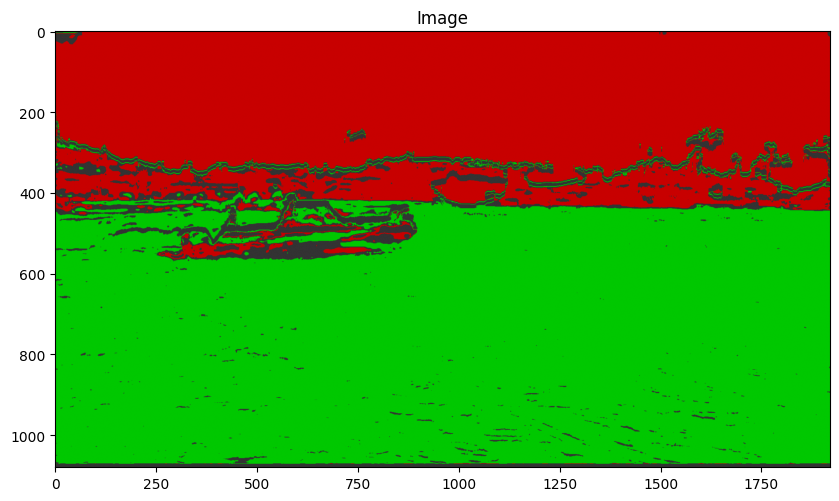

Splitting into lists
Splitting into lists
verticals:  748968
Horizontals:  1173631
Unknown:  151001
[Disparity Value, Derivative Value, V index, U index, Label]


In [116]:
#HORIZONTAL SEGMENTATION


# ----------------------------------------------------------------------------------------------------------------------------------------
# Variabler
# ----------------------------------------------------------------------------------------------------------------------------------------

""" 
img = båt_fram_image
disp = båt_fram_disparity
current_column = 585
"""

img = nærme_image
disp = nærme_disparity
current_column = 730

img = båt_image
disp = båt_disparity
current_column = 585


# ----------------------------------------------------------------------------------------------------------------------------------------

master_switch_init_testing_horizontal = True


if(master_switch_init_testing_horizontal):
    surface_split_disparity_image = disp.copy()
    kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=3, clustering_bool=False, plot_figures=False)
    display_disp_image(kladd_colored_image)

    flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")


    print("Splitting into lists")
    verticals, horizontals, all_objects = split_into_lists(surface_split_disparity_image, kladd_class_map, splitting_derivative)

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    divided_horizontal_disps = create_divided_vertical_disps(divided_horizontal_obj_list)

    all_objects, column_wise_all_objects_list = all_objects


    """ print(" Length vertical objects: ",len(vertical_Obj_List))
    print("Example of vertical object: ", vertical_Obj_List[0])

    print(" Length horizontal objects",len(horizontal_Obj_List))
    print("Example of horizontal object: ", horizontal_Obj_List[0])  """



##### Histograms

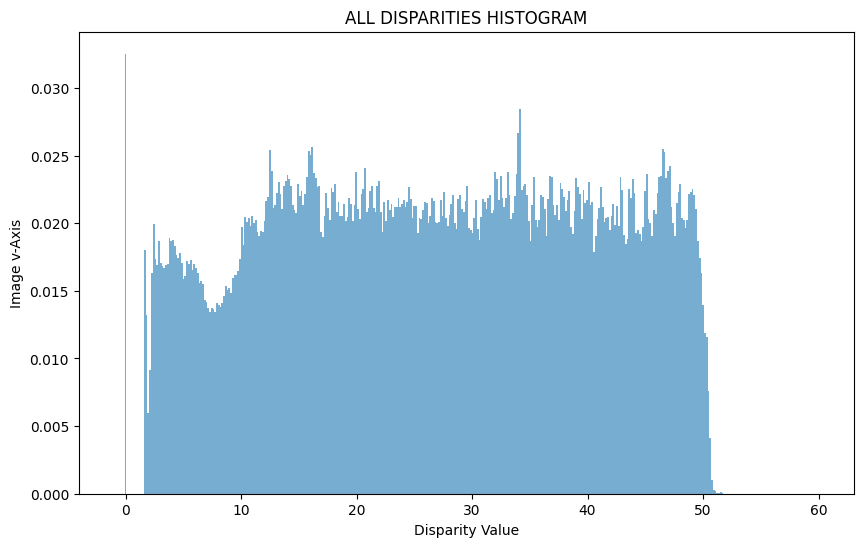

Shape of dI (1080, 1920)
Length of vertical disparities:  1173631


In [125]:


if(master_switch_init_testing_horizontal):
    # View entire disparity data histogram for vertical points:

    #display_disp_image(kladd_colored_image)
    # Båt : [585, 800]
    plt.figure(figsize=(10,6))
    plt.hist(horizontal_Disp_List, bins=400, range=(-1,60), alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('ALL DISPARITIES HISTOGRAM')
    plt.show()

    print("Length of vertical disparities: ", len(horizontal_Disp_List))

Current column:  585


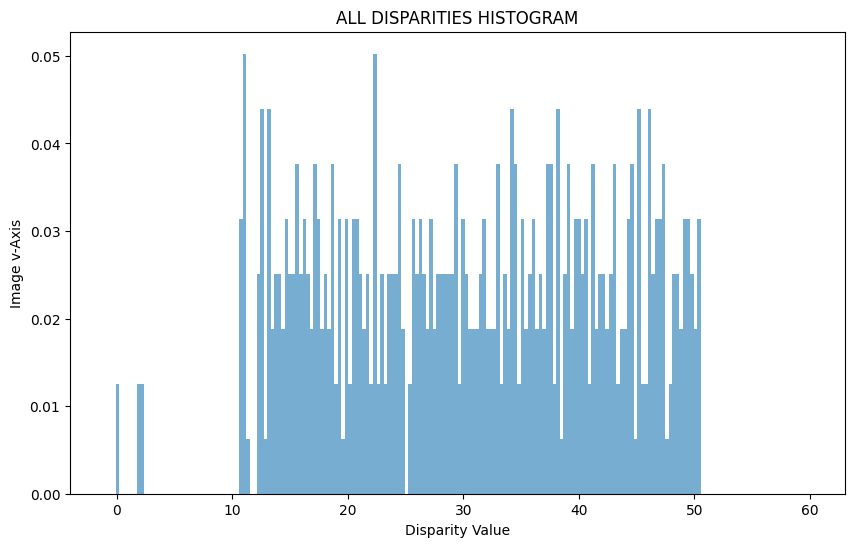

Length of vertical disparities:  1173631


In [120]:

if(master_switch_init_testing_horizontal):
    # View entire disparity data histogram for vertical points:
    print("Current column: ", current_column)
    #display_disp_image(kladd_colored_image)
    # Båt : [585, 800]
    plt.figure(figsize=(10,6))
    plt.hist(divided_horizontal_disps[current_column], bins=200, range=(-1,60), alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('ALL DISPARITIES HISTOGRAM')
    plt.show()

    print("Length of vertical disparities: ", len(horizontal_Disp_List))

##### Definitions of methods

In [126]:
def compute_intersection_points(dI, derivatives):
        height, width = dI.shape
        intersections = np.zeros((height, width))
        all_intersect_list = []
        divided_intersect_list = []

        for x in range(width):
            local_intersect_list = []
            for y in range(height):
                disparity = dI[y, x]
                slope = derivatives[y, x]
                intercept = disparity - slope * x
                intersections[y, x] = intercept
                all_intersect_list.append(intercept)
                local_intersect_list.append(intercept)
            divided_intersect_list.append(local_intersect_list)

        return intersections, all_intersect_list, divided_intersect_list
    
def generate_index_list(column_object_list):
    indexListColumn = []
    for i in range(len(column_object_list)):
        ind = column_object_list[i][2]
        indexListColumn.append(ind)
    return indexListColumn

def get_disp_list_from_object_column(column_object_list, plot=False):
    dispListColumn = []
    row_list=[]
    for i in range(len(column_object_list)):
        disp = column_object_list[i][0]
        row = column_object_list[i][2]
        row_list.append(row)
        dispListColumn.append(disp)

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.plot(dispListColumn, row_list)
        plt.xlabel('Disparity Value')
        plt.ylabel('Row Value')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()
    return dispListColumn

#### Intercepts

Diff method


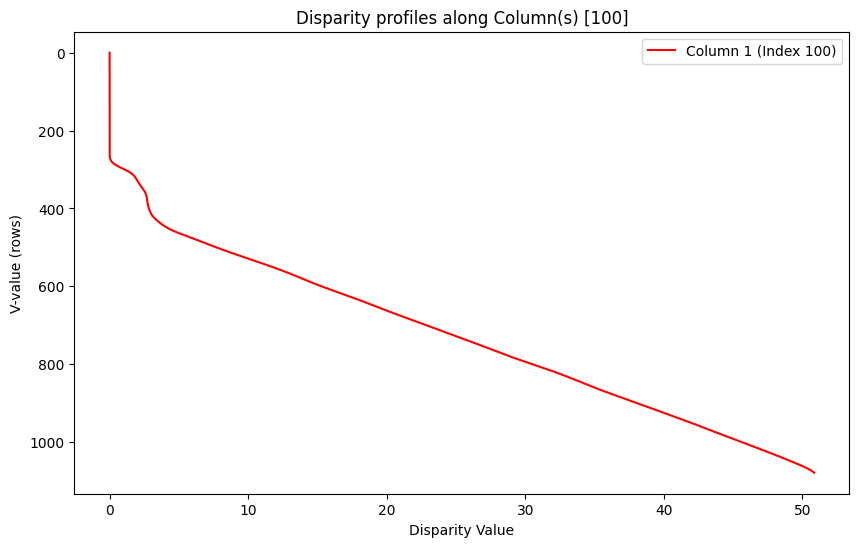

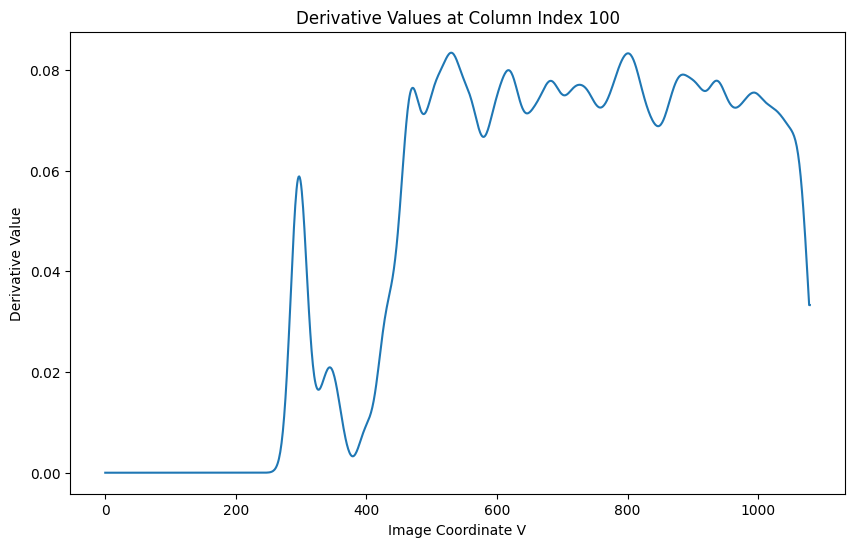

In [121]:
if(master_switch_init_testing_horizontal):
    
    horizontal_test_column = current_column
    horizontal_test_column = 100

    kernel_width = 601
    horizontal_split_binomial_kernel = create_binomial_kernel(kernel_width)

    smoothed_disp_image = disp.copy()


    #disparity_graphing(smoothed_disp_image, col_indices=[horizontal_test_column]) 

    horizontal_low_pass_filtered_disp_image = apply_low_pass_filter(smoothed_disp_image, horizontal_split_binomial_kernel, padding=True)

    disparity_graphing(horizontal_low_pass_filtered_disp_image, col_indices=[horizontal_test_column])

    # Single column horizontal object list
    testing_current_horizontal_object_list = divided_horizontal_obj_list[horizontal_test_column]

    # Testing the horizontal disparity correction
    horizontal_testing_derivatives = take_derivative_diff(horizontal_low_pass_filtered_disp_image)

    derivative_graphing(horizontal_testing_derivatives, horizontal_test_column)



In [122]:
if(master_switch_init_testing_horizontal):

    
    # Testing the horizontal disparity correction
    horizontal_testing_derivatives = take_derivative_diff(horizontal_low_pass_filtered_disp_image)


    

    #derivative_graphing(horizontal_testing_derivatives, horizontal_test_column)

    """ plotting_binomial = horizontal_testing_derivatives[:,horizontal_test_column]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(plotting_binomial)
    plt.title('Derivative Values at Column Index ' +str(horizontal_test_column) +' with a binomial kernel low-pass filter')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.show()
 """
    

Diff method


In [127]:
if(master_switch_init_testing_horizontal):

    

    # Compute intersection points
    intersections, all_intersects, divided_intersects = compute_intersection_points(horizontal_low_pass_filtered_disp_image, horizontal_testing_derivatives)

    indexHorColList = generate_index_list(testing_current_horizontal_object_list)

In [ ]:
if(master_switch_init_testing_horizontal):

    print(indexHorColList)


    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(all_intersects, bins=400, alpha=0.6, label='Histogram', density=True)
    plt.title('All intersection values' +str(horizontal_test_column) +' with a binomial kernel low-pass filter')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.show()


[292, 293, 301, 302, 423, 424, 425, 426, 427, 428, 429, 442, 443, 444, 445, 446, 447, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,

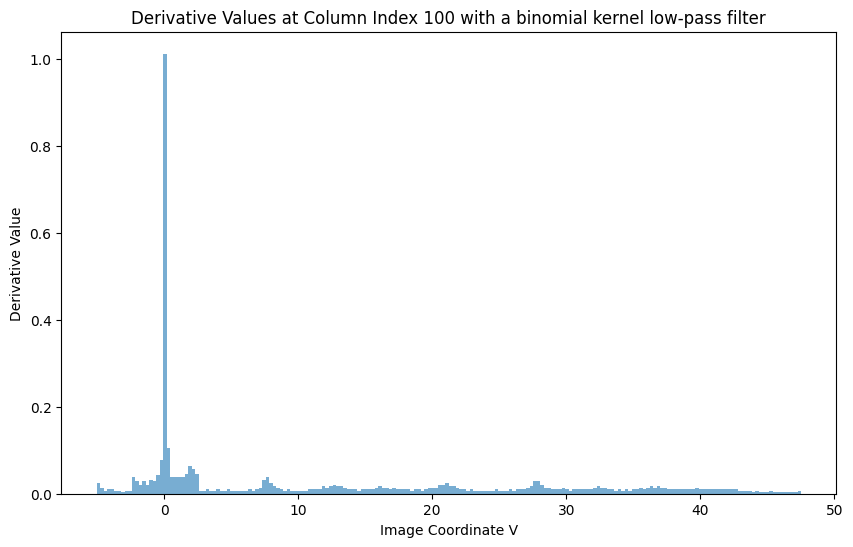

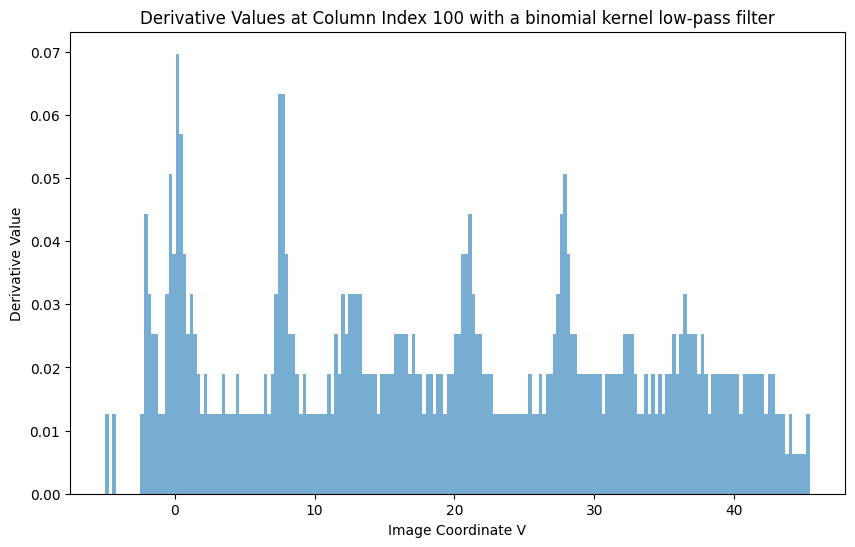

In [124]:
if(master_switch_init_testing_horizontal):

    print(indexHorColList)


    intersects_plot = intersections[:,horizontal_test_column]

    selected_intersections = intersects_plot[indexHorColList]


    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(intersects_plot, bins=200, alpha=0.6, label='Histogram', density=True)
    plt.title('Derivative Values at Column Index ' +str(horizontal_test_column) +' with a binomial kernel low-pass filter')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.show()


    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(selected_intersections, bins=200, alpha=0.6, label='Histogram', density=True)
    plt.title('Derivative Values at Column Index ' +str(horizontal_test_column) +' with a binomial kernel low-pass filter')
    plt.xlabel('Image Coordinate V')
    plt.ylabel('Derivative Value')
    plt.show()


In [ ]:
# Binomial histogram smoothing
from scipy.ndimage import convolve1d
if(master_switch_init_testing_horizontal):
    """ horizontal_binomial_kernel = create_binomial_kernel(25)
    
    # Create histogram
    hist, bin_edges = np.histogram(selected_intersections, bins=300)

    # Apply binomial smoothing
    smoothed_hist = convolve1d(hist, horizontal_binomial_kernel, mode='reflect')

    # Plotting the histogram and the smoothed histogram
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], alpha=0.6, label='Original Histogram')
    plt.plot(bin_centers, smoothed_hist, color='red', label='Smoothed Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram with Binomial Smoothing')
    plt.show() """

    #plot_and_test_hist_smoothing(selected_intersections, ns=[17,21,25,31], input_range=(-100,30), bins=200, plot_original=True, signi_check=True, detect_peaks=False, plot=True)
   
    

#### GMM testing horizontal split


In [ ]:
""" 
def smooth_hist_binomial(list,  input_range,  bins=200, plot_original=True, plot=True):
    hist, bin_edges = np.histogram(list, bins=bins, range=input_range)


    if(plot_original):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Histogram of Disparity Data with Binomial Smoothing')
        plt.show()

    
    kernel_binomial_vertical =create_binom_kernel(n)
    
    # Smooth the histogram
    smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
        plt.show()

    return smoothed_hist """

In [ ]:
""" gmm_horizontal_split_test = True

if(gmm_horizontal_split_test):


    intersections = compute_intersection_points(horizontal_low_pass_filtered_disp_image, horizontal_testing_derivatives)

    indexHorColList = generate_index_list(testing_current_horizontal_object_list)
    intersects_plot = intersections[:,horizontal_test_column]

    selected_intersections = intersects_plot[indexHorColList]





    min_clip=-40    
    max_clip=30
    num_curves=3
    num_bins=200
    p=0.05
    k=2
    plot=True
    version=1


    input_range = (min_clip, max_clip)

    #smoothed_selected_intersections = smooth_hist_binomial(selected_intersections, input_range=(min_clip, max_clip), bins=num_bins, plot=True)

    smoothed_selected_intersections = selected_intersections.copy()
 

    print("Thresholds Clipping verstion")

    preclipped = np.clip(smoothed_selected_intersections, min_clip, max_clip)
    clipped_intersections = preclipped[(preclipped > min_clip) & (preclipped < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_intersections, bins=num_bins, density=True)
    max_frequency = np.max(hist_values)
    threshold = p * max_frequency
    if(plot):
        print("Maximum frequency in the histogram:", max_frequency)
        print(f"Threshold ({p*100}% of max frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)



    # Find the indices of non-zero bins in the smoothed histogram 
    non_zero_indices = np.nonzero(smooth_hist_values)[0]

    # Extract the minimum and maximum value along the value axis
    min_value_range = bin_edges[non_zero_indices[0]]
    max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

    reclipped_intersections = clipped_intersections[(clipped_intersections > min_value_range) & (clipped_intersections < max_value_range)]  
    #reclipped_intersections = clipped_intersections


    smoothed_clipped = smooth_hist_binomial(clipped_intersections, input_range=(min_clip, max_clip), bins=num_bins, plot=False)
    smoothed_reclipped = smooth_hist_binomial(reclipped_intersections, input_range=(min_clip, max_clip), bins=num_bins, plot=False)



    #print(clipped_intersections)
    #print(reclipped_intersections)

    n_clipped=3
    n_reclipped = 3
   

    ##########################################
    # Clipped
    ##########################################
    print("Fitting clipped")
    gmm_clipped = GaussianMixture(n_components=n_clipped, random_state=0)
    #gmm_clipped.fit(clipped_intersections.reshape(-1, 1))
    gmm_clipped.fit(smoothed_clipped.reshape(-1, 1))

    means_clipped = gmm_clipped.means_.flatten()
    covariances_clipped = gmm_clipped.covariances_.flatten()
    weights_clipped = gmm_clipped.weights_.flatten()

    ##########################################
    # Reclipped
    ##########################################
    print("Fitting reclipped")
    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm_reclipped = GaussianMixture(n_components=n_reclipped, random_state=0)
    #gmm_reclipped.fit(reclipped_intersections.reshape(-1, 1))
    gmm_reclipped.fit(smoothed_reclipped.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means_reclipped = gmm_reclipped.means_.flatten()
    covariances_reclipped = gmm_reclipped.covariances_.flatten()
    weights_reclipped = gmm_reclipped.weights_.flatten() """

In [ ]:
""" 

def smooth_hist_binomial(list, n=15, bins=200, input_range=(-1,64), plot_original=True, plot=True):
    hist, bin_edges = np.histogram(list, bins=bins, range=input_range)


    if(plot_original):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Histogram of Disparity Data with Binomial Smoothing')
        plt.show()

    
    kernel_binomial_vertical =create_binom_kernel(n)
    
    # Smooth the histogram
    smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
        plt.show()

    return smoothed_hist


if(gmm_horizontal_split_test):

    x_values = np.linspace(min_clip, max_clip, 400)
    print(min_clip, max_clip)


    ##########################################
    # Clipped
    ##########################################

    print("Clipped edges 2 curves")
    print("Clipped 2 weights: ", weights_clipped)
    weights_fabricated = [weights_clipped[0], 0.2]
    gaussian_pdfs_clipped = [
        #weights_fabricated[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        weights_clipped[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        for i in range(n_clipped)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_intersections, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_clipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_clipped[i]:.2f}, SD: {np.sqrt(covariances_clipped[i]):.2f})')
    plt.legend()

    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()



    ##########################################
    # Reclipped
    ##########################################

    print("Reclipped 2 curves")
    print("Reclipped 2 weights: ", weights_reclipped)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped = [
        weights_reclipped[i] * norm.pdf(x_values, means_reclipped[i], np.sqrt(covariances_reclipped[i]))
        for i in range(n_reclipped)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_intersections, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped[i]:.2f}, SD: {np.sqrt(covariances_reclipped[i]):.2f})')
    plt.legend()

    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show() """

## Pregrouping approach

### Consecutive points grouping

##### Kolonner til bilder

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


In [ ]:
""" 
img = nærme_image
disp = nærme_disparity
testing_column_horizontals = 730 
"""

img = badering_første_image
disp = badering_første_disparity
testing_column_horizontals = 1280

""" img = båt_image
disp = båt_disparity  
testing_column_horizontals = 585 """

""" img = kajakk_båt_image
disp = kajakk_båt_disparity
testing_column_horizontals = 800
"""

""" img = badering_mann_image
disp = badering_mann_disparity
testing_column_horizontals = 620 """

# ----------------------------------------------------------------------------------------------------------------------------------------

pregrouping_bool_testing = True
original_split_into_lists = True


if(pregrouping_bool_testing):
    surface_split_disparity_image = disp.copy()
    kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=3, clustering_bool=False, plot_figures=False)
    display_disp_image(kladd_colored_image)

    flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")


    if(original_split_into_lists):
        print("Splitting into lists")
        verticals, horizontals, all_objects = split_into_lists(surface_split_disparity_image, kladd_class_map, splitting_derivative)

        vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
        horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals

        all_objects, column_wise_all_objects_list = all_objects
        testing_column_all_objects = column_wise_all_objects_list[testing_column_horizontals]

        divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
        divided_horizontal_disps = create_divided_vertical_disps(divided_horizontal_obj_list)



##### Definition of methods:

In [ ]:
KAPPA_THRESHOLD = 4.5
MAX_V_VALUE_DISTANCE = 5
MIN_SIZE_HORIZONTAL_GROUP = 5
MIN_SIZE_COMBINED_GROUP = 15
VERTICAL_SLOPE = 0.01
VERTICAL_INTERSECTION = 0.001

In [ ]:
def single_column_list_generator(classification_map, disparity_image, derivative_image, column_index, horizontal_vals=['horizontal'], vertical_vals=['vertical']):

    horizontal_column_derivative_list = []
    horizontal_column_object_list = []
    vertical_column_derivative_list = []
    vertical_column_object_list = []
    for i, val in enumerate(classification_map[:, column_index]):
        #print(val)
        
        if(val in horizontal_vals):
            der = derivative_image[i, column_index]
            disp = disparity_image[i, column_index]

            appendObjColHor = [der, disp, i, column_index, val]
            horizontal_column_derivative_list.append(der)
            horizontal_column_object_list.append(appendObjColHor)

        #if(val == 'vertical1' or val == 'vertical2' or val == 'vertical3' or val == 'vertical4'):
        if(val in vertical_vals):
            der = derivative_image[i, column_index]
            disp = disparity_image[i, column_index]

            appendObjColVert = [der, disp, i, column_index, val]
            vertical_column_derivative_list.append(der)
            vertical_column_object_list.append(appendObjColVert)
    
    return horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list

def index_list_from_column_object_list(column_object_list):
    indexListColumn = []
    for i in range(len(column_object_list)):
        ind = column_object_list[i][2]
        indexListColumn.append(ind)
    return indexListColumn

def get_column_data_and_y_values(disparity_image, column_index):
    column_data = disparity_image[:, column_index]
    y_values = range(len(column_data))
    #y_values = np.arange(disparity_image.shape[0])
    return column_data, y_values

def group_indices(indices, max_v_value_range=1, reverse_order=False):
    if not indices:
        return []
    if(reverse_order):
        sorted_indices = sorted(indices, reverse=True)
    
        groups = [[sorted_indices[0]]]
        for index in sorted_indices[1:]:
            if abs(groups[-1][-1] - index) <= max_v_value_range:
                groups[-1].append(index)
            else:
                groups.append([index]) 
    else:
        sorted_indices = sorted(indices)
        groups = [[sorted_indices[0]]]
        for index in sorted_indices[1:]:
            if index - groups[-1][-1] <= max_v_value_range:
                groups[-1].append(index)
            else:
                groups.append([index])
        #print("LENGTH OF GROUPS: ", len(groups))
    return groups

 # Method to perform the scatter plot and linear regression plotting

def plot_grouped_points(grouped_index_list, col_data, y_vals):
    # Generate colors for each group
    colors = generate_dark_colors(len(grouped_index_list), shuffle_bool=True)

    # Scatter plot each group with respective colors
    plt.figure(figsize=(10, 6))
    for i, group in enumerate(grouped_index_list):
        group_row_values = [y_vals[idx] for idx in group]
        group_disparity_values = [col_data[idx] for idx in group]
        plt.scatter(group_disparity_values, group_row_values, color=colors[i], s=10, label=f'Group {i+1}')
    plt.gca().invert_yaxis()
    plt.xlabel('Disparity Value')
    plt.ylabel('Row Value')
    plt.title('Scatter Plot of Groups with Dark Colours')
    plt.legend()
    plt.show() 

def horizontal_linear_regression_and_residuals(group_row_values, group_disp_values):
    # Convert to numpy arrays for linear regression
    group_disp_values = np.array(group_disp_values)
    group_row_values = np.array(group_row_values)

    # Perform linear regression
    A = np.vstack([group_row_values, np.ones(len(group_row_values))]).T
    m, c = np.linalg.lstsq(A, group_disp_values, rcond=None)[0]

    # Calculate residuals
    residuals = group_disp_values - (m * group_row_values + c)

    sum_squared_residuals = np.sum(residuals ** 2)

    # Calculate standard deviation of residuals
    std_dev = np.std(residuals)
    if std_dev < 0.01:
        std_dev = 0.01

    return m, c, std_dev, sum_squared_residuals

def grouped_linear_regression(grouped_index_list, column_data, row_data, labels=HORIZONTAL_LABELS, plot=True, legend_bool=False):
    # Generate colors for each group    
    line_extension = 50

    colors = generate_dark_colors(len(grouped_index_list), shuffle_bool=True)

    # Initialize lists to store linear regression results
    line_equations = []
    edge_boundaries = []

    # Plot with linear regression lines
    if(plot):
        plt.figure(figsize=(10,6))
    for i, group in enumerate(grouped_index_list):
        #print("Index i: ", i)
        if group:# and len(group) > MIN_SIZE_HORIZONTAL_GROUP:
            #print("Length of group: ", len(group))
            row_values = [row_data[idx] for idx in group]
            disparity_values = [column_data[idx] for idx in group]
            if(plot):
                plt.scatter(disparity_values, row_values, color=colors[i], s=10, label=f'Group {i+1}')
            
              # Convert to numpy arrays for linear regression
            group_disp_values = np.array(disparity_values)
            group_row_values = np.array(row_values)
            
            m, c, std_dev, ssr = horizontal_linear_regression_and_residuals(group_row_values, group_disp_values)

            if((abs(m) < VERTICAL_SLOPE)):
                # and abs(c) < VERTICAL_INTERSECTION
                continue
            current_label = labels[i]
            appendObject = [m, c, std_dev, current_label]

            #print(appendObject)
            
            # Store the line equation and other relevant data
            line_equations.append(appendObject)
            edge_boundaries.append((min(group_row_values), max(group_row_values)))
            
            # Plot the regression line
            extended_start = min(group_row_values) - line_extension
            extended_end = max(group_row_values) + line_extension
            extended_x = np.linspace(extended_start, extended_end, 400)
            if(plot):
                plt.plot( m * extended_x + c, extended_x, color=colors[i], label=f'Line: y={m:.2f}x+{c:.2f}')
    if(plot):   
        plt.gca().invert_yaxis()
        plt.xlabel('Row Value')
        plt.ylabel('Disparity Value')
        plt.title('Scatter Plot of Groups with Dark Colours and Linear Regression Lines')
        if legend_bool:
            plt.legend()
        plt.show()

    return line_equations


In [ ]:
print("Testing column horizontals: ", testing_column_all_objects)

In [ ]:


test_new_horizontal_pipeline = True

# Initial variables
# disp = disparity_image
# current_column = column_index
# kladd_class_map = classification_map
# splitting_derivative = derivative_image

current_column = testing_column_horizontals
max_v_value_distance = 5

print("Current column: ", current_column)

if(test_new_horizontal_pipeline):


    # Column data from a single column
    horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator(kladd_class_map, disp, splitting_derivative, current_column)

    hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
    vert_index_list_current_column = index_list_from_column_object_list(vertical_column_object_list)

    column_data, row_values = get_column_data_and_y_values(disp, current_column)


    if(False):  
        plt.figure(figsize=(10, 6))
        plt.plot(column_data, row_values )

        title_for_plot= 'Column index: ' + str(current_column)
        plt.gca().invert_yaxis()
        plt.xlabel('Disparity Value')
        plt.ylabel('Image v-Axis')
        plt.title(title_for_plot)
        plt.show()


        plt.figure(figsize=(10, 6))
        highlighted_horizontal_y_values = [row_values[i] for i in hor_index_list_current_column]
        highlighted_horizontal_column_data = [column_data[i] for i in hor_index_list_current_column]

        highlighted_vertical_y_values = [row_values[i] for i in vert_index_list_current_column]
        highlighted_vertical_column_data = [column_data[i] for i in vert_index_list_current_column]
        # Plotting highlighted points on top with a different color
        plt.scatter(highlighted_vertical_column_data, highlighted_vertical_y_values, color='red', s=2, zorder=1, label='Highlighted Points')
        plt.scatter(highlighted_horizontal_column_data, highlighted_horizontal_y_values, color='green', s=2, zorder=1, label='Highlighted Points')
        
        title_for_plot= 'Column index: ' + str(current_column)
        plt.gca().invert_yaxis()
        plt.ylabel('Disparity Value')
        plt.xlabel('Image v-Axis')
        plt.title(title_for_plot)
        plt.show() 

    # Grouping the indices
    grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=max_v_value_distance, reverse_order=True)

    # Plotting the grouped points
    plot_grouped_points(grouped_indices_horizontal, column_data, row_values)

    combined_line_equations_horizontal = grouped_linear_regression(grouped_indices_horizontal, column_data, row_values, legend_bool=True)


    


##### Merging groups attempt definitions

In [ ]:

def combine_groups_based_on_kappa(input_groups, column_data, row_values, kappa_threshold=1, print_bool=False, plot_each_group=False):
    combined_groups = []
    groups = input_groups.copy()
    i = 0
    while i < len(groups):
        if i == len(groups) - 1:
            combined_groups.append(groups[i])
            break

        group_a = groups[i]
        group_b = groups[i + 1]

        # Get values for group_a
        disparity_values_a = [column_data[idx] for idx in group_a]
        row_values_a = [row_values[idx] for idx in group_a]
        m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)

        # Get values for group_b
        disparity_values_b = [column_data[idx] for idx in group_b]
        row_values_b = [row_values[idx] for idx in group_b]
        m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)

        # Combine both groups
        combined_group = group_a + group_b
        disparity_values_combined = [column_data[idx] for idx in combined_group]
        row_values_combined = [row_values[idx] for idx in combined_group]
        m_combined, c_combined, std_combined, ssr_combined = horizontal_linear_regression_and_residuals(row_values_combined, disparity_values_combined)

        # Calculate kappa
        kappa = ssr_combined / (ssr_a + ssr_b)
        if print_bool:
            print(f'Kappa for groups {i+1} and {i+2}: {kappa:.2f}')
        if plot_each_group:
            plt.figure(figsize=(10, 6))
            plt.scatter(disparity_values_a, row_values_a, color='blue', s=10, label='Group 1')
            plt.scatter(disparity_values_b, row_values_b, color='red', s=10, label='Group 2')
            plt.scatter(disparity_values_combined, row_values_combined, color='green', s=10, label='Combined Group')
            plt.plot(m_a * np.array(row_values_a) + c_a, row_values_a, color='blue', label=f'Line 1: y={m_a:.2f}x+{c_a:.2f}')
            plt.plot(m_b * np.array(row_values_b) + c_b, row_values_b, color='red', label=f'Line 2: y={m_b:.2f}x+{c_b:.2f}')
            plt.plot(m_combined * np.array(row_values_combined) + c_combined, row_values_combined, color='green', label=f'Line Combined: y={m_combined:.2f}x+{c_combined:.2f}')
            plt.gca().invert_yaxis()
            plt.xlabel('Disparity Value')
            plt.ylabel('Row Value')
            plt.title('Scatter Plot of Groups with Linear Regression Lines')
            plt.legend()
            plt.show()

        if kappa <= kappa_threshold:
            # Replace group_a with the combined group and recheck with the next group
            groups[i] = combined_group
            del groups[i + 1]
            if print_bool:
                print(f'COMBINED GROUPS {i+1} and {i+2}!!!!!!!')
        else:
            combined_groups.append(group_a)
            i += 1  # Move to the next group
            if print_bool:
                print(f'No combine')

    # Append the last group if it was not combined
    if i == len(groups) - 1:
        combined_groups.append(groups[i])

    return combined_groups

def combine_groups_based_on_kappa_ALL(input_groups, column_data, row_values, min_size_group=MIN_SIZE_HORIZONTAL_GROUP, kappa_threshold=1, print_bool=False, plot_each_group=False):
    combined_groups = []
    groups = input_groups.copy()    

    i = 0
    while i < (len(groups)):
        group_a = groups[i]
        len_a = len(group_a)
        if(len_a < min_size_group):
                if(print_bool):
                    print("Group size ", len_a ," is too small")
                i += 1
                combined_groups.append(group_a)
                continue

        # Get values for group_a
        disparity_values_a = [column_data[idx] for idx in group_a]
        row_values_a = [row_values[idx] for idx in group_a]
        m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)

        j = i + 1
        while j < len(groups):
            group_b = groups[j]
            len_b = len(group_b)
            if(len_b < min_size_group):
                if(print_bool):
                    print("Group size ", len_b ," is too small")
                j += 1
                continue

            # Get values for group_b
            disparity_values_b = [column_data[idx] for idx in group_b]
            row_values_b = [row_values[idx] for idx in group_b]
            m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)

            # Combine both groups
            combined_group = group_a + group_b
            disparity_values_combined = [column_data[idx] for idx in combined_group]
            row_values_combined = [row_values[idx] for idx in combined_group]
            m_combined, c_combined, std_combined, ssr_combined = horizontal_linear_regression_and_residuals(row_values_combined, disparity_values_combined)

            # Calculate kappa
            kappa = ssr_combined / (ssr_a + ssr_b)
            if print_bool:
                print(f'Kappa for groups {i+1} and {j+1}: {kappa:.2f}')
            if plot_each_group:
                plt.figure(figsize=(10, 6))
                plt.scatter(disparity_values_a, row_values_a, color='blue', s=10, label='Group A')
                plt.scatter(disparity_values_b, row_values_b, color='red', s=10, label='Group B')
                plt.scatter(disparity_values_combined, row_values_combined, color='green', s=10, label='Combined Group')
                plt.plot(np.array(row_values_a), m_a * np.array(row_values_a) + c_a, color='blue', label=f'Line A: y={m_a:.2f}x+{c_a:.2f}')
                plt.plot(np.array(row_values_b), m_b * np.array(row_values_b) + c_b, color='red', label=f'Line B: y={m_b:.2f}x+{c_b:.2f}')
                plt.plot(np.array(row_values_combined), m_combined * np.array(row_values_combined) + c_combined, color='green', label=f'Line Combined: y={m_combined:.2f}x+{c_combined:.2f}')
                plt.gca().invert_yaxis()
                plt.xlabel('Disparity Value')
                plt.ylabel('Row Value')
                plt.title('Scatter Plot of Groups with Linear Regression Lines')
                plt.legend()
                plt.show()

            if kappa <= kappa_threshold and len(combined_group) >= MIN_SIZE_COMBINED_GROUP:
                
                # Replace group_a with the combined group
                group_a = combined_group
                disparity_values_a = disparity_values_combined
                row_values_a = row_values_combined
                m_a, c_a, std_a, ssr_a = m_combined, c_combined, std_combined, ssr_combined
                del groups[j]
                if print_bool:
                    print(f'COMBINED GROUPS {i+1} and {j+1}!!!!!!!')
            else:
                j += 1  # Move to the next group
        i += 1
        combined_groups.append(group_a)

    return combined_groups

def combine_groups_based_on_kappa_NEXT(input_groups, column_data, row_values, kappa_threshold=1, print_bool=False, plot_each_group=False):
    combined_groups = []
    groups = input_groups.copy()    

    i = 0
    while i < (len(groups)):
        group_a = groups[i]

        # Get values for group_a
        disparity_values_a = [column_data[idx] for idx in group_a]
        row_values_a = [row_values[idx] for idx in group_a]
        m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)

        j = i + 1
        if j < len(groups):
            group_b = groups[j]

            # Get values for group_b
            disparity_values_b = [column_data[idx] for idx in group_b]
            row_values_b = [row_values[idx] for idx in group_b]
            m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)

            # Combine both groups
            combined_group = group_a + group_b
            disparity_values_combined = [column_data[idx] for idx in combined_group]
            row_values_combined = [row_values[idx] for idx in combined_group]
            m_combined, c_combined, std_combined, ssr_combined = horizontal_linear_regression_and_residuals(row_values_combined, disparity_values_combined)

            # Calculate kappa
            kappa = ssr_combined / (ssr_a + ssr_b)
            if print_bool:
                print(f'Kappa for groups {i+1} and {j+1}: {kappa:.2f}')
            if plot_each_group:
                plt.figure(figsize=(10, 6))
                plt.scatter(disparity_values_a, row_values_a, color='blue', s=10, label='Group A')
                plt.scatter(disparity_values_b, row_values_b, color='red', s=10, label='Group B')
                plt.scatter(disparity_values_combined, row_values_combined, color='green', s=10, label='Combined Group')
                plt.plot(np.array(row_values_a), m_a * np.array(row_values_a) + c_a, color='blue', label=f'Line A: y={m_a:.2f}x+{c_a:.2f}')
                plt.plot(np.array(row_values_b), m_b * np.array(row_values_b) + c_b, color='red', label=f'Line B: y={m_b:.2f}x+{c_b:.2f}')
                plt.plot(np.array(row_values_combined), m_combined * np.array(row_values_combined) + c_combined, color='green', label=f'Line Combined: y={m_combined:.2f}x+{c_combined:.2f}')
                plt.gca().invert_yaxis()
                plt.xlabel('Disparity Value')
                plt.ylabel('Row Value')
                plt.title('Scatter Plot of Groups with Linear Regression Lines')
                plt.legend()
                plt.show()

            if kappa <= kappa_threshold:
                # Replace group_a with the combined group
                group_a = combined_group
                disparity_values_a = disparity_values_combined
                row_values_a = row_values_combined
                m_a, c_a, std_a, ssr_a = m_combined, c_combined, std_combined, ssr_combined
                del groups[j]
                if print_bool:
                    print(f'COMBINED GROUPS {i+1} and {j+1}!!!!!!!')
            
        i += 1
        combined_groups.append(group_a)

    return combined_groups


def assign_pregrouping_labels(grouped_index_list, column_all_object_list, labels=HORIZONTAL_LABELS, modify_original=False):

    if(modify_original):
        new_column_object_list = column_all_object_list
    else:
        new_column_object_list = column_all_object_list.copy()

    for group_index, group in enumerate(grouped_index_list):
        len_of_group = len(group)
        #if(len_of_group < MIN_SIZE_HORIZONTAL_GROUP or len_of_group > len(labels)):
        if(len_of_group < MIN_SIZE_HORIZONTAL_GROUP):

            current_label = 'unknown'
        else:
            current_label = labels[group_index]
        

        for index in group:
            
            new_column_object_list[index][4] = current_label
        
    return new_column_object_list


def column_full_grouping_horizontal_pipeline(disp, current_column, kladd_class_map, splitting_derivative, kappa_all_version=True, max_v_value_distance=5, kappa_threshold=4.5, plot=False):

    _, horizontal_column_object_list, _, vertical_column_object_list = single_column_list_generator(kladd_class_map, disp, splitting_derivative, current_column)

    hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
    #vert_index_list_current_column = index_list_from_column_object_list(vertical_column_object_list)

    column_data, row_values = get_column_data_and_y_values(disp, current_column)

    grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=max_v_value_distance, reverse_order=True)
    
    if(plot):
        plot_grouped_points(grouped_indices_horizontal, column_data, row_values)


    if(kappa_all_version):
        combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, min_size_group=MIN_SIZE_HORIZONTAL_GROUP, kappa_threshold=kappa_threshold, print_bool=True, plot_each_group=False)
    else:
        combined_grouped_indices_horizontal = combine_groups_based_on_kappa_NEXT(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, print_bool=True, plot_each_group=False)

    if(plot):
        plot_grouped_points(combined_grouped_indices_horizontal, column_data, row_values)

    if(plot):
        for group in combined_grouped_indices_horizontal:
            print("Length of group: ", len(group))

    #testing_column_all_objects
    new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, testing_column_all_objects, modify_original=False)

    if(plot):
        print("Testing column object updated: ", new_testing_column_all_objects)

    combined_line_equations_horizontal = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, legend_bool=True)


    return new_testing_column_all_objects, combined_line_equations_horizontal

In [ ]:

new_column_all_objects, combined_line_equations_horizontal = column_full_grouping_horizontal_pipeline(disp, current_column, kladd_class_map, splitting_derivative, kappa_all_version=False, max_v_value_distance=5, kappa_threshold=KAPPA_THRESHOLD, plot=True)



In [ ]:
current_column_index = 1100
input_kappa_threshold = 4.5
row_distance = 5
min_size_group = 4
#display_disp_image(disp)
#display_disp_image(img)

print("Column: ", current_column_index)
horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator(kladd_class_map, disp, splitting_derivative, current_column_index)

hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
vert_index_list_current_column = index_list_from_column_object_list(vertical_column_object_list)

column_data, row_values = get_column_data_and_y_values(disp, current_column_index)

grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=row_distance, reverse_order=True)
plot_grouped_points(grouped_indices_horizontal, column_data, row_values)

for i, group in enumerate(grouped_indices_horizontal):
    print("Length of group ", i+1, ":", len(group))


#combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, min_size_group=min_size_group, kappa_threshold=input_kappa_threshold, print_bool=True, plot_each_group=False)
combined_grouped_indices_horizontal = combine_groups_based_on_kappa_NEXT(grouped_indices_horizontal, column_data, row_values, kappa_threshold=input_kappa_threshold, print_bool=True, plot_each_group=False)


plot_grouped_points(combined_grouped_indices_horizontal, column_data, row_values)

for group in combined_grouped_indices_horizontal:
    print("Length of group: ", len(group))

#testing_column_all_objects
new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, testing_column_all_objects)

print("Testing column object updated: ", new_testing_column_all_objects)

combined_line_equations_horizontal = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, legend_bool=True)

for i in combined_line_equations_horizontal:
    print(i)
print("") 
print("-----------------------------------------------------------------------------------------------------")
print("")


In [ ]:
for group in combined_grouped_indices_horizontal:
    print("Length of group: ", len(group))

combined_line_equations_horizontal = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, legend_bool=True)



In [ ]:
for group in combined_grouped_indices_horizontal:
    print("Length of group: ", len(group))

combined_line_equations_horizontal = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, legend_bool=True)



In [ ]:
#display_disp_image(img)

display_disp_image(img)


### FULL SEGMENTATION (VERTICAL FOCUS)

In [ ]:




def pipeline_full_disparity_correction(disp, class_map, derivative, current_working_vertical_object_list, current_divided_all_objects_list, kappa_all_version=True, print_lines=False, grouping_distance=MAX_V_VALUE_DISTANCE, kappa_threshold=KAPPA_THRESHOLD, reclassify_points=True, plot=False):

    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list)
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in range(len(column_wise_working_vertical_object_list)):
        #print("Column index: ", col_ind)

        current_column_vertical_object_list = column_wise_working_vertical_object_list[col_ind]
        current_column_all_objects_list = current_divided_all_objects_list[col_ind]
        



        # Vertical line equations
        label_wise_vertical_object_list = create_label_wise_object_list(current_column_vertical_object_list)
        disp_vals_col_vertical, row_vals_col_vertical, labels_vertical  = extract_and_scatter_plot(label_wise_vertical_object_list, plot=plot)
        vertical_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, labels_col=labels_vertical, plot=plot)
        
        # Horizontal line equations
        _, horizontal_column_object_list, _, _ = single_column_list_generator(class_map, disp, derivative, col_ind)
        hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
        column_data, row_values = get_column_data_and_y_values(disp, current_column)

        grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=grouping_distance, reverse_order=True)
        if(kappa_all_version):
            combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, min_size_group=MIN_SIZE_HORIZONTAL_GROUP, print_bool=False, plot_each_group=False)
        else:
            #combined_grouped_indices_horizontal = combine_groups_based_on_kappa_NEXT(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, print_bool=False, plot_each_group=False)
            combined_grouped_indices_horizontal = combine_groups_based_on_kappa(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, print_bool=False, plot_each_group=False)

        new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, current_column_all_objects_list, modify_original=True)    
        horizontal_line_equations = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, plot=False, legend_bool=True)


        # Combine the line equations
        line_equations = vertical_line_equations # + horizontal_line_equations
        

        if(print_lines):
            print("All line equations: ", line_equations)

    


        if(reclassify_points):
            #print("reclassifying_points")
            reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(new_testing_column_all_objects, line_equations, apply_change=True, printing=False)

            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=VERTICAL_LABELS)
            new_horizontal_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=HORIZONTAL_LABELS)

            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_vertical_object_list = create_label_wise_object_list(new_vertical_Obj_List)
            label_wise_horizontal_object_list = create_label_wise_object_list(new_horizontal_Obj_List)

            disp_vals_col_vertical, row_vals_col_vertical, labels_vertical  = extract_and_scatter_plot(label_wise_vertical_object_list, plot=plot)
            disp_vals_col_horizontal, row_vals_col_horizontal, labels_horizontal  = extract_and_scatter_plot(label_wise_horizontal_object_list, plot=plot)

            vertical_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, labels_col=labels_vertical, plot=plot)
            horizontal_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_horizontal, row_vals_col=row_vals_col_horizontal, labels_col=labels_horizontal, plot=plot)

        ##

            # Vertical points
            corrected_disparity_points_vertical = correct_and_plot_points(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, line_equations=vertical_line_equations, plot=plot) 
            corrected_disparity_points_horizontal = correct_and_plot_points(disp_vals_col=disp_vals_col_horizontal, row_vals_col=row_vals_col_horizontal, line_equations=horizontal_line_equations, plot=plot)
        
            correct_disparity_values(row_vals_col_vertical, corrected_disparity_points_vertical, reclassified_current_column_all_points_list)
            correct_disparity_values(row_vals_col_horizontal, corrected_disparity_points_horizontal, reclassified_current_column_all_points_list)
            current_divided_all_objects_list[col_ind] = reclassified_current_column_all_points_list

        else:
             # Vertical points
            corrected_disparity_points_vertical = correct_and_plot_points(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, line_equations=vertical_line_equations, plot=plot) 
            correct_disparity_values(row_vals_col_vertical, corrected_disparity_points_vertical, current_column_all_objects_list)



        """ updated_labels_vertical = labels_vertical

        new_label_object_list= update_disparities_and_labels_in_column_list(current_column_vertical_object_list, row_vals_col_vertical, corrected_disparity_points_vertical, updated_labels_vertical)
        """
    return column_wise_working_vertical_object_list, current_divided_all_objects_list


def horizontal_colouring(disp, img, class_map, derivative, divided_horizontal_obj_list, divided_all_objects_list,kappa_all_version=True, grouping_distance=MAX_V_VALUE_DISTANCE, kappa_threshold=KAPPA_THRESHOLD, plot=False):
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in range(len(divided_horizontal_obj_list)):
        #print("Column index: ", col_ind)

        current_column_horizontals = divided_horizontal_obj_list[col_ind]
        current_column_all_objects_list = divided_all_objects_list[col_ind]
    
        # Horizontal line equations
        _, horizontal_column_object_list, _, _ = single_column_list_generator(class_map, disp, derivative, col_ind)
        hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
        column_data, row_values = get_column_data_and_y_values(disp, current_column)

        grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=grouping_distance, reverse_order=True)
        combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, min_size_group=MIN_SIZE_HORIZONTAL_GROUP, print_bool=False, plot_each_group=False)
        new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, current_column_all_objects_list, modify_original=True)    
        horizontal_line_equations = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, plot=False, legend_bool=True)

        divided_all_objects_list[col_ind] = new_testing_column_all_objects

    local_extended_all_objects_list = extend_labels(divided_all_objects_list)

    updated_class_map = create_classification_map(local_extended_all_objects_list, img, class_map)

    return divided_all_objects_list, updated_class_map

def testing_pipeline_full_disparity_correction_NEW(disp, class_map, derivative, current_working_vertical_object_list, current_divided_all_objects_list, specified_columns=[1500,1520,1550,1600,1620], print_lines=False, grouping_distance=MAX_V_VALUE_DISTANCE, kappa_threshold=KAPPA_THRESHOLD, reclassify_points=True, plot=False):

    #def pipeline_full_disparity_correction(current_working_vertical_object_list, current_divided_all_objects_list, specified_columns=[1500,1520,1550,1600,1620], reclassify_points=False, plot=False):

    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list)
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in specified_columns:
        print("-----------------------------------------------------")
        print("-----------------------------------------------------")
        print("COLUMN INDEX: ", col_ind)
        print("-----------------------------------------------------")
        print("-----------------------------------------------------")


        #print("Column index: ", col_ind)

        current_column_object_list = column_wise_working_vertical_object_list[col_ind]
        current_column_all_objects_list = current_divided_all_objects_list[col_ind]
        
        print("Current column object list: ", current_column_all_objects_list)


        # Vertical line equations
        label_wise_object_list = create_label_wise_object_list(current_column_object_list)
        disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)
        vertical_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)
        
        # Horizontal line equations
        _, horizontal_column_object_list, _, _ = single_column_list_generator(class_map, disp, derivative, col_ind)
        hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
        column_data, row_values = get_column_data_and_y_values(disp, current_column)

        #grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=grouping_distance, reverse_order=True)
        grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=1, reverse_order=True)
        combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, print_bool=False, plot_each_group=False)
        new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, current_column_all_objects_list, modify_original=True)  
        print("Updated current column object list: ", new_testing_column_all_objects)
  
        horizontal_line_equations = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, plot=False, legend_bool=True)


        # Combine the line equations
        line_equations = vertical_line_equations + horizontal_line_equations

        if(print_lines):
            print("All line equations: ", line_equations)

    


        if(reclassify_points):
            #print("reclassifying_points")
            reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(new_testing_column_all_objects, line_equations, apply_change=True, printing=True)


            print("----------------------------------------------------------------------------------")
            print(f"Reclassified points: {col_ind}")
            print("----------------------------------------------------------------------------------")
            print(reclassified_current_column_all_points_list)
            """ reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(new_testing_column_all_objects, line_equations, apply_change=True, printing=False)

            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=VERTICAL_LABELS)
            new_horizontal_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=HORIZONTAL_LABELS)

            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_vertical_object_list = create_label_wise_object_list(new_vertical_Obj_List)
            label_wise_horizontal_object_list = create_label_wise_object_list(new_horizontal_Obj_List)

            disp_vals_col_vertical, row_vals_col_vertical, labels_vertical  = extract_and_scatter_plot(label_wise_vertical_object_list, plot=plot)
            disp_vals_col_horizontal, row_vals_col_horizontal, labels_horizontal  = extract_and_scatter_plot(label_wise_horizontal_object_list, plot=plot)

            vertical_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, labels_col=labels_vertical, plot=plot)
            horizontal_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col_horizontal, row_vals_col=row_vals_col_horizontal, labels_col=labels_horizontal, plot=plot)

        ##

            # Vertical points
            corrected_disparity_points_vertical = correct_and_plot_points(disp_vals_col=disp_vals_col_vertical, row_vals_col=row_vals_col_vertical, line_equations=vertical_line_equations, plot=plot) 
            corrected_disparity_points_horizontal = correct_and_plot_points(disp_vals_col=disp_vals_col_horizontal, row_vals_col=row_vals_col_horizontal, line_equations=horizontal_line_equations, plot=plot)
        
            correct_disparity_values(row_vals_col_vertical, corrected_disparity_points_vertical, reclassified_current_column_all_points_list)
            correct_disparity_values(row_vals_col_horizontal, corrected_disparity_points_horizontal, reclassified_current_column_all_points_list)
            current_divided_all_objects_list[col_ind] = reclassified_current_column_all_points_list """
            
            
            # OLD
            # --------------------------------------------------------
           
            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=VERTICAL_LABELS)
            new_horizontal_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=HORIZONTAL_LABELS)
            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_object_list = create_label_wise_object_list(new_vertical_Obj_List)

            disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

            line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)


        corrected_disparity_points = correct_and_plot_points(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, line_equations=line_equations, plot=plot) 

        updated_labels = all_labels

        new_label_object_list= update_disparities_and_labels_in_column_list(current_column_object_list, row_vals_col, corrected_disparity_points, updated_labels)

    return column_wise_working_vertical_object_list


def testing_pipeline_full_disparity_correction_OLD(disp, class_map, derivative, current_working_vertical_object_list, current_divided_all_objects_list, specified_columns=[1500,1520,1550,1600,1620], print_lines=False, grouping_distance=MAX_V_VALUE_DISTANCE, kappa_threshold=KAPPA_THRESHOLD, reclassify_points=True, plot=False):

    #def pipeline_full_disparity_correction(current_working_vertical_object_list, current_divided_all_objects_list, specified_columns=[1500,1520,1550,1600,1620], reclassify_points=False, plot=False):

    column_wise_working_vertical_object_list = create_column_wise_object_list(current_working_vertical_object_list)
    #print("Length divided object list", len(current_divided_all_objects_list))
  
    for col_ind in specified_columns:
        print("-----------------------------------------------------")
        print("-----------------------------------------------------")
        print("COLUMN INDEX: ", col_ind)
        print("-----------------------------------------------------")
        print("-----------------------------------------------------")


        #print("Column index: ", col_ind)

        current_column_object_list = column_wise_working_vertical_object_list[col_ind]
        current_column_all_objects_list = current_divided_all_objects_list[col_ind]
        
        print("Current column object list: ", current_column_all_objects_list)


        # Vertical line equations
        label_wise_object_list = create_label_wise_object_list(current_column_object_list)
        disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)
        vertical_line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)
        
        # Horizontal line equations
        _, horizontal_column_object_list, _, _ = single_column_list_generator(class_map, disp, derivative, col_ind)
        hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
        column_data, row_values = get_column_data_and_y_values(disp, current_column)

        #grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=grouping_distance, reverse_order=True)
        grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=1, reverse_order=True)
        combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, kappa_threshold=kappa_threshold, print_bool=False, plot_each_group=False)
        new_testing_column_all_objects = assign_pregrouping_labels(combined_grouped_indices_horizontal, current_column_all_objects_list, modify_original=True)  
        print("Updated current column object list: ", new_testing_column_all_objects)
  
        horizontal_line_equations = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, plot=False, legend_bool=True)


        # Combine the line equations
        line_equations = vertical_line_equations + horizontal_line_equations

        if(print_lines):
            print("All line equations: ", line_equations)

    


        if(reclassify_points):
            #print("reclassifying_points")
            reclassified_current_column_all_points_list = reclassify_points_and_labels_for_all_lines(new_testing_column_all_objects, line_equations, apply_change=True, printing=True)


            print("----------------------------------------------------------------------------------")
            print("Reclassified points: 500")
            print("----------------------------------------------------------------------------------")
            print(reclassified_current_column_all_points_list[500])

            new_vertical_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=VERTICAL_LABELS)
            new_horizontal_Obj_List = new_label_object_list_from_column(reclassified_current_column_all_points_list, labels=HORIZONTAL_LABELS)
            #print("New vertical object list: ", len(new_vertical_Obj_List))

            column_wise_working_vertical_object_list[col_ind] = new_vertical_Obj_List

            label_wise_object_list = create_label_wise_object_list(new_vertical_Obj_List)

            disp_vals_col, row_vals_col, all_labels  = extract_and_scatter_plot(label_wise_object_list, plot=plot)

            line_equations = perform_linear_regression_single_column(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, labels_col=all_labels, plot=plot)

        corrected_disparity_points = correct_and_plot_points(disp_vals_col=disp_vals_col, row_vals_col=row_vals_col, line_equations=line_equations, plot=plot) 

        updated_labels = all_labels

        new_label_object_list= update_disparities_and_labels_in_column_list(current_column_object_list, row_vals_col, corrected_disparity_points, updated_labels)

    return column_wise_working_vertical_object_list


def full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False):
    
    local_K_VALUE = 3
    # Initial segmentation
    class_map, colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=local_K_VALUE, clustering_bool=False, plot_figures=False)

    # Derivatives
    flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")

    # Fetching object lists
    verticals, horizontals, all_objects = split_into_lists(disp, class_map, splitting_derivative)

    # Separating the object lists
    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals
    all_objects_list, divided_all_objects_list = all_objects

    # Divided vertical disparity lists
    working_divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)


    # Striping image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=STRIP_NUMBER)
    

    # Clustering number
    all_number_clusters, all_peaks = cluster_count_hist_pipeline_scratch(verticals, strip=STRIP_NUMBER)


    # Clustering
    all_labels, _, all_clusters, all_models  = cluster_striped_image_with_starting_points(striped_vertical_disps, all_number_clusters,starting_points=all_peaks, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)
    

    # Unknown/Undecided-classification
    updated_labels = full_image_unknown_undecided_classification(all_clusters, all_labels, all_models, local_K_VALUE, True, printing=False)


    # Join the labels
    joined_all_labels = extend_labels(updated_labels)


    # Update classification in object list
    new_vertical_Obj_List, _ = update_classification_labels(vertical_Obj_List, joined_all_labels)

    # Updated classification map
    updated_class_map =  create_classification_map(new_vertical_Obj_List, img, class_map, display=True)

    updated_colored_image = assign_colours_and_plot(updated_class_map, colors=verticalFocusColourScheme, title="Updated vertical segmentation", plot=True)


    # Updating object lists
    all_objects_list, divided_all_objects_list = vertical_update_all_objects_lists(updated_class_map, divided_all_objects_list)



    """ updated_vertical_object_list = pipeline_vertical_disparity_correction(new_vertical_Obj_List, divided_all_objects_list, reclassify_points=True, plot=plot_disps)

    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, corresponding_disparity_image, plot=plot_disps)
    if(plot_rest):
        display_disp_image(original_image)

    #return updated_disp_image, updated_vertical_object_list """


    """
    updated_vertical_object_list = pipeline_full_disparity_correction(new_vertical_Obj_List, divided_all_objects_list, reclassify_points=True, plot=False)

    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=True)

    white_out_disps =  create_corrected_disparity_matrix(updated_disp_image, updated_vertical_object_list)

    display_disp_image(white_out_disps, verticalShowCase=True)
    
    """

    return updated_colored_image, updated_class_map, splitting_derivative, new_vertical_Obj_List, divided_all_objects_list


def complete_finalized_correction_pipeline(disp, img, manual=False, kappa_all_version=False, plot=True, include_mild=False):
    kappa_thresh = KAPPA_THRESHOLD
    
    group_distance = MAX_V_VALUE_DISTANCE
    if(manual):
        kappa_thresh = 4
        group_distance = 1

    updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)

    if(plot):
        display_disp_image(img)


    #pipeline_full_disparity_correction
    updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_all_version=kappa_all_version, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)

    print("IS THE TWO RETURNED EQUAL?:", updated_divided_all_object_list == divided_all_objects_list)


    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=plot)

    white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

    if(include_mild):
        updated_unclassified_object_list, updated_mild_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)

        mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=plot)
    
        mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)

    if(plot):
        display_disp_image(white_out_disps, verticalShowCase=True)
        if(include_mild):
            display_disp_image(mild_white_out_disps, verticalShowCase=True)
    if(include_mild):
        return updated_divided_all_object_list, updated_mild_object_list, updated_disp_image
    return updated_divided_all_object_list, updated_vertical_object_list, updated_disp_image

def horizontal_colouring_pipeline(img, disp, kappa_all_version=True, kappa=KAPPA_THRESHOLD, maximum_distance=MAX_V_VALUE_DISTANCE):
    
    local_K_VALUE = 3
    # Initial segmentation
    class_map, colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=local_K_VALUE, clustering_bool=False, plot_figures=False)

    # Fetching object lists
    verticals, horizontals, all_objects = split_into_lists(disp, class_map, splitting_derivative)

    # Separating the object lists
    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals
    all_objects_list, divided_all_objects_list = all_objects
    

    #divided_horizontal_obj_list
    #divided_all_objects_list

    divided_all_objects_list, horizontal_class_map = horizontal_colouring(disp, img, class_map, splitting_derivative, divided_horizontal_obj_list, divided_all_objects_list, kappa_all_version=kappa_all_version, grouping_distance=maximum_distance, kappa_threshold=kappa, plot=True)


    horizontal_color_map = assign_colours_and_plot(horizontal_class_map, colors=horizontalFocusColourScheme, title="Horizontal segmentation", plot=True)

    return divided_all_objects_list, horizontal_class_map, horizontal_color_map

def create_disparity_image_from_divided_object_list(divided_object_list):
    
    disp = np.zeros((len(divided_object_list[0]), len(divided_object_list)))

    for col_index, column in enumerate(divided_object_list):
        
        for row_index, object in enumerate(column):
            #print(object)
            #current_object = divided_object_list[col][row]
            current_disparity = object[0]
            disp[row_index][col_index] = current_disparity

    return disp


def create_disparity_image_from_divided_object_list(divided_object_list):
    
    disp = np.zeros((len(divided_object_list[0]), len(divided_object_list)))

    for col_index, column in enumerate(divided_object_list[0]):
        
        for row_index, object in enumerate(column):
            
            #current_object = divided_object_list[col][row]
            current_disparity = object[0]
            disp[row_index][col_index] = current_disparity

    return disp

### Fixing the whiteout pipeline

In [ ]:

fixing_whiteout_pipeline_bool = True

img = badering_første_image
disp = badering_første_disparity
img = første_image
disp = første_disparity
plot = True


# Intial segmentation + vertical segmentation pipeline
if(fixing_whiteout_pipeline_bool):

#def complete_finalized_correction_pipeline(disp, img, manual=False, kappa_all_version=False, plot=True, include_mild=False):

    kappa_thresh = KAPPA_THRESHOLD
    group_distance = MAX_V_VALUE_DISTANCE

    updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)

    if(plot):
        display_disp_image(img)


In [ ]:
kappa_all_version = True

# Disparity correction pipeline
if(fixing_whiteout_pipeline_bool):

    #pipeline_full_disparity_correction
    updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_all_version=kappa_all_version, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)

    print("IS THE TWO RETURNED EQUAL?:", updated_divided_all_object_list == divided_all_objects_list)


In [ ]:


# White out pipeline
if(fixing_whiteout_pipeline_bool):

    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=plot)

    white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

    display_disp_image(white_out_disps, verticalShowCase=True)


    """ 
        updated_unclassified_object_list, updated_mild_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)

        mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=plot)
    
        mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)
        
        display_disp_image(mild_white_out_disps, verticalShowCase=True)
    """
    

In [ ]:
    
if(fixing_whiteout_pipeline_bool):

    display_disp_image(white_out_disps, verticalShowCase=True)


#### Solo horizontal colouring

In [ ]:

run_solo_hori_pipeline = True

horizontalFocusColourScheme = {
    'horizontal1': Dark_Red,
    'horizontal2': Dark_Orange,
    'horizontal3': Dark_Olive,
    'horizontal4': Dark_Blue,
    'horizontal5': Dark_Pink, 
    'horizontal6': Dark_Yellow,  # Dark Orchid
    'horizontal7': Dark_Red,  # Dark Goldenrod
    #'unknown': Brightest_Blue,  
    'unknown': White,  
    'undecided': White,  # White
    'vertical': Brightest_Green,
    'vertical1': Brightest_Green,
    'vertical2': Brightest_Green,
    'vertical3': Brightest_Green,
    'vertical4': Brightest_Green,
    'vertical5': Brightest_Green, 
    'vertical6': Brightest_Green,  # Dark Orchid
    'vertical7': Brightest_Green,  # Dark Goldenrod
}


""" img = første_image
disp = første_disparity """
""" img = nærme_image
disp = nærme_disparity """
""" img = badering_første_image
disp = badering_første_disparity """
""" img = badering_mann_image
disp = badering_mann_disparity """
""" img = båt_image
disp = båt_disparity """
""" img = kajakk_båt_image
disp = kajakk_båt_disparity """
img = båt_bak_image
disp = båt_bak_disparity
""" img = båt_fram_image
disp = båt_fram_disparity """



if(run_solo_hori_pipeline):
    
    #divided_objs, updated_class_map, updated_color_map_horizontal = horizontal_colouring_pipeline(img, disp, kappa=4, maximum_distance=1)
    divided_objs, updated_class_map, updated_color_map_horizontal = horizontal_colouring_pipeline(img, disp, kappa=5, maximum_distance=5)

In [ ]:
display_disp_image(updated_color_map_horizontal)


In [ ]:
for i in range(600,1000):

    print(divided_objs[i][1000][4] )   

In [ ]:
if(run_solo_hori_pipeline):
    
    divided_objs, updated_class_map, updated_color_map_horizontal = horizontal_colouring_pipeline(img, disp, kappa=4.5, maximum_distance=1)

#### Testing the pipeline error check

In [ ]:


img = båt_image
disp = båt_disparity

kappa_thresh = KAPPA_THRESHOLD
group_distance = MAX_V_VALUE_DISTANCE


updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)






In [ ]:
#updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list 
print(len(new_vertical_Obj_List))

In [ ]:
updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)


In [ ]:
print(len(updated_vertical_object_list[100]))
print(len(updated_divided_all_object_list[100]))

In [ ]:
updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=False)



In [ ]:
""" def create_custom_colormap(base_cmap, special_value=-1, special_color=[255, 255, 255]):
    # Get the base colormap
    base = plt.cm.get_cmap(base_cmap)
    
    # Convert special color to range [0, 1] and include alpha channel
    special_color = np.array(special_color) / 255.0
    special_color = np.append(special_color, 1.0)  # Add alpha channel with value 1.0

    # Create a new colormap from the base colormap
    colors = base(np.linspace(0, 1, 256))
    
    # Set the color for the special value
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    special_index = int(norm(special_value) * 255)
    colors[special_index] = special_color
    
    # Create the new colormap
    new_cmap = mcolors.ListedColormap(colors)
    return new_cmap """



In [ ]:
white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)
vertical_only_matrix = np.full_like(white_out_disps, -1, dtype=float)

if(False):
    for i in range(400,600):
        vertical_only_matrix[i][500] = 20


if(False):


    for col_objects in updated_vertical_object_list:
        for obj in col_objects:
            corrected_disparity_value, derivative, row, column, label = obj
            if label in VERTICAL_LABELS:
                vertical_only_matrix[row, column] = corrected_disparity_value
start_range = 0
end_range=66
if(True):

    #for i in range(len(updated_vertical_object_list)):
    for i in range(start_range,end_range):
        for obj in updated_vertical_object_list[i]:
            corrected_disparity_value, derivative, row, column, label = obj
            if label in VERTICAL_LABELS:
                #print(corre)
                vertical_only_matrix[row, column] = corrected_disparity_value
            #print(updated_vertical_object_list[i][1000][4] )
display_disp_image(vertical_only_matrix, verticalShowCase=True)


In [ ]:

if(True):

    #for i in range(len(updated_vertical_object_list)):
    for i in range(67,1920):
        for obj in updated_vertical_object_list[i]:
            corrected_disparity_value, derivative, row, column, label = obj
            if label in VERTICAL_LABELS:
                #print(corre)
                vertical_only_matrix[row, column] = corrected_disparity_value
            #print(updated_vertical_object_list[i][1000][4] )
display_disp_image(vertical_only_matrix, verticalShowCase=True)

In [ ]:
for obj in updated_vertical_object_list[67]:
    print(obj)

In [ ]:
display_disp_image(vertical_only_matrix, verticalShowCase=True)

In [ ]:
print(white_out_disps[1000][5])

In [ ]:
for i in range(white_out_disps.shape[0]):
    #for j in range(white_out_disps.shape[0]):
    print(white_out_disps[i])
    #vertical_only_matrix[j][i] = white_out_disps[j][i][0]

In [ ]:
for i in range(vertical_only_matrix.shape[0]):
    for j in range(vertical_only_matrix.shape[1]):  
        val = white_out_disps[i][j]
        #print(type(val))
        #print(type(-1.0))
        #print(val!=-1.0)
        if(val != -1.0):
            print(white_out_disps[i][j])
            #print(val==-1.0)

#print(vertical_only_matrix)

In [ ]:

print(white_out_disps[550][450])

display_disp_image(white_out_disps, verticalShowCase=True)

In [ ]:
""" (plot):
    display_disp_image(img)


#pipeline_full_disparity_correction

print("IS THE TWO RETURNED EQUAL?:", updated_divided_all_object_list == divided_all_objects_list)


updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=plot)

white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

if(include_mild):
    updated_unclassified_object_list, updated_mild_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)

    mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=plot)

    mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)

if(plot):
    display_disp_image(white_out_disps, verticalShowCase=True)
    if(include_mild):
        display_disp_image(mild_white_out_disps, verticalShowCase=True)
if(include_mild):
    return updated_divided_all_object_list, updated_mild_object_list
return updated_divided_all_object_list, updated_vertical_object_list, updated_disp_image """

In [ ]:
####

#### Testing again the disparity correction pipeline

In [ ]:
kappa_thresh = KAPPA_THRESHOLD
group_distance = MAX_V_VALUE_DISTANCE

""" img = første_image
disp = første_disparity """
""" img = nærme_image
disp = nærme_disparity """
""" img = badering_første_image
disp = badering_første_disparity """
""" img = badering_mann_image
disp = badering_mann_disparity """
""" img = båt_image
disp = båt_disparity """
""" img = kajakk_båt_image
disp = kajakk_båt_disparity """
""" img = båt_bak_image
disp = båt_bak_disparity """
img = båt_fram_image
disp = båt_fram_disparity


updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)



In [ ]:

""" 

#pipeline_full_disparity_correction
#updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)
int_cols = [1270, 1280]

updated_vertical_object_list = testing_pipeline_full_disparity_correction_NEW(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, specified_columns=int_cols, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)


 """



In [ ]:
 
updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)

updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=True)

#white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

display_disp_image(updated_disp_image)

# MILD VERSION
""" updated_unclassified_object_list, updated_mild_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)

mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=True)

mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list) 

display_disp_image(mild_white_out_disps, verticalShowCase=True)
"""


#### Full correction testing

In [ ]:
""" img = badering_mann_image
disp = badering_mann_disparity """
""" img = båt_image
disp = båt_disparity """
""" img = båt_bak_image
disp = båt_bak_disparity """
img = badering_første_image
disp = badering_første_disparity

run_final_vertical_correction = True

manually=True

if(run_final_vertical_correction):
    #updated_divided_all_object_list, updated_vertical_object_list, updated_disp_image  = complete_finalized_correction_pipeline(disp, img, manual=manually,  plot=True, include_mild=True)



    manual=False
    kappa_all_version=False
    plot=True
    include_mild=False
    kappa_thresh = KAPPA_THRESHOLD
    
    group_distance = MAX_V_VALUE_DISTANCE
    if(manual):
        kappa_thresh = 4
        group_distance = 1

    updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)

    if(plot):
        display_disp_image(img)



In [ ]:


if(run_final_vertical_correction):

    #pipeline_full_disparity_correction
    updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_all_version=kappa_all_version, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)

    print("IS THE TWO RETURNED EQUAL?:", updated_divided_all_object_list == divided_all_objects_list)



In [ ]:

if(run_final_vertical_correction):

    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=plot)

    white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

    display_disp_image(white_out_disps, verticalShowCase=True)



In [ ]:


if(run_final_vertical_correction):

    if(include_mild):
        updated_unclassified_object_list, updated_mild_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)

        mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=plot)
    
        mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)

    if(plot):
        display_disp_image(white_out_disps, verticalShowCase=True)
        if(include_mild):
            display_disp_image(mild_white_out_disps, verticalShowCase=True)
    if(include_mild):
        updated_divided_all_object_list, updated_mild_object_list, updated_disp_image
    updated_divided_all_object_list, updated_vertical_object_list, updated_disp_image


In [ ]:
if(run_final_vertical_correction):
    updated_divided_all_object_list, updated_vertical_object_list, updated_disp_image  = complete_finalized_correction_pipeline(disp, img, kappa_all_version=False, manual=manually,  plot=True, include_mild=False)


In [ ]:
updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_divided_all_object_list, disp, plot=True)

white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_divided_all_object_list)

display_disp_image(white_out_disps, verticalShowCase=True)

In [ ]:

print(len(updated_divided_all_object_list[0]))

In [ ]:

updated_disp_image = create_disparity_image_from_divided_object_list(updated_divided_all_object_list)

display_disp_image(updated_disp_image)

In [ ]:
extended_all_object_list= extend_labels(updated_divided_all_object_list)
print(len(extended_all_object_list))

class_map, colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=3, clustering_bool=False, plot_figures=False)

In [ ]:
""" countHori = 0

for obj in extended_all_object_list:
    if(obj[4] in HORIZONTAL_LABELS):
        #print(obj)
        countHori += 1

print("Count",countHori) """

#(extended_all_object_list[0])

In [ ]:
fully_updated_class_map = create_classification_map(extended_all_object_list, img, class_map, display=True)


In [ ]:
""" fully_updated_class_map.shape
countHori = 0

for col in range(fully_updated_class_map.shape[1]):
    for row in range(fully_updated_class_map.shape[0]):
        if(fully_updated_class_map[row, col] in HORIZONTAL_LABELS):
            countHori += 1

print("Count",countHori) """

In [ ]:



fully_coloured_image = assign_colours_and_plot(fully_updated_class_map, colors=horizontalFocusColourScheme, title="Updated vertical segmentation", plot=True)

In [ ]:
display_disp_image(fully_coloured_image)

In [ ]:

col = 900
row =600

for row in range(0,fully_updated_class_map.shape[0]):
    print("Row: ", row)
    print(fully_updated_class_map[row][col])
    print(fully_coloured_image[row][col])
    print("----------------------------------------------------------------------")

In [ ]:
""" kappa_thresh = KAPPA_THRESHOLD
group_distance = MAX_V_VALUE_DISTANCE


updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)


#pipeline_full_disparity_correction
updated_vertical_object_list, updated_divided_all_object_list = testing_pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)
 """

In [ ]:
img = båt_image
disp = båt_disparity

if(run_final_vertical_correction):
    complete_finalized_correction_pipeline(disp, img, plot=True, include_mild=False)


In [ ]:
img = båt_bak_image
disp = båt_bak_disparity


complete_finalized_correction_pipeline(disp, img, plot=True, include_mild=False)

In [ ]:
img = båt_bak_image
disp = båt_bak_disparity


complete_finalized_correction_pipeline(disp, img, plot=True, include_mild=False)

In [ ]:
img = båt_bak_image
disp = båt_bak_disparity


complete_finalized_correction_pipeline(disp, img, plot=True, include_mild=False)

In [ ]:

FULL_TESTING_BOOLEAN = False
""" img = kajakk_båt_image
disp = kajakk_båt_disparity """
""" img = første_image.copy()
disp = første_disparity.copy() """
img = båt_image
disp = båt_disparity


if(FULL_TESTING_BOOLEAN):



    updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)





In [ ]:
if(FULL_TESTING_BOOLEAN):
    display_disp_image(img)

In [ ]:
TESTING_PIPELINE_STUFF = True
if(TESTING_PIPELINE_STUFF):

    spec_cols = [1000, 1050, 1100, 1150, 1200]

    display_columns_on_image(img, spec_cols)

    test = testing_pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, specified_columns=spec_cols, reclassify_points=True, plot=False)



In [ ]:

# Tar
if(FULL_TESTING_BOOLEAN):

    
    #pipeline_full_disparity_correction
    updated_vertical_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=True, plot=False)

    updated_unclassified_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, reclassify_points=False, plot=False)


In [ ]:

if(FULL_TESTING_BOOLEAN):
    
    updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=True)


    mild_disp = generate_and_plot_corrected_vertical_disparity_image(updated_unclassified_object_list, disp, plot=True)
    

In [ ]:
if(FULL_TESTING_BOOLEAN):
    
    white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)
    mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)

    display_disp_image(white_out_disps, verticalShowCase=True)
    display_disp_image(mild_white_out_disps, verticalShowCase=True)

In [ ]:


if(FULL_TESTING_BOOLEAN):
    white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)
    mild_white_out_disps =  create_vertical_only_matrix(mild_disp, updated_unclassified_object_list)

    display_disp_image(white_out_disps, verticalShowCase=True)
    display_disp_image(mild_white_out_disps, verticalShowCase=True)

## Loop over all columns

In [ ]:
    
perform_loop_over_all_cols_horizontal = False

break_bool = True
break_count = 20
iterate_range_start = 250
iterate_range_end = disp.shape[1]


looping_kappa_thresh = 4.5 # Muligens 4 eller 4.5
kappa_ALL_version = True


row_v_distance = 5

if(perform_loop_over_all_cols_horizontal):
    current_count=0
    
    
    for current_column_index in range(iterate_range_start, iterate_range_end):

        if break_bool:
            current_count += 1
            if current_count > break_count:
                break

        
        print("Column: ", current_column_index)
        horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator(kladd_class_map, disp, splitting_derivative, current_column_index)

        hor_index_list_current_column = index_list_from_column_object_list(horizontal_column_object_list)
        vert_index_list_current_column = index_list_from_column_object_list(vertical_column_object_list)

        column_data, row_values = get_column_data_and_y_values(disp, current_column_index)

        grouped_indices_horizontal = group_indices(hor_index_list_current_column, max_v_value_range=row_v_distance, reverse_order=True)
        #plot_grouped_points(grouped_indices_horizontal, column_data, row_values)

        if(kappa_ALL_version):
            combined_grouped_indices_horizontal = combine_groups_based_on_kappa_ALL(grouped_indices_horizontal, column_data, row_values, kappa_threshold=looping_kappa_thresh, min_size_group=MIN_SIZE_HORIZONTAL_GROUP, print_bool=True, plot_each_group=False)
        else:
            combined_grouped_indices_horizontal = combine_groups_based_on_kappa(grouped_indices_horizontal, column_data, row_values, kappa_threshold=looping_kappa_thresh, print_bool=True, plot_each_group=False)

        plot_grouped_points(combined_grouped_indices_horizontal, column_data, row_values)

        for group in combined_grouped_indices_horizontal:
            print("Length of group: ", len(group))
       
        combined_line_equations_horizontal = grouped_linear_regression(combined_grouped_indices_horizontal, column_data, row_values, legend_bool=True)
        print("") 
        print("-----------------------------------------------------------------------------------------------------")
        print("")



## Old horizontal stuff

In [ ]:
bool_test_pregrouping = True

if(bool_test_pregrouping):
    display_disp_image(kladd_colored_image)

In [ ]:

if(bool_test_pregrouping):
    horizontal_test_column = current_column
    horizontal_test_column = 630

    kernel_width = 301
    horizontal_split_binomial_kernel = create_binomial_kernel(kernel_width)

    smoothed_disp_image = disp.copy()


    #disparity_graphing(smoothed_disp_image, col_indices=[horizontal_test_column]) 

    horizontal_low_pass_filtered_disp_image = apply_low_pass_filter(smoothed_disp_image, horizontal_split_binomial_kernel, padding=True)



    #disparity_graphing(horizontal_low_pass_filtered_disp_image, col_indices=[horizontal_test_column])

    # Single column horizontal object list
    pregrouping_horizontal_object_column = divided_horizontal_obj_list[horizontal_test_column]
    pregrouping_all_object_column = divided_all_objects_list[horizontal_test_column]
    



    # Group the indices
    indexListHorCol = generate_index_list(pregrouping_horizontal_object_column)

    print("Number of horizontal points:",len(indexHorColList))





In [ ]:
DISTANCE_LIMIT_HORIZONTAL = 10 

In [ ]:
def pregroup_and_plot(divided_horizontal_obj_list, divided_all_objects_list, col_index=500, limit=DISTANCE_LIMIT_HORIZONTAL, plot=True):
    pregrouping_horizontal_object_column = divided_horizontal_obj_list[col_index]
    pregrouping_all_object_column = divided_all_objects_list[col_index]
    
    index_list_horizontal_column = generate_index_list(pregrouping_horizontal_object_column)
    
    pregrouped_indices = group_indices(index_list_horizontal_column, max_v_value_range=limit, reverse_order=False)

    colors = generate_dark_colors(len(pregrouped_indices), shuffle_bool=True)


    if(plot):
        plt.figure(figsize=(10, 6))
        for i, group in enumerate(pregrouped_indices):
            disparity_values = [pregrouping_all_object_column[idx][0] for idx in group]
            row_values = [pregrouping_all_object_column[idx][2] for idx in group]
            plt.scatter(disparity_values, row_values, color=colors[i], s=10, label=f'Group {i+1}')
        plt.gca().invert_yaxis()
        plt.xlabel('Disparity Value')
        plt.ylabel('Row Value')
        plt.title('Scatter Plot of Groups with Dark Colours')
        plt.legend()
        plt.show()

    return pregrouped_indices, pregrouping_horizontal_object_column,pregrouping_all_object_column

# Method to perform the scatter plot and linear regression plotting
def plot_grouped_points(pregrouped_hor_list_col, pregrouping_all_object_column, distance_limit):
    # Generate colors for each group
    colors = generate_dark_colors(len(pregrouped_hor_list_col), shuffle_bool=True)

    # Scatter plot each group with respective colors
    plt.figure(figsize=(10, 6))
    for i, group in enumerate(pregrouped_hor_list_col):

        disparity_values = [pregrouping_all_object_column[idx][0] for idx in group]
        row_values = [pregrouping_all_object_column[idx][2] for idx in group]
        plt.scatter(disparity_values, row_values, color=colors[i], s=10, label=f'Group {i+1}')
        """ for idx in group:
            disparity_value = pregrouping_all_object_column[idx][0]
            row_value = pregrouping_all_object_column[idx][2]
            plt.scatter(disparity_value, row_value, color=colors[i], s=10, label=f'Group {i + 1}' if idx == group[0] else "")
        """
    plt.gca().invert_yaxis()
    plt.xlabel('Disparity Value')
    plt.ylabel('Row Value')
    plt.title('Scatter Plot of Groups with Dark Colours')
    plt.legend()
    plt.show()



def plot_grouped_points_with_regression(pregrouped_hor_list_col, pregrouping_all_object_column, legend_bool=False):
    # Generate colors for each group    
    line_extension = 50

    colors = generate_dark_colors(len(pregrouped_hor_list_col), shuffle_bool=True)

    # Initialize lists to store linear regression results
    line_equations = []
    edge_boundaries = []

    # Plot with linear regression lines
    plt.figure(figsize=(10,6))
    for i, group in enumerate(pregrouped_hor_list_col):
        if group:
            #print("Length of group: ", len(group))
            disparity_values = [pregrouping_all_object_column[idx][0] for idx in group]
            row_values = [pregrouping_all_object_column[idx][2] for idx in group]
            plt.scatter(disparity_values, row_values, color=colors[i], s=10, label=f'Group {i+1}')
            
              # Convert to numpy arrays for linear regression
            group_disp_values = np.array(disparity_values)
            group_row_values = np.array(row_values)
            
            m, c, std_dev, ssr = horizontal_linear_regression_and_residuals(group_row_values, group_disp_values)
            
            # Store the line equation and other relevant data
            line_equations.append((m, c, std_dev, ssr))
            edge_boundaries.append((min(group_row_values), max(group_row_values)))
            
            # Plot the regression line
            extended_start = min(group_row_values) - line_extension
            extended_end = max(group_row_values) + line_extension
            extended_x = np.linspace(extended_start, extended_end, 400)
            plt.plot( m * extended_x + c, extended_x, color=colors[i], label=f'Line: y={m:.2f}x+{c:.2f}')

    plt.gca().invert_yaxis()
    plt.xlabel('Row Value')
    plt.ylabel('Disparity Value')
    plt.title('Scatter Plot of Groups with Dark Colours and Linear Regression Lines')
    if legend_bool:
        plt.legend()
    plt.show()

    return line_equations

def combine_groups_based_on_kappa(input_groups, objects, kappa_threshold=1, print_bool=False, plot_each_group=False):
    combined_groups = []
    groups =  input_groups.copy()
    i = 0
    while i < len(groups):
        if i == len(groups) - 1:
            combined_groups.append(groups[i])
            break

        group_a = groups[i]
        group_b = groups[i + 1]

        # Get values for group_a
        disparity_values_a = [objects[idx][0] for idx in group_a]
        row_values_a = [objects[idx][2] for idx in group_a]
        m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)

        # Get values for group_b
        disparity_values_b = [objects[idx][0] for idx in group_b]
        row_values_b = [objects[idx][2] for idx in group_b]
        m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)

        # Combine both groups
        combined_group = group_a + group_b
        disparity_values_combined = [objects[idx][0] for idx in combined_group]
        row_values_combined = [objects[idx][2] for idx in combined_group]
        m_combined, c_combined, std_combined, ssr_combined = horizontal_linear_regression_and_residuals(row_values_combined, disparity_values_combined)

        # Calculate kappa
        kappa = ssr_combined / (ssr_a + ssr_b)
        if(print_bool):
            print(f'Kappa for groups {i+1} and {i+2}: {kappa:.2f}')


        if kappa <= kappa_threshold:

            # Replace group_a with the combined group and recheck with the next group
            groups[i] = combined_group
            del groups[i + 1]
            if(print_bool):
                print(f'Groups {i+1} and {i+2} were combined')
        
        else:
            combined_groups.append(group_a)
            i += 1  # Move to the next group
            if(print_bool):
                print(f'Group {i+1} was not combined')

    # Append the last group if it was not combined
    if i == len(groups) - 1:
        combined_groups.append(groups[i])

    return combined_groups

def combine_groups_based_on_kappa_V2(input_groups, objects, kappa_threshold=1, print_bool=False, plot_each_group=False):
    combined_groups = []
    groups = input_groups.copy()
    i = 0

    while i < len(groups):
        if i == len(groups) - 1:
            combined_groups.append(groups[i])
            break

        group_a = groups[i]
        group_b = groups[i + 1]

        # Check if groups are not empty
        if not group_a or not group_b:
            combined_groups.append(groups[i])
            i += 1
            continue

        # Get values for group_a
        try:
            disparity_values_a = [objects[idx][0] for idx in group_a]
            row_values_a = [objects[idx][2] for idx in group_a]
            m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)
        except Exception as e:
            print(f"Error processing group_a: {e}")
            combined_groups.append(groups[i])
            i += 1
            continue

        # Get values for group_b
        try:
            disparity_values_b = [objects[idx][0] for idx in group_b]
            row_values_b = [objects[idx][2] for idx in group_b]
            m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)
        except Exception as e:
            print(f"Error processing group_b: {e}")
            combined_groups.append(groups[i])
            i += 1
            continue

        # Combine both groups
        combined_group = group_a + group_b
        try:
            disparity_values_combined = [objects[idx][0] for idx in combined_group]
            row_values_combined = [objects[idx][2] for idx in combined_group]
            m_combined, c_combined, std_combined, ssr_combined = horizontal_linear_regression_and_residuals(row_values_combined, disparity_values_combined)
        except Exception as e:
            print(f"Error processing combined_group: {e}")
            combined_groups.append(group_a)
            i += 1
            continue

        # Calculate kappa
        kappa = ssr_combined / (ssr_a + ssr_b)
        if print_bool:
            print(f'Kappa for groups {i+1} and {i+2}: {kappa:.2f}')

        if plot_each_group:
            plt.figure(figsize=(10, 6))
            plt.scatter(disparity_values_a, row_values_a, color='red', label=f'Group {i+1}')
            plt.scatter(disparity_values_b, row_values_b, color='blue', label=f'Group {i+2}')
            plt.xlabel('Disparity Value')
            plt.ylabel('Row Value')
            plt.title(f'Groups {i+1} and {i+2} with Kappa: {kappa:.2f}')
            plt.legend()
            plt.gca().invert_yaxis()
            plt.show()

        if kappa <= kappa_threshold:
            # Replace group_a with the combined group and recheck with the next group
            groups[i] = combined_group
            del groups[i + 1]
            if print_bool:
                print(f'Groups {i+1} and {i+2} were combined')
        else:
            combined_groups.append(group_a)
            i += 1  # Move to the next group
            if print_bool:
                print(f'Group {i+1} was not combined')

    # Append the last group if it was not combined
    if i == len(groups) - 1 and groups[i] not in combined_groups:
        combined_groups.append(groups[i])

    return combined_groups

def combine_groups_based_on_line_thresholds(input_groups, objects, slope_threshold, intercept_threshold):
    
    groups = input_groups.copy()
    
    combined_groups = []
    i = 0
    while i < len(groups):
        if i == len(groups) - 1:
            combined_groups.append(groups[i])
            break

        group_a = groups[i]
        group_b = groups[i + 1]

        # Get values for group_a
        disparity_values_a = [objects[idx][0] for idx in group_a]
        row_values_a = [objects[idx][2] for idx in group_a]
        m_a, c_a, std_a, ssr_a = horizontal_linear_regression_and_residuals(row_values_a, disparity_values_a)
        print("m_a == 0.0/-0.0: ", m_a == 0.0 or m_a == -0.0)
        # Get values for group_b
        disparity_values_b = [objects[idx][0] for idx in group_b]
        row_values_b = [objects[idx][2] for idx in group_b]
        m_b, c_b, std_b, ssr_b = horizontal_linear_regression_and_residuals(row_values_b, disparity_values_b)
        print("m_b == 0.0/-0.0: ", m_b == 0.0 or m_b == -0.0)

        # Check if the slope and intercept differences are within the thresholds
        if (m_a != 0.0 and m_a != -0.0) and abs(m_a - m_b) <= slope_threshold and abs(c_a - c_b) <= intercept_threshold:
            # Replace group_a with the combined group and recheck with the next group
            combined_group = group_a + group_b
            groups[i] = combined_group
            del groups[i + 1]
        else:
            combined_groups.append(group_a)
            i += 1  # Move to the next group

    # Append the last group if it was not combined
    if i == len(groups) - 1:
        combined_groups.append(groups[i])

    return combined_groups



In [ ]:
dist_limit = 10
testing_column = horizontal_test_column
testing_column = 1500

print("Local distance limit: ", dist_limit)


if(bool_test_pregrouping):



    pregrouped_hor_list_col, pregrouping_horizontal_object_column, pregrouping_all_object_column = pregroup_and_plot(divided_horizontal_obj_list, divided_all_objects_list, col_index=testing_column, limit=dist_limit, plot=True)


    #all_disps_current_column = get_disp_list_from_object_column(pregrouping_all_object_column, True)


    horizontal_disp_list_current_column = get_disp_list_from_object_column(pregrouping_horizontal_object_column, True)

  



In [ ]:

if(bool_test_pregrouping):
    legend_bool = True
    line_equas_hor = plot_grouped_points_with_regression(pregrouped_hor_list_col, pregrouping_all_object_column, legend_bool=legend_bool)
    print(line_equas_hor)
    

In [ ]:
if(bool_test_pregrouping):

    kappa_threshold = 0.1
    slope_threshold = 0.02
    intercept_threshold = 10

    combined_kappa_groups_hori = combine_groups_based_on_kappa_V2(pregrouped_hor_list_col, pregrouping_all_object_column,kappa_threshold=kappa_threshold, print_bool=True)

    print("Kappa method follows")
    combined_kappa_line_equas_hor = plot_grouped_points_with_regression(combined_kappa_groups_hori, pregrouping_all_object_column, legend_bool=legend_bool)

    combined_line_groups_hori = combine_groups_based_on_line_thresholds(pregrouped_hor_list_col, pregrouping_all_object_column, slope_threshold, intercept_threshold)

    print("Line method follows")
    combined_line_line_equas_hor = plot_grouped_points_with_regression(combined_line_groups_hori, pregrouping_all_object_column, legend_bool=legend_bool)

# Del 3 Contour Relaxation

# Kladd


In [ ]:
white_out_kladd = False
if(white_out_kladd):
    img = første_image
    disp = første_disparity

    imgs = [nærme_image, første_image, badering_mann_image, båt_image, båt_bak_image, båt_fram_image, kajakk_båt_image]
    disps = [nærme_disparity, første_disparity, badering_mann_disparity, båt_disparity, båt_bak_disparity, båt_fram_disparity, kajakk_båt_disparity]

    plot = True



    for img, disp in zip(imgs, disps):
        kappa_thresh = KAPPA_THRESHOLD
        group_distance = MAX_V_VALUE_DISTANCE

        updated_kladd_colored_image, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list = full_vertical_segmentation_from_scratch(img, disp, plot_disps=True, plot_rest=False, include_horizontal_reclassification=False)

        #pipeline_full_disparity_correction
        updated_vertical_object_list, updated_divided_all_object_list = pipeline_full_disparity_correction(disp, updated_working_class_map, derivs, new_vertical_Obj_List, divided_all_objects_list, kappa_all_version=kappa_all_version, kappa_threshold=kappa_thresh, grouping_distance=group_distance, reclassify_points=True, plot=False)

        updated_disp_image = generate_and_plot_corrected_vertical_disparity_image(updated_vertical_object_list, disp, plot=plot)

        white_out_disps =  create_vertical_only_matrix(updated_disp_image, updated_vertical_object_list)

        display_disp_image(white_out_disps, verticalShowCase=True)
